In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import importlib
import os
import sys

from base.experiment import *
from logistic.env_logistic import *
from logistic.agent_logistic import *
from utils import *

import numpy as np
import math
import numpy.linalg as npla
import scipy.linalg as spla
import pandas as pd
import plotnine as gg
import warnings
warnings.filterwarnings('ignore')

In [45]:

def round_down(val, amt):
    return amt*math.floor(val/amt)

def round_up(val, amt):
    return amt*math.ceil(val/amt)

def intervals(xmin,xmax,spacing):
    return [xmin + spacing*i for i in range(int((xmax-xmin)/spacing)+1)]

def make_hist(a, bin_length):
    a_min = np.min(a)
    a_max = np.max(a)
    # round down bin length
    hist, edges = np.histogram(a, intervals(round_down(a_min, bin_length),
                                round_up(a_max, bin_length),
                                bin_length))
    return hist, edges

def make_hist_from_std_dev(a,factor):
    s = np.std(a)
    bin_length = factor*s
    return make_hist(a, bin_length)

def make_hists(arrs, bin_length):
    a_min = np.min(arrs)
    a_max = np.max(arrs)
    # round down bin length
    li = [np.histogram(a, intervals(round_down(a_min, bin_length),
                                round_up(a_max, bin_length),
                                bin_length)) for a in arrs]
    edges = li[0][1]
    hists = [t[0] for t in li] 
    return hists, edges

def make_hists_from_std_dev(arrs, factor):
    s = np.std(arrs[0])
    bin_length = factor*s
    return make_hists(arrs, bin_length)

def tv(a1,a2):
    return np.sum(np.abs((a1-a2).astype(float)))/(2*np.sum(a1))

#first array is ground truth
def merr(arrs, factor,verbosity=1):
    (num_arrs, sample_size, d) = arrs.shape
    tvs = np.zeros((num_arrs-1, d))
    hists_list = []
    for i in range(d):
        arr_i = arrs[:,:,i]
        hists, edges = make_hists_from_std_dev(arr_i, factor)
        printv(hists, verbosity,1)
        hists_list += [hists]
        for j in range(num_arrs-1):
            tvs[j,i] = tv(hists[0], hists[j+1])
    merrs = np.sum(tvs, axis=1)/d
    return tvs, merrs, hists
#def ma(true_samples, samples, side_length):

In [3]:
"""
    env = LogisticBandit(num_articles, dim, NormalDist(0,1,dim=dim), (NormalDist(0,var,dim=dim)), seed=seed)
    experiment = ExperimentCompare(agents, env, n_steps,
                   seed=seed, verbosity=verbosity)
"""

#np.min([1,2,3])

'\n    env = LogisticBandit(num_articles, dim, NormalDist(0,1,dim=dim), (NormalDist(0,var,dim=dim)), seed=seed)\n    experiment = ExperimentCompare(agents, env, n_steps,\n                   seed=seed, verbosity=verbosity)\n'

In [4]:
#make_hist([-1.2,.4, .9,.95], .5)

make_hist_from_std_dev([np.random.normal() for _ in range(100)], 0.25)

(array([ 1,  0,  0,  1,  0,  3,  2,  5,  5,  7,  7,  8,  9, 12, 10, 11,  6,
         3,  6,  1,  0,  1,  0,  2]),
 array([-3.16533089, -2.92184389, -2.6783569 , -2.43486991, -2.19138292,
        -1.94789593, -1.70440894, -1.46092195, -1.21743496, -0.97394796,
        -0.73046097, -0.48697398, -0.24348699,  0.        ,  0.24348699,
         0.48697398,  0.73046097,  0.97394796,  1.21743496,  1.46092195,
         1.70440894,  1.94789593,  2.19138292,  2.43486991,  2.6783569 ]))

In [5]:
make_hists([[1.5,2.5],[2.5,3.5]], 1)

tv(np.asarray([1,2,3,2,1]),np.asarray([1,3,3,1,1]))

0.1111111111111111

In [6]:
arrs = np.asarray([[[-1,-1],[1,1]],[[-1,-1],[1,-1]],[[1,-1],[1,1]]])
merr(arrs,1)

(array([[0. , 0.5],
        [0.5, 0. ]]), array([0.25, 0.25]))

In [7]:
def simple_compare(agents, num_articles, dim, var, n_steps, seed=0, verbosity=0):
    print('SEED: %d' % seed)
    env = LogisticBandit(num_articles, dim, NormalDist(0,1,dim=dim), (NormalDist(0,var,dim=dim)), seed=seed)
    experiment = ExperimentCompare(agents, env, n_steps,
                   seed=seed, verbosity=verbosity)
    experiment.run_experiment()
    results = []
    results.append(experiment.results)
    df = pd.DataFrame(results[0])
    cum_regrets = experiment.cum_regret
    #https://stackoverflow.com/questions/39092067/pandas-dataframe-convert-column-type-to-string-or-categorical
    df['agent_id'] = df.agent_id.astype('category')
    print(gg.ggplot(df)
     + gg.aes('t', 'cum_regret', color='agent_id', group='agent_id')
     + gg.geom_point()
     + gg.geom_line())
    print(gg.ggplot(df)
     + gg.aes('t', 'time', color='agent_id', group='agent_id')
     + gg.geom_point()
     + gg.geom_line())
    return results, df, cum_regrets

In [8]:
num_articles = 1
dim = 20
var = 1.0/9
theta_mean = 0
theta_std = 1

time_limit= 0.1

verbosity=0

In [9]:
# We will tune the Langevin, SGLD, and SAGA-LD agents.

make_langevin_agent = lambda: BasicLangevinTS(num_articles, dim, [0]*(dim), cov=None, 
                                              step_size=lambda t: 0.1/(1 + t * np.sqrt(dim*var)/dim), n_steps=9999,
                                              time = time_limit,
                                              init_pt=None, verbosity=verbosity)
make_mala_agent = lambda: MalaTS(num_articles, dim, [0]*(dim), cov=None, 
                                 step_size=lambda t: 0.1/(1 + t * np.sqrt(dim*var)/dim), n_steps=9999,
                                 time = time_limit,
                                     init_pt=None, verbosity=verbosity)
make_sgld_agent = lambda: SGLDTS(num_articles, dim, [0]*(dim), cov=None, 
                                        step_size=lambda t: 0.01/(1 + t * np.sqrt(dim*var)/dim),
                                        batch_size = 32,
                                        time=time_limit,
                                        n_steps=99999,
                                        init_pt=None, verbosity=verbosity)
make_sagald_agent = lambda: SAGATS(num_articles, dim, [0]*(dim), cov=None, 
                                          step_size=lambda t: 0.05/(1 + t * np.sqrt(dim*var)/dim),
                                          batch_size = 32,
                                          time=time_limit,
                                          n_steps=99999,
                                          init_pt=None, verbosity=verbosity)

# Untimed MALA agent is used as baseline.

make_mala_agent_untimed = lambda: MalaTS(num_articles, dim, [0]*dim, cov=None, 
                                         step_size=lambda t: 0.1/(1 + t * np.sqrt(dim*var)/dim), n_steps=500,
                                         init_pt=None, verbosity=verbosity)

# Use default settings for Laplace agent for now (would be nice to tune this too). Not time-restricted.
theta_mean = 0
theta_std = 1
epsilon1 = 0.01
epsilon2 = 0.05
alpha=0.2
beta=0.5
tol=0.0001
make_laplace_agent = lambda: LaplaceTSLogisticBandit(num_articles, dim, theta_mean, theta_std, epsilon1,
                                                      alpha,beta,tol, verbosity=verbosity)

# PG-TS has no parameters to tune

make_pgts_agent = lambda: PGTS_Stream(num_articles, dim, intercept=False, context_has_constant=False, 
                                      n_steps=99999, time = time_limit, verbosity=verbosity)

# Experiments 1

SEED: 1
theta [ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763 -2.3015387
  1.74481176 -0.7612069   0.3190391  -0.24937038  1.46210794 -2.06014071
 -0.3224172  -0.38405435  1.13376944 -1.09989127 -0.17242821 -0.87785842
  0.04221375  0.58281521]
Experiment: Step 0
Experiment: Step 1
Experiment: Step 2
Experiment: Step 3
Experiment: Step 4
Experiment: Step 5
Experiment: Step 6
Experiment: Step 7
Experiment: Step 8
Experiment: Step 9
Experiment: Step 10
Experiment: Step 11
Experiment: Step 12
Experiment: Step 13
Experiment: Step 14
Experiment: Step 15
Experiment: Step 16
Experiment: Step 17
Experiment: Step 18
Experiment: Step 19
Experiment: Step 20
Experiment: Step 21
Experiment: Step 22
Experiment: Step 23
Experiment: Step 24
Experiment: Step 25
Experiment: Step 26
Experiment: Step 27
Experiment: Step 28
Experiment: Step 29
Experiment: Step 30
Experiment: Step 31
Experiment: Step 32
Experiment: Step 33
Experiment: Step 34
Experiment: Step 35
Experiment: Step 36
Experiment: 

Experiment: Step 384
Experiment: Step 385
Experiment: Step 386
Experiment: Step 387
Experiment: Step 388
Experiment: Step 389
Experiment: Step 390
Experiment: Step 391
Experiment: Step 392
Experiment: Step 393
Experiment: Step 394
Experiment: Step 395
Experiment: Step 396
Experiment: Step 397
Experiment: Step 398
Experiment: Step 399
Experiment: Step 400
Experiment: Step 401
Experiment: Step 402
Experiment: Step 403
Experiment: Step 404
Experiment: Step 405
Experiment: Step 406
Experiment: Step 407
Experiment: Step 408
Experiment: Step 409
Experiment: Step 410
Experiment: Step 411
Experiment: Step 412
Experiment: Step 413
Experiment: Step 414
Experiment: Step 415
Experiment: Step 416
Experiment: Step 417
Experiment: Step 418
Experiment: Step 419
Experiment: Step 420
Experiment: Step 421
Experiment: Step 422
Experiment: Step 423
Experiment: Step 424
Experiment: Step 425
Experiment: Step 426
Experiment: Step 427
Experiment: Step 428
Experiment: Step 429
Experiment: Step 430
Experiment: S

Experiment: Step 775
Experiment: Step 776
Experiment: Step 777
Experiment: Step 778
Experiment: Step 779
Experiment: Step 780
Experiment: Step 781
Experiment: Step 782
Experiment: Step 783
Experiment: Step 784
Experiment: Step 785
Experiment: Step 786
Experiment: Step 787
Experiment: Step 788
Experiment: Step 789
Experiment: Step 790
Experiment: Step 791
Experiment: Step 792
Experiment: Step 793
Experiment: Step 794
Experiment: Step 795
Experiment: Step 796
Experiment: Step 797
Experiment: Step 798
Experiment: Step 799
Experiment: Step 800
Experiment: Step 801
Experiment: Step 802
Experiment: Step 803
Experiment: Step 804
Experiment: Step 805
Experiment: Step 806
Experiment: Step 807
Experiment: Step 808
Experiment: Step 809
Experiment: Step 810
Experiment: Step 811
Experiment: Step 812
Experiment: Step 813
Experiment: Step 814
Experiment: Step 815
Experiment: Step 816
Experiment: Step 817
Experiment: Step 818
Experiment: Step 819
Experiment: Step 820
Experiment: Step 821
Experiment: S

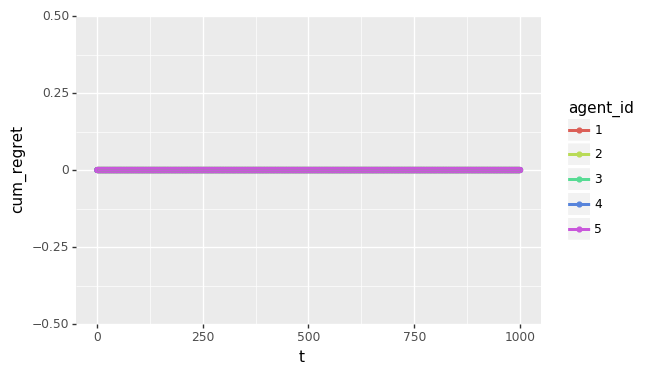

<ggplot: (8767306830741)>


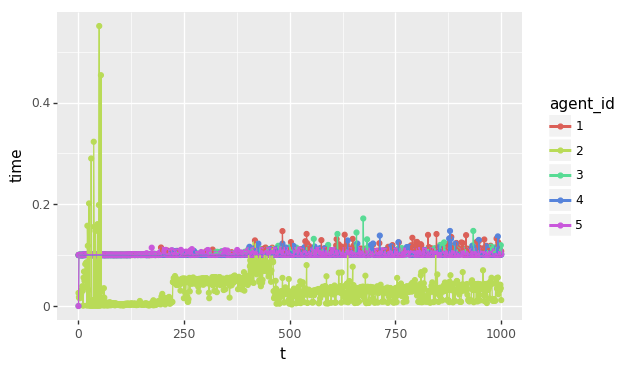

<ggplot: (8767306810521)>


([      action_id agent_id  cum_optimal  cum_regret  instant_regret     t  \
  0             1        1     0.999721         0.0             0.0     1   
  1             2        2     0.999721         0.0             0.0     1   
  2             3        3     0.999721         0.0             0.0     1   
  3             4        4     0.999721         0.0             0.0     1   
  4             5        5     0.999721         0.0             0.0     1   
  5             6        1     1.186695         0.0             0.0     2   
  6             7        2     1.186695         0.0             0.0     2   
  7             8        3     1.186695         0.0             0.0     2   
  8             9        4     1.186695         0.0             0.0     2   
  9            10        5     1.186695         0.0             0.0     2   
  10           11        1     2.107762         0.0             0.0     3   
  11           12        2     2.107762         0.0             0.0     3   

In [10]:
agents = [make_mala_agent(),
          make_laplace_agent(),
          make_pgts_agent(),
          make_langevin_agent(),
          make_sagald_agent()]
simple_compare(agents, num_articles, dim, var, 1000, 1, verbosity=1)

In [11]:
import copy

pgts_copy = copy.deepcopy(agents[2])

#reg = BernoulliRegression(agents[2].reg)

In [12]:
del verbosity

In [13]:
def redraw_samples(agent, num, verbosity=1):
    samples = []
    #theta = agent.theta
    agent_copy = copy.deepcopy(agent)
    for i in range(num):
        printv("Drawing sample %d" % (i+1), verbosity, 1)
        #agent_copy.theta= theta
        s = agent_copy.get_sample()
        samples += [s]
        printv(" "+repr(s), verbosity, 2)
    return np.asarray(samples)
#def redraw_samples_sagald(agent, num, verbosity=1):

In [14]:
def redraw_samples_for_agents(agents, num, verbosity=1):
    samples_list = []

    for agent in agents:
        samples = redraw_samples(agent, num, verbosity)
        samples_list += [samples]
    samples_list = np.asarray(samples_list)
    return samples_list

In [16]:
samples_list = []
agents[0].v=1
agents[0].time=0
agents[0].n_steps=500
for agent in agents:
    samples = redraw_samples(agent, 1000, 2)
    samples_list += [samples]
samples_list = np.asarray(samples_list)

Drawing sample 1
 Sample: array([ 1.562109  , -0.28253618, -0.54251167, -0.95601452,  0.36833039,
       -1.85765798,  1.70559659, -1.14299386,  0.52264031, -0.23025454,
        1.56903792, -2.34332014, -0.46935515, -0.65628801,  1.1573286 ,
       -0.80689323, -0.29514075, -0.68519226,  0.03678215,  0.55359375])
 Accept proportion: 0.584000
 Steps taken: 500
 array([ 1.562109  , -0.28253618, -0.54251167, -0.95601452,  0.36833039,
       -1.85765798,  1.70559659, -1.14299386,  0.52264031, -0.23025454,
        1.56903792, -2.34332014, -0.46935515, -0.65628801,  1.1573286 ,
       -0.80689323, -0.29514075, -0.68519226,  0.03678215,  0.55359375])
Drawing sample 2
 Sample: array([ 1.25637972, -0.71066074, -0.71167564, -0.91878316,  0.3823113 ,
       -2.09889665,  1.77268419, -0.77920225,  0.5601057 , -0.23277833,
        1.32534783, -2.40103703, -0.38971945, -0.28459296,  1.02977059,
       -0.52762841, -0.26128065, -0.59666407,  0.07753766,  0.46934463])
 Accept proportion: 0.568000
 Ste

 Sample: array([ 1.34290899, -0.63083534, -0.66987805, -1.06211227,  0.33894728,
       -1.7765922 ,  1.42828254, -1.0862003 ,  0.4330401 , -0.1459607 ,
        1.2884745 , -2.17560693, -0.56901037, -0.52988193,  1.15676437,
       -0.80324402, -0.1713722 , -0.50506641,  0.01766407,  0.41197534])
 Accept proportion: 0.516000
 Steps taken: 500
 array([ 1.34290899, -0.63083534, -0.66987805, -1.06211227,  0.33894728,
       -1.7765922 ,  1.42828254, -1.0862003 ,  0.4330401 , -0.1459607 ,
        1.2884745 , -2.17560693, -0.56901037, -0.52988193,  1.15676437,
       -0.80324402, -0.1713722 , -0.50506641,  0.01766407,  0.41197534])
Drawing sample 15
 Sample: array([ 1.55377906, -0.4312559 , -0.76169305, -0.89672703,  0.59339821,
       -2.06708392,  1.76765495, -0.88868938,  0.41188082, -0.28867536,
        1.35531677, -2.28925476, -0.281976  , -0.44348104,  1.02352357,
       -1.05483589, -0.01893437, -0.61153994, -0.09826357,  0.80819735])
 Accept proportion: 0.556000
 Steps taken: 500
 a

 Sample: array([ 1.39319144, -0.26069667, -0.58252476, -0.96391949,  0.44444529,
       -1.97562259,  1.3032619 , -0.84110644,  0.51761336, -0.2861835 ,
        1.36567704, -2.30444365, -0.47348808, -0.46517475,  0.87192758,
       -0.6034636 , -0.3296317 , -0.62325254,  0.13074799,  0.5467178 ])
 Accept proportion: 0.592000
 Steps taken: 500
 array([ 1.39319144, -0.26069667, -0.58252476, -0.96391949,  0.44444529,
       -1.97562259,  1.3032619 , -0.84110644,  0.51761336, -0.2861835 ,
        1.36567704, -2.30444365, -0.47348808, -0.46517475,  0.87192758,
       -0.6034636 , -0.3296317 , -0.62325254,  0.13074799,  0.5467178 ])
Drawing sample 28
 Sample: array([ 1.53548339, -0.66363086, -1.05207923, -0.85852439,  0.70631531,
       -1.93667309,  1.41791801, -0.95651748,  0.47026637, -0.22718099,
        1.48250142, -2.28555737, -0.16356346, -0.72995424,  1.20617639,
       -0.59865142, -0.19172274, -0.46074798,  0.15366104,  0.51163296])
 Accept proportion: 0.562000
 Steps taken: 500
 a

 Sample: array([ 1.47386207, -0.18433149, -0.75611632, -0.86168108,  0.52687885,
       -2.00147131,  1.42876671, -0.87372309,  0.3530933 , -0.36904309,
        1.56994623, -2.32037308, -0.23407331, -0.37863573,  1.25147348,
       -0.79852968, -0.23991456, -0.59268047,  0.215473  ,  0.6170354 ])
 Accept proportion: 0.568000
 Steps taken: 500
 array([ 1.47386207, -0.18433149, -0.75611632, -0.86168108,  0.52687885,
       -2.00147131,  1.42876671, -0.87372309,  0.3530933 , -0.36904309,
        1.56994623, -2.32037308, -0.23407331, -0.37863573,  1.25147348,
       -0.79852968, -0.23991456, -0.59268047,  0.215473  ,  0.6170354 ])
Drawing sample 41
 Sample: array([ 1.20331956, -0.44750035, -0.76255235, -1.13967969,  0.37422874,
       -1.78266314,  1.56419083, -0.76819464,  0.27410513, -0.35713629,
        1.44162005, -2.29031914, -0.4292502 , -0.40112816,  1.37496849,
       -0.86699458, -0.1643187 , -0.40404875, -0.20301937,  0.184418  ])
 Accept proportion: 0.562000
 Steps taken: 500
 a

 Sample: array([ 1.34859785, -0.42936312, -0.85734559, -1.04712709,  0.46462229,
       -2.18181586,  1.4632037 , -1.02588259,  0.29372986, -0.50845747,
        1.47299204, -2.46144416, -0.36939372, -0.61906673,  1.08084555,
       -0.72221637, -0.30996388, -0.82115031, -0.12238925,  0.69202057])
 Accept proportion: 0.552000
 Steps taken: 500
 array([ 1.34859785, -0.42936312, -0.85734559, -1.04712709,  0.46462229,
       -2.18181586,  1.4632037 , -1.02588259,  0.29372986, -0.50845747,
        1.47299204, -2.46144416, -0.36939372, -0.61906673,  1.08084555,
       -0.72221637, -0.30996388, -0.82115031, -0.12238925,  0.69202057])
Drawing sample 54
 Sample: array([ 1.36899933, -0.53615555, -0.68850288, -1.1284751 ,  0.65021012,
       -2.02775207,  1.61758114, -0.83578509,  0.52391782, -0.64689743,
        1.3650373 , -2.30295812, -0.25300836, -0.74114168,  1.12101306,
       -0.82863113, -0.25342898, -0.72032617,  0.13502219,  0.93581501])
 Accept proportion: 0.576000
 Steps taken: 500
 a

 Sample: array([ 1.51061149, -0.41889982, -0.88038892, -1.00900966,  0.50366276,
       -1.97043014,  1.64057577, -0.98220418,  0.40108173, -0.33021413,
        1.43589623, -2.34819808, -0.40733017, -0.69108139,  1.32366273,
       -0.64429385, -0.14489872, -0.68432501,  0.0668786 ,  0.54486952])
 Accept proportion: 0.542000
 Steps taken: 500
 array([ 1.51061149, -0.41889982, -0.88038892, -1.00900966,  0.50366276,
       -1.97043014,  1.64057577, -0.98220418,  0.40108173, -0.33021413,
        1.43589623, -2.34819808, -0.40733017, -0.69108139,  1.32366273,
       -0.64429385, -0.14489872, -0.68432501,  0.0668786 ,  0.54486952])
Drawing sample 67
 Sample: array([ 1.4526067 , -0.60489497, -0.7770652 , -0.98611154,  0.44064519,
       -1.80909385,  1.43863433, -0.81023584,  0.5741855 , -0.43350504,
        1.46488777, -2.34833873, -0.41311079, -0.8621562 ,  1.04519913,
       -0.7629176 , -0.35093724, -0.51465753,  0.09987553,  0.51440858])
 Accept proportion: 0.550000
 Steps taken: 500
 a

 Sample: array([ 1.50621835, -0.39918083, -0.49667646, -0.93709248,  0.33955299,
       -1.77887064,  1.51042532, -0.86537993,  0.71632455, -0.10184506,
        1.41755198, -2.23478887, -0.56335699, -0.71404555,  1.22506027,
       -0.85168999, -0.14062901, -0.91204702,  0.30946785,  0.60616264])
 Accept proportion: 0.580000
 Steps taken: 500
 array([ 1.50621835, -0.39918083, -0.49667646, -0.93709248,  0.33955299,
       -1.77887064,  1.51042532, -0.86537993,  0.71632455, -0.10184506,
        1.41755198, -2.23478887, -0.56335699, -0.71404555,  1.22506027,
       -0.85168999, -0.14062901, -0.91204702,  0.30946785,  0.60616264])
Drawing sample 80
 Sample: array([ 1.57455506, -0.36659676, -0.86386501, -0.94034436,  0.25622125,
       -2.03772845,  1.42097002, -0.63006981,  0.48532821, -0.22100016,
        1.54341792, -2.23339828, -0.33412649, -0.75427847,  1.06350236,
       -0.98691552, -0.50220065, -0.66812292,  0.12971293,  0.55422421])
 Accept proportion: 0.544000
 Steps taken: 500
 a

 Sample: array([ 1.33998513, -0.57738388, -0.8143457 , -0.91114787,  0.51282209,
       -1.97675817,  1.32941565, -0.77527896,  0.68441437, -0.39165098,
        1.30257355, -2.53883224, -0.26805139, -0.48523058,  1.08996935,
       -0.68989488, -0.24848132, -0.60626137,  0.32160991,  0.6179379 ])
 Accept proportion: 0.614000
 Steps taken: 500
 array([ 1.33998513, -0.57738388, -0.8143457 , -0.91114787,  0.51282209,
       -1.97675817,  1.32941565, -0.77527896,  0.68441437, -0.39165098,
        1.30257355, -2.53883224, -0.26805139, -0.48523058,  1.08996935,
       -0.68989488, -0.24848132, -0.60626137,  0.32160991,  0.6179379 ])
Drawing sample 93
 Sample: array([ 1.2283062 , -0.62085912, -0.51309023, -0.7397784 ,  0.48633322,
       -2.16134202,  1.46266796, -1.01881227,  0.23639888, -0.22387514,
        1.31606428, -2.16231346, -0.30866831, -0.814152  ,  1.21110723,
       -0.8953042 , -0.20840134, -0.66345908,  0.11991659,  0.57858285])
 Accept proportion: 0.580000
 Steps taken: 500
 a

 Sample: array([ 1.56075918, -0.53899841, -0.87060883, -0.91132793,  0.83740059,
       -2.20767139,  1.59454371, -0.91626041,  0.67582369, -0.22205834,
        1.84000433, -2.43096538, -0.45716466, -0.39518064,  1.16204103,
       -0.8504757 , -0.10637148, -0.56467121,  0.10981984,  0.57307488])
 Accept proportion: 0.586000
 Steps taken: 500
 array([ 1.56075918, -0.53899841, -0.87060883, -0.91132793,  0.83740059,
       -2.20767139,  1.59454371, -0.91626041,  0.67582369, -0.22205834,
        1.84000433, -2.43096538, -0.45716466, -0.39518064,  1.16204103,
       -0.8504757 , -0.10637148, -0.56467121,  0.10981984,  0.57307488])
Drawing sample 106
 Sample: array([ 1.52122439, -0.66447088, -0.50369838, -0.98189476,  0.41807044,
       -1.98222961,  1.42975169, -1.01688762,  0.50305255, -0.31116622,
        1.08911285, -2.16672074, -0.52441022, -0.54868862,  0.82384388,
       -1.07721244, -0.39109456, -0.86758824, -0.06810163,  0.49014569])
 Accept proportion: 0.592000
 Steps taken: 500
 

 Sample: array([ 1.30854432, -0.36351823, -0.84085809, -1.06896741,  0.51756255,
       -2.03652082,  1.53916786, -1.08366291,  0.62566898, -0.47974285,
        1.52759466, -2.39982812, -0.23828106, -0.72877636,  1.40674027,
       -0.92495417,  0.15288884, -0.79117958,  0.02440667,  0.88075755])
 Accept proportion: 0.562000
 Steps taken: 500
 array([ 1.30854432, -0.36351823, -0.84085809, -1.06896741,  0.51756255,
       -2.03652082,  1.53916786, -1.08366291,  0.62566898, -0.47974285,
        1.52759466, -2.39982812, -0.23828106, -0.72877636,  1.40674027,
       -0.92495417,  0.15288884, -0.79117958,  0.02440667,  0.88075755])
Drawing sample 119
 Sample: array([ 1.6833053 , -0.5515688 , -0.67175695, -1.00011261,  0.33022225,
       -2.13264817,  1.57637433, -0.98879006,  0.3085393 , -0.48454576,
        1.59080522, -2.06696015, -0.2895117 , -0.51578916,  1.36112403,
       -1.21270991, -0.21348905, -0.70866272,  0.09137486,  0.72670008])
 Accept proportion: 0.528000
 Steps taken: 500
 

 Sample: array([ 1.59293808, -0.52030294, -0.61182907, -0.87002162,  0.67232202,
       -1.85862504,  1.82782403, -1.19006081,  0.49626549, -0.48317058,
        1.71649001, -2.37137356, -0.42933712, -0.45053147,  1.35363408,
       -0.8613768 , -0.24186793, -0.76453483,  0.11829252,  0.60793285])
 Accept proportion: 0.598000
 Steps taken: 500
 array([ 1.59293808, -0.52030294, -0.61182907, -0.87002162,  0.67232202,
       -1.85862504,  1.82782403, -1.19006081,  0.49626549, -0.48317058,
        1.71649001, -2.37137356, -0.42933712, -0.45053147,  1.35363408,
       -0.8613768 , -0.24186793, -0.76453483,  0.11829252,  0.60793285])
Drawing sample 132
 Sample: array([ 1.14956901, -0.66424422, -0.7124251 , -0.8717906 ,  0.43648881,
       -2.17322944,  1.50347046, -0.9010433 ,  0.34814381, -0.27919933,
        1.39661122, -2.46325852, -0.42476436, -0.50452756,  1.18211996,
       -0.78895542,  0.14967817, -0.40987891,  0.21550513,  0.63744769])
 Accept proportion: 0.586000
 Steps taken: 500
 

 Sample: array([ 1.31677791, -0.50697093, -0.79422601, -0.94757867,  0.18508974,
       -1.98704554,  1.64952086, -1.15414312,  0.43657154, -0.56773631,
        1.56984594, -2.53606107, -0.53843403, -0.41028137,  1.22597313,
       -0.79862868, -0.0032648 , -0.42330606,  0.33523213,  0.53443005])
 Accept proportion: 0.556000
 Steps taken: 500
 array([ 1.31677791, -0.50697093, -0.79422601, -0.94757867,  0.18508974,
       -1.98704554,  1.64952086, -1.15414312,  0.43657154, -0.56773631,
        1.56984594, -2.53606107, -0.53843403, -0.41028137,  1.22597313,
       -0.79862868, -0.0032648 , -0.42330606,  0.33523213,  0.53443005])
Drawing sample 145
 Sample: array([ 1.56130502, -0.56620668, -0.62308431, -0.95416602,  0.41962496,
       -1.51102015,  1.53610636, -1.08176268,  0.43213397, -0.38294404,
        1.24620461, -2.23282396, -0.45924708, -0.7610926 ,  1.17488217,
       -1.05882751, -0.24827158, -0.55146013,  0.16855663,  0.76380293])
 Accept proportion: 0.568000
 Steps taken: 500
 

 Sample: array([ 1.45100447, -0.60238178, -0.65059104, -1.1668335 ,  0.59513816,
       -1.78389049,  1.59419291, -0.7628231 ,  0.4662706 , -0.15617005,
        1.4841585 , -2.58935168, -0.29507148, -0.82858618,  1.3606387 ,
       -0.82878387, -0.06590032, -0.6583127 ,  0.15239102,  0.73459002])
 Accept proportion: 0.616000
 Steps taken: 500
 array([ 1.45100447, -0.60238178, -0.65059104, -1.1668335 ,  0.59513816,
       -1.78389049,  1.59419291, -0.7628231 ,  0.4662706 , -0.15617005,
        1.4841585 , -2.58935168, -0.29507148, -0.82858618,  1.3606387 ,
       -0.82878387, -0.06590032, -0.6583127 ,  0.15239102,  0.73459002])
Drawing sample 158
 Sample: array([ 1.19178749, -0.3371747 , -0.80293576, -1.09530136,  0.58541068,
       -2.02744252,  1.30053772, -1.02141878,  0.42006815, -0.22302566,
        1.47955497, -2.49061116, -0.25989971, -0.64704124,  1.23500683,
       -0.70445245, -0.26240863, -0.76147673,  0.30578405,  0.52853026])
 Accept proportion: 0.540000
 Steps taken: 500
 

 Sample: array([ 1.56154534, -0.51582926, -0.54760525, -0.76036385,  0.51806271,
       -1.7534253 ,  1.61380744, -1.44054897,  0.44342603, -0.16949806,
        1.48281903, -2.2463962 , -0.33547882, -0.29699637,  1.2577975 ,
       -1.0242186 , -0.07646525, -0.78101336,  0.01362678,  0.40597893])
 Accept proportion: 0.562000
 Steps taken: 500
 array([ 1.56154534, -0.51582926, -0.54760525, -0.76036385,  0.51806271,
       -1.7534253 ,  1.61380744, -1.44054897,  0.44342603, -0.16949806,
        1.48281903, -2.2463962 , -0.33547882, -0.29699637,  1.2577975 ,
       -1.0242186 , -0.07646525, -0.78101336,  0.01362678,  0.40597893])
Drawing sample 171
 Sample: array([ 1.64593689, -0.43512636, -0.75536297, -1.0640145 ,  0.41846062,
       -1.93861578,  1.48938112, -0.99157448,  0.42382949, -0.48591651,
        1.49818099, -2.32438653, -0.3985922 , -0.85423614,  1.06985546,
       -0.74860791, -0.19939817, -0.77819534, -0.21449704,  0.68958046])
 Accept proportion: 0.606000
 Steps taken: 500
 

 Sample: array([ 1.50884621, -0.57402098, -0.8955311 , -0.98315249,  0.40117583,
       -1.86005018,  1.52300306, -0.99004514,  0.40474253, -0.49130193,
        1.55509764, -2.27026452, -0.39330365, -0.67798765,  1.13928965,
       -0.90363312, -0.28874202, -0.63677738,  0.13645316,  0.66823381])
 Accept proportion: 0.580000
 Steps taken: 500
 array([ 1.50884621, -0.57402098, -0.8955311 , -0.98315249,  0.40117583,
       -1.86005018,  1.52300306, -0.99004514,  0.40474253, -0.49130193,
        1.55509764, -2.27026452, -0.39330365, -0.67798765,  1.13928965,
       -0.90363312, -0.28874202, -0.63677738,  0.13645316,  0.66823381])
Drawing sample 184
 Sample: array([ 1.60816707, -0.51933234, -0.87460449, -0.99143955,  0.67138359,
       -2.14727365,  1.37268373, -0.89809176,  0.50462051, -0.31792257,
        1.56017781, -2.50834362, -0.19364316, -0.67684481,  1.25539732,
       -0.79962599, -0.06847241, -0.83418141,  0.08590892,  0.58197279])
 Accept proportion: 0.568000
 Steps taken: 500
 

 Sample: array([ 1.55170319, -0.51059005, -0.74673001, -0.98309159,  0.5751438 ,
       -1.91028559,  1.43766695, -1.09829496,  0.33996458, -0.41537327,
        1.83916972, -2.18276322, -0.42309875, -0.52527166,  1.2075382 ,
       -1.01602236, -0.18312838, -0.69037438,  0.19437517,  0.42843548])
 Accept proportion: 0.570000
 Steps taken: 500
 array([ 1.55170319, -0.51059005, -0.74673001, -0.98309159,  0.5751438 ,
       -1.91028559,  1.43766695, -1.09829496,  0.33996458, -0.41537327,
        1.83916972, -2.18276322, -0.42309875, -0.52527166,  1.2075382 ,
       -1.01602236, -0.18312838, -0.69037438,  0.19437517,  0.42843548])
Drawing sample 197
 Sample: array([ 1.43684804, -0.63821967, -0.83859404, -1.02505905,  0.44599849,
       -1.91793026,  1.40527749, -0.72018171,  0.58340501, -0.34141294,
        1.24220887, -2.3531662 , -0.42795879, -0.67778816,  1.07412567,
       -0.87945835, -0.42025874, -0.67713486,  0.14724221,  0.36046362])
 Accept proportion: 0.562000
 Steps taken: 500
 

 Sample: array([ 1.45681177, -0.52948342, -0.65110471, -0.89238327,  0.44920856,
       -2.24781428,  1.66521209, -1.06536784,  0.40526137, -0.41943424,
        1.52218456, -2.13126919, -0.36168225, -0.75671665,  1.10777927,
       -0.82299785, -0.43401833, -0.67808407, -0.13711066,  0.95869646])
 Accept proportion: 0.548000
 Steps taken: 500
 array([ 1.45681177, -0.52948342, -0.65110471, -0.89238327,  0.44920856,
       -2.24781428,  1.66521209, -1.06536784,  0.40526137, -0.41943424,
        1.52218456, -2.13126919, -0.36168225, -0.75671665,  1.10777927,
       -0.82299785, -0.43401833, -0.67808407, -0.13711066,  0.95869646])
Drawing sample 210
 Sample: array([ 1.40599827, -0.70758929, -0.75908598, -0.97123292,  0.50254466,
       -1.9789455 ,  1.40308031, -0.93058149,  0.43195523, -0.27064924,
        1.81656953, -2.54091995, -0.05964326, -0.75716769,  1.28396375,
       -0.86338138, -0.15278049, -0.70170236,  0.24417917,  0.55495   ])
 Accept proportion: 0.574000
 Steps taken: 500
 

 Sample: array([ 2.0030992 , -0.47695881, -0.78165412, -1.01669228,  0.40369129,
       -2.1478615 ,  1.7588602 , -0.85786562,  0.37286093, -0.51278848,
        1.47088711, -2.54656901, -0.41649053, -0.35916706,  1.09026428,
       -1.06250583, -0.12290462, -0.68174096,  0.27548512,  0.85673543])
 Accept proportion: 0.580000
 Steps taken: 500
 array([ 2.0030992 , -0.47695881, -0.78165412, -1.01669228,  0.40369129,
       -2.1478615 ,  1.7588602 , -0.85786562,  0.37286093, -0.51278848,
        1.47088711, -2.54656901, -0.41649053, -0.35916706,  1.09026428,
       -1.06250583, -0.12290462, -0.68174096,  0.27548512,  0.85673543])
Drawing sample 223
 Sample: array([ 1.57809019, -0.5818678 , -0.7508715 , -0.82394791,  0.71484968,
       -1.9644151 ,  1.44540254, -1.1006986 ,  0.56936356, -0.41692047,
        1.5608419 , -2.43778435, -0.37165775, -0.6106788 ,  1.2793728 ,
       -0.70482439, -0.31387942, -0.44780919,  0.18603358,  0.67331154])
 Accept proportion: 0.528000
 Steps taken: 500
 

 Sample: array([ 1.34685897, -0.49799848, -0.81650402, -1.09532414,  0.48192383,
       -2.1901984 ,  1.47437717, -0.79295749,  0.58322013, -0.35575131,
        1.41658596, -1.97241049, -0.18145124, -0.55386029,  1.35334145,
       -0.77478495, -0.33935485, -0.78538802, -0.20277073,  0.80587247])
 Accept proportion: 0.618000
 Steps taken: 500
 array([ 1.34685897, -0.49799848, -0.81650402, -1.09532414,  0.48192383,
       -2.1901984 ,  1.47437717, -0.79295749,  0.58322013, -0.35575131,
        1.41658596, -1.97241049, -0.18145124, -0.55386029,  1.35334145,
       -0.77478495, -0.33935485, -0.78538802, -0.20277073,  0.80587247])
Drawing sample 236
 Sample: array([ 1.33579246, -0.39691508, -0.77645157, -1.0776941 ,  0.42377617,
       -1.98025125,  1.44566881, -0.8431142 ,  0.6055859 , -0.32599614,
        1.43858004, -2.26449651, -0.20069609, -0.57801725,  1.16019563,
       -0.67699722, -0.34190913, -0.72559344, -0.10796724,  0.45821458])
 Accept proportion: 0.578000
 Steps taken: 500
 

 Sample: array([ 1.60509514, -0.42943292, -0.65257791, -0.69009138,  0.48694499,
       -1.97850601,  1.60628734, -1.16519858,  0.20975507, -0.39391938,
        1.40604899, -2.44911426, -0.542341  , -0.47409352,  0.98208013,
       -0.82345655, -0.25622922, -0.39314201, -0.05227284,  0.45072515])
 Accept proportion: 0.526000
 Steps taken: 500
 array([ 1.60509514, -0.42943292, -0.65257791, -0.69009138,  0.48694499,
       -1.97850601,  1.60628734, -1.16519858,  0.20975507, -0.39391938,
        1.40604899, -2.44911426, -0.542341  , -0.47409352,  0.98208013,
       -0.82345655, -0.25622922, -0.39314201, -0.05227284,  0.45072515])
Drawing sample 249
 Sample: array([ 1.63418216, -0.39023862, -0.72360531, -0.86598829,  0.3046493 ,
       -1.67457338,  1.50734217, -1.22750443,  0.4060871 , -0.351649  ,
        1.35216908, -2.14470604, -0.49410096, -0.58161443,  1.31414642,
       -0.81205027, -0.26621007, -0.48610192,  0.29460553,  0.54890131])
 Accept proportion: 0.588000
 Steps taken: 500
 

 Sample: array([ 1.45871362, -0.5045475 , -0.69858756, -0.73700297,  0.5552956 ,
       -2.1285863 ,  1.41733169, -1.00419601,  0.60374268, -0.22619442,
        1.33957122, -2.22706372, -0.42719563, -0.4398734 ,  1.15710235,
       -0.60728071, -0.30840293, -0.69742441,  0.03471705,  0.77253245])
 Accept proportion: 0.568000
 Steps taken: 500
 array([ 1.45871362, -0.5045475 , -0.69858756, -0.73700297,  0.5552956 ,
       -2.1285863 ,  1.41733169, -1.00419601,  0.60374268, -0.22619442,
        1.33957122, -2.22706372, -0.42719563, -0.4398734 ,  1.15710235,
       -0.60728071, -0.30840293, -0.69742441,  0.03471705,  0.77253245])
Drawing sample 262
 Sample: array([ 1.31501046, -0.37716132, -0.60222128, -0.6680603 ,  0.59163128,
       -2.1185946 ,  1.42101266, -0.89325097,  0.43459502, -0.41183267,
        1.53127891, -2.13838569, -0.47642728, -0.52111806,  1.2584223 ,
       -0.8766101 , -0.1264656 , -0.7596423 ,  0.09291103,  0.47460346])
 Accept proportion: 0.560000
 Steps taken: 500
 

 Sample: array([ 1.40977745, -0.2782153 , -0.97093527, -0.95751005,  0.61285933,
       -2.13760692,  1.45690637, -1.12198644,  0.48106667, -0.1704557 ,
        1.2970755 , -2.68755006, -0.44322118, -0.62932209,  1.20453239,
       -0.97258229, -0.4969893 , -0.72772535, -0.08282163,  0.49518264])
 Accept proportion: 0.596000
 Steps taken: 500
 array([ 1.40977745, -0.2782153 , -0.97093527, -0.95751005,  0.61285933,
       -2.13760692,  1.45690637, -1.12198644,  0.48106667, -0.1704557 ,
        1.2970755 , -2.68755006, -0.44322118, -0.62932209,  1.20453239,
       -0.97258229, -0.4969893 , -0.72772535, -0.08282163,  0.49518264])
Drawing sample 275
 Sample: array([ 1.40416901, -0.5227018 , -0.76046624, -0.83342399,  0.55107121,
       -2.3381212 ,  1.5358097 , -0.7714439 ,  0.51473301, -0.14259347,
        1.44052139, -2.45359171, -0.38725197, -0.62997115,  1.22617169,
       -0.96651884, -0.07873293, -0.50253489,  0.44110887,  0.58649714])
 Accept proportion: 0.554000
 Steps taken: 500
 

 Sample: array([ 1.48648403, -0.59191918, -0.65735231, -1.02466975,  0.4869015 ,
       -2.18861644,  1.40863181, -0.75502214,  0.22674376, -0.30190767,
        1.45908397, -2.57505361, -0.33822784, -0.75026831,  1.35037107,
       -0.98206052, -0.03630615, -0.74663276,  0.07894276,  0.84275925])
 Accept proportion: 0.548000
 Steps taken: 500
 array([ 1.48648403, -0.59191918, -0.65735231, -1.02466975,  0.4869015 ,
       -2.18861644,  1.40863181, -0.75502214,  0.22674376, -0.30190767,
        1.45908397, -2.57505361, -0.33822784, -0.75026831,  1.35037107,
       -0.98206052, -0.03630615, -0.74663276,  0.07894276,  0.84275925])
Drawing sample 288
 Sample: array([ 1.39873247, -0.36626461, -0.73036678, -1.09952146,  0.43586594,
       -1.62285971,  1.37927238, -0.92243417,  0.40375485, -0.21782037,
        1.47901429, -2.47614446, -0.42004637, -0.37616102,  1.15357877,
       -0.75692865, -0.2503593 , -0.59028447,  0.22234397,  0.52551069])
 Accept proportion: 0.596000
 Steps taken: 500
 

 Sample: array([ 1.37084648, -0.42660346, -0.86819497, -0.79687438,  0.52200531,
       -1.84187856,  1.57148388, -1.28467055,  0.37090605, -0.44933377,
        1.48666385, -2.4143278 , -0.21296833, -0.66265223,  1.03132183,
       -0.74323304, -0.16944702, -0.69683651, -0.06080869,  0.61468698])
 Accept proportion: 0.566000
 Steps taken: 500
 array([ 1.37084648, -0.42660346, -0.86819497, -0.79687438,  0.52200531,
       -1.84187856,  1.57148388, -1.28467055,  0.37090605, -0.44933377,
        1.48666385, -2.4143278 , -0.21296833, -0.66265223,  1.03132183,
       -0.74323304, -0.16944702, -0.69683651, -0.06080869,  0.61468698])
Drawing sample 301
 Sample: array([ 1.58926661, -0.52672765, -0.75822052, -1.00319387,  0.50011701,
       -2.1965545 ,  1.86071099, -0.87693953,  0.35737916, -0.29816185,
        1.55780052, -2.27221685, -0.42863522, -0.77350474,  1.05951351,
       -0.77150581, -0.25250912, -0.72584437,  0.04570506,  0.65389735])
 Accept proportion: 0.580000
 Steps taken: 500
 

 Sample: array([ 1.49946603, -0.47735024, -0.65981861, -0.74071888,  0.34771203,
       -1.73028464,  1.18830616, -1.06902739,  0.5433196 , -0.24135851,
        1.69944961, -2.09979413, -0.62038399, -0.73633461,  1.28314   ,
       -0.93406554, -0.18021946, -0.68527831,  0.33497729,  0.87044681])
 Accept proportion: 0.570000
 Steps taken: 500
 array([ 1.49946603, -0.47735024, -0.65981861, -0.74071888,  0.34771203,
       -1.73028464,  1.18830616, -1.06902739,  0.5433196 , -0.24135851,
        1.69944961, -2.09979413, -0.62038399, -0.73633461,  1.28314   ,
       -0.93406554, -0.18021946, -0.68527831,  0.33497729,  0.87044681])
Drawing sample 314
 Sample: array([ 1.57181603, -0.6840227 , -0.75427347, -0.95224769,  0.49025914,
       -1.91792138,  1.73075171, -0.90878966,  0.28027497, -0.56265526,
        1.41386839, -2.4072845 , -0.58780697, -0.4816211 ,  1.11671202,
       -1.03666838, -0.33550362, -0.82516236,  0.29195581,  0.66298173])
 Accept proportion: 0.562000
 Steps taken: 500
 

 Sample: array([ 1.5130733 , -0.39476307, -0.59335923, -0.95835664,  0.5948088 ,
       -2.19136084,  1.42748464, -0.96950512,  0.37805623, -0.40963539,
        1.56395961, -2.1388583 , -0.24999868, -0.56322903,  1.23834112,
       -1.11272475, -0.30791477, -0.685796  ,  0.17720967,  0.68901171])
 Accept proportion: 0.542000
 Steps taken: 500
 array([ 1.5130733 , -0.39476307, -0.59335923, -0.95835664,  0.5948088 ,
       -2.19136084,  1.42748464, -0.96950512,  0.37805623, -0.40963539,
        1.56395961, -2.1388583 , -0.24999868, -0.56322903,  1.23834112,
       -1.11272475, -0.30791477, -0.685796  ,  0.17720967,  0.68901171])
Drawing sample 327
 Sample: array([ 1.61456638, -0.59210919, -0.60936351, -0.80169837,  0.38021089,
       -1.87877926,  1.58905773, -1.0040391 ,  0.50340422, -0.46566736,
        1.58999609, -2.38522126, -0.40668731, -0.63778003,  1.31657846,
       -0.81347888, -0.50319235, -0.89113775,  0.04986292,  0.451214  ])
 Accept proportion: 0.562000
 Steps taken: 500
 

 Sample: array([ 1.32059241, -0.34852413, -0.60850315, -0.83277176,  0.45281071,
       -2.22923749,  1.52005531, -0.86356522,  0.42846188, -0.24669156,
        1.62608186, -2.23205148, -0.44018929, -0.63753232,  1.18636287,
       -0.90456369, -0.04865656, -0.50918498, -0.050772  ,  0.63191535])
 Accept proportion: 0.582000
 Steps taken: 500
 array([ 1.32059241, -0.34852413, -0.60850315, -0.83277176,  0.45281071,
       -2.22923749,  1.52005531, -0.86356522,  0.42846188, -0.24669156,
        1.62608186, -2.23205148, -0.44018929, -0.63753232,  1.18636287,
       -0.90456369, -0.04865656, -0.50918498, -0.050772  ,  0.63191535])
Drawing sample 340
 Sample: array([ 1.59715771, -0.46168878, -0.69076619, -0.96600882,  0.53420213,
       -2.09123968,  1.46859492, -1.07323007,  0.33468159, -0.26292158,
        1.49956749, -2.28469793, -0.360376  , -0.5264227 ,  1.00282471,
       -0.56822866, -0.3178691 , -0.721988  ,  0.22405387,  0.64304667])
 Accept proportion: 0.584000
 Steps taken: 500
 

 Sample: array([ 1.44221128, -0.71577928, -0.61076199, -1.04197465,  0.37716541,
       -1.95909402,  1.38981023, -0.84720792,  0.39252293, -0.59694348,
        1.69585456, -2.51967881, -0.25545054, -0.65309275,  1.11687832,
       -0.87826046, -0.07895561, -0.84828903,  0.28223822,  0.5135666 ])
 Accept proportion: 0.600000
 Steps taken: 500
 array([ 1.44221128, -0.71577928, -0.61076199, -1.04197465,  0.37716541,
       -1.95909402,  1.38981023, -0.84720792,  0.39252293, -0.59694348,
        1.69585456, -2.51967881, -0.25545054, -0.65309275,  1.11687832,
       -0.87826046, -0.07895561, -0.84828903,  0.28223822,  0.5135666 ])
Drawing sample 353
 Sample: array([ 1.6799991 , -0.36931419, -0.77193227, -1.12955865,  0.56479707,
       -1.81807898,  1.41869255, -0.82866031,  0.43498765, -0.38726567,
        1.43584939, -2.69912688, -0.37283831, -0.77820305,  1.02953396,
       -0.9561154 , -0.18357439, -0.93840329,  0.24633927,  0.72604471])
 Accept proportion: 0.610000
 Steps taken: 500
 

 Sample: array([ 1.55049612, -0.33774045, -0.60293212, -1.02842555,  0.6135323 ,
       -2.05447586,  1.54763667, -1.13497027,  0.44994218, -0.2326294 ,
        1.68833348, -2.19170928, -0.46280256, -0.5455783 ,  1.18869626,
       -1.01941674, -0.20968815, -0.58180715,  0.10398905,  0.45366983])
 Accept proportion: 0.582000
 Steps taken: 500
 array([ 1.55049612, -0.33774045, -0.60293212, -1.02842555,  0.6135323 ,
       -2.05447586,  1.54763667, -1.13497027,  0.44994218, -0.2326294 ,
        1.68833348, -2.19170928, -0.46280256, -0.5455783 ,  1.18869626,
       -1.01941674, -0.20968815, -0.58180715,  0.10398905,  0.45366983])
Drawing sample 366
 Sample: array([ 1.44255143, -0.38529608, -0.76457779, -1.07074486,  0.33913929,
       -1.82892585,  1.51622137, -0.88459654,  0.63089511, -0.298502  ,
        1.44565726, -2.19697523, -0.48406784, -1.01038655,  1.25984876,
       -0.84416656, -0.20207284, -0.49347712,  0.31570399,  0.75459816])
 Accept proportion: 0.564000
 Steps taken: 500
 

 Sample: array([ 1.3710594 , -0.35002687, -0.95291292, -0.8869357 ,  0.84744887,
       -2.26393285,  1.36051372, -1.10409082,  0.31658826, -0.25638676,
        1.4018448 , -2.66104051, -0.34176883, -0.49614129,  1.01530585,
       -0.91989603, -0.29353827, -0.76743804,  0.094646  ,  0.64229532])
 Accept proportion: 0.506000
 Steps taken: 500
 array([ 1.3710594 , -0.35002687, -0.95291292, -0.8869357 ,  0.84744887,
       -2.26393285,  1.36051372, -1.10409082,  0.31658826, -0.25638676,
        1.4018448 , -2.66104051, -0.34176883, -0.49614129,  1.01530585,
       -0.91989603, -0.29353827, -0.76743804,  0.094646  ,  0.64229532])
Drawing sample 379
 Sample: array([ 1.42028319, -0.49452128, -0.54668594, -0.80704724,  0.40847924,
       -1.96108774,  1.47399887, -0.72360452,  0.28618156, -0.17302617,
        1.35155   , -2.41726521, -0.43026185, -0.6977452 ,  1.19761358,
       -0.68344624, -0.26065933, -0.88822691,  0.01965298,  0.81940316])
 Accept proportion: 0.558000
 Steps taken: 500
 

 Sample: array([ 1.57646602, -0.70565641, -0.97420408, -0.91244308,  0.57887753,
       -1.96354181,  1.50176564, -0.99038491,  0.34502931, -0.19545543,
        1.56207219, -2.62753313, -0.5532736 , -0.6642925 ,  1.24662315,
       -1.00601261, -0.32705453, -0.79497416,  0.30296705,  0.80332496])
 Accept proportion: 0.578000
 Steps taken: 500
 array([ 1.57646602, -0.70565641, -0.97420408, -0.91244308,  0.57887753,
       -1.96354181,  1.50176564, -0.99038491,  0.34502931, -0.19545543,
        1.56207219, -2.62753313, -0.5532736 , -0.6642925 ,  1.24662315,
       -1.00601261, -0.32705453, -0.79497416,  0.30296705,  0.80332496])
Drawing sample 392
 Sample: array([ 1.37580572, -0.59628461, -0.80808775, -0.96410296,  0.36979875,
       -1.96682947,  1.412415  , -1.06846846,  0.3381019 , -0.43946208,
        1.41758392, -2.02754318, -0.23907972, -0.46368696,  1.43441731,
       -0.78925868, -0.34088402, -0.80938935,  0.13241139,  0.50118476])
 Accept proportion: 0.556000
 Steps taken: 500
 

 Sample: array([ 1.34597111, -0.59380726, -0.42868998, -0.88708927,  0.41706351,
       -1.94130876,  1.07236417, -0.74908633,  0.52337725, -0.14443943,
        1.48856677, -2.08949957, -0.50930052, -0.61426253,  1.4029713 ,
       -0.7410159 , -0.50573943, -0.6622656 ,  0.04183797,  0.61934062])
 Accept proportion: 0.588000
 Steps taken: 500
 array([ 1.34597111, -0.59380726, -0.42868998, -0.88708927,  0.41706351,
       -1.94130876,  1.07236417, -0.74908633,  0.52337725, -0.14443943,
        1.48856677, -2.08949957, -0.50930052, -0.61426253,  1.4029713 ,
       -0.7410159 , -0.50573943, -0.6622656 ,  0.04183797,  0.61934062])
Drawing sample 405
 Sample: array([ 1.54403774, -0.46755641, -0.89042383, -1.03164762,  0.48386734,
       -1.84050983,  1.56891733, -0.93780538,  0.27625618, -0.09241185,
        1.3548443 , -2.11325225, -0.2820337 , -0.54218295,  1.39316304,
       -0.86706592, -0.30066629, -0.63578824,  0.0101768 ,  0.4854723 ])
 Accept proportion: 0.562000
 Steps taken: 500
 

 Sample: array([ 1.44220537, -0.30425553, -0.78142337, -0.86752532,  0.68326843,
       -1.93534777,  1.45991952, -0.82861694,  0.47527674, -0.44489934,
        1.36054658, -2.30583765, -0.47137179, -0.56912647,  1.11557567,
       -0.66940984, -0.07696369, -0.69116223,  0.1472329 ,  0.46850226])
 Accept proportion: 0.580000
 Steps taken: 500
 array([ 1.44220537, -0.30425553, -0.78142337, -0.86752532,  0.68326843,
       -1.93534777,  1.45991952, -0.82861694,  0.47527674, -0.44489934,
        1.36054658, -2.30583765, -0.47137179, -0.56912647,  1.11557567,
       -0.66940984, -0.07696369, -0.69116223,  0.1472329 ,  0.46850226])
Drawing sample 418
 Sample: array([ 1.4548588 , -0.61262717, -0.79726291, -0.74122027,  0.52804885,
       -1.93381241,  1.51773217, -1.07359587,  0.49810592, -0.30955752,
        1.5582313 , -2.25772351, -0.26398876, -0.55288788,  1.21859863,
       -0.57246752, -0.18101033, -0.77561622,  0.2741415 ,  0.51228578])
 Accept proportion: 0.564000
 Steps taken: 500
 

 Sample: array([ 1.57936948, -0.33039768, -0.39727695, -0.85122559,  0.33624994,
       -1.65502881,  1.69667929, -1.01332921,  0.50405954, -0.58099553,
        1.40167361, -2.26387549, -0.62414464, -0.50880451,  1.29150454,
       -0.66446566, -0.31482069, -0.67049875,  0.05252766,  0.9324321 ])
 Accept proportion: 0.610000
 Steps taken: 500
 array([ 1.57936948, -0.33039768, -0.39727695, -0.85122559,  0.33624994,
       -1.65502881,  1.69667929, -1.01332921,  0.50405954, -0.58099553,
        1.40167361, -2.26387549, -0.62414464, -0.50880451,  1.29150454,
       -0.66446566, -0.31482069, -0.67049875,  0.05252766,  0.9324321 ])
Drawing sample 431
 Sample: array([ 1.39986735, -0.32472825, -0.62418298, -0.85427886,  0.55119524,
       -1.79829781,  1.60479301, -0.89083889,  0.29758919, -0.45678931,
        1.33584631, -2.10564764, -0.21248172, -0.44667289,  1.15767608,
       -0.71925575, -0.27421369, -0.5500335 , -0.10513236,  0.49262659])
 Accept proportion: 0.542000
 Steps taken: 500
 

 Sample: array([ 1.47940439, -0.5688072 , -0.71122308, -0.63513582,  0.45842487,
       -1.82072223,  1.4331131 , -0.917698  ,  0.42162832, -0.48171013,
        1.26971699, -2.18187118, -0.47708345, -0.57415479,  1.35980564,
       -0.74406731, -0.44597422, -0.57584876,  0.09317806,  0.55435161])
 Accept proportion: 0.560000
 Steps taken: 500
 array([ 1.47940439, -0.5688072 , -0.71122308, -0.63513582,  0.45842487,
       -1.82072223,  1.4331131 , -0.917698  ,  0.42162832, -0.48171013,
        1.26971699, -2.18187118, -0.47708345, -0.57415479,  1.35980564,
       -0.74406731, -0.44597422, -0.57584876,  0.09317806,  0.55435161])
Drawing sample 444
 Sample: array([ 1.44630662, -0.49612699, -0.89278775, -1.06762341,  0.4287209 ,
       -1.940197  ,  1.7105118 , -0.81159738,  0.51803943, -0.37680865,
        1.60196611, -2.41713158, -0.40493484, -0.71492651,  1.35067428,
       -0.73690903, -0.15365861, -0.83585508,  0.05471361,  0.42064191])
 Accept proportion: 0.566000
 Steps taken: 500
 

 Sample: array([ 1.75843389, -0.35532554, -0.58473609, -0.83312778,  0.50818704,
       -1.81975561,  1.40998582, -1.21447067,  0.38128108, -0.28907903,
        1.46572224, -2.49113538, -0.66540686, -0.39994434,  1.01840198,
       -0.78198408,  0.10179314, -0.51683655,  0.16168258,  0.35649599])
 Accept proportion: 0.582000
 Steps taken: 500
 array([ 1.75843389, -0.35532554, -0.58473609, -0.83312778,  0.50818704,
       -1.81975561,  1.40998582, -1.21447067,  0.38128108, -0.28907903,
        1.46572224, -2.49113538, -0.66540686, -0.39994434,  1.01840198,
       -0.78198408,  0.10179314, -0.51683655,  0.16168258,  0.35649599])
Drawing sample 457
 Sample: array([ 1.47131304, -0.56278798, -1.00600973, -1.12394587,  0.39522003,
       -2.21869148,  1.48378456, -0.91673301,  0.26011845, -0.38192486,
        1.75198202, -2.61565756, -0.48792309, -0.87632703,  1.12237313,
       -0.92523796, -0.28490203, -0.57405336, -0.1078364 ,  0.50700585])
 Accept proportion: 0.550000
 Steps taken: 500
 

 Sample: array([ 1.16412494, -0.50177151, -0.70002489, -1.03901161,  0.31561042,
       -1.74512901,  1.47777899, -0.80055077,  0.48701042, -0.23298805,
        1.65592305, -2.1972605 , -0.46674669, -0.60566117,  0.90866575,
       -0.50014459, -0.0427036 , -0.66855586,  0.077094  ,  0.50492603])
 Accept proportion: 0.552000
 Steps taken: 500
 array([ 1.16412494, -0.50177151, -0.70002489, -1.03901161,  0.31561042,
       -1.74512901,  1.47777899, -0.80055077,  0.48701042, -0.23298805,
        1.65592305, -2.1972605 , -0.46674669, -0.60566117,  0.90866575,
       -0.50014459, -0.0427036 , -0.66855586,  0.077094  ,  0.50492603])
Drawing sample 470
 Sample: array([ 1.33663637, -0.47354265, -0.77023091, -1.07278408,  0.56548875,
       -2.01580654,  1.5138291 , -0.70515459,  0.49086033, -0.19510468,
        1.58241563, -2.42121819, -0.28511345, -0.50170982,  1.2824359 ,
       -0.43059895, -0.44898034, -0.60322119, -0.20147064,  0.52123979])
 Accept proportion: 0.574000
 Steps taken: 500
 

 Sample: array([ 1.31297216, -0.53892849, -0.54513206, -0.95722245,  0.4543173 ,
       -1.71595904,  1.7675838 , -1.08771536,  0.56593615, -0.12221918,
        1.54812123, -2.13889328, -0.49975704, -0.79906705,  1.20707606,
       -0.7792459 , -0.05744067, -0.66693342,  0.29533958,  0.734692  ])
 Accept proportion: 0.616000
 Steps taken: 500
 array([ 1.31297216, -0.53892849, -0.54513206, -0.95722245,  0.4543173 ,
       -1.71595904,  1.7675838 , -1.08771536,  0.56593615, -0.12221918,
        1.54812123, -2.13889328, -0.49975704, -0.79906705,  1.20707606,
       -0.7792459 , -0.05744067, -0.66693342,  0.29533958,  0.734692  ])
Drawing sample 483
 Sample: array([ 1.40026691e+00, -5.36556914e-01, -7.20052292e-01, -9.08869257e-01,
        6.30945593e-01, -1.98294065e+00,  1.36835221e+00, -9.18045306e-01,
        4.56276028e-01, -1.71750623e-01,  1.50700603e+00, -2.23259395e+00,
       -4.72893472e-01, -5.65096107e-01,  8.50925755e-01, -7.24600262e-01,
       -1.30135461e-01, -6.41667775e-

 Sample: array([ 1.38824313, -0.28479059, -0.4990548 , -0.98636188,  0.54154981,
       -2.19914634,  1.57770585, -1.33843395,  0.64934196, -0.21958553,
        1.47569322, -2.18215872, -0.44780239, -0.52309777,  1.07513392,
       -0.72034363, -0.31380442, -0.8299095 ,  0.05765676,  0.5064839 ])
 Accept proportion: 0.552000
 Steps taken: 500
 array([ 1.38824313, -0.28479059, -0.4990548 , -0.98636188,  0.54154981,
       -2.19914634,  1.57770585, -1.33843395,  0.64934196, -0.21958553,
        1.47569322, -2.18215872, -0.44780239, -0.52309777,  1.07513392,
       -0.72034363, -0.31380442, -0.8299095 ,  0.05765676,  0.5064839 ])
Drawing sample 495
 Sample: array([ 1.70236121, -0.46327671, -0.83390497, -0.83068748,  0.43926449,
       -1.93069566,  1.44698372, -1.1813358 ,  0.47518619, -0.34241522,
        1.63851033, -2.41620944, -0.1890283 , -0.88616383,  1.15754602,
       -0.78730774, -0.21874853, -0.95331857,  0.14495663,  0.40619034])
 Accept proportion: 0.576000
 Steps taken: 500
 

 Sample: array([ 1.41516847, -0.44080696, -0.79806252, -0.88365525,  0.47819683,
       -1.98502006,  1.65173168, -0.80423792,  0.39684714, -0.11684345,
        1.37912201, -2.27521221, -0.45882394, -0.3089361 ,  1.27755155,
       -0.85912698, -0.16972483, -0.6549058 ,  0.02686036,  0.42603299])
 Accept proportion: 0.532000
 Steps taken: 500
 array([ 1.41516847, -0.44080696, -0.79806252, -0.88365525,  0.47819683,
       -1.98502006,  1.65173168, -0.80423792,  0.39684714, -0.11684345,
        1.37912201, -2.27521221, -0.45882394, -0.3089361 ,  1.27755155,
       -0.85912698, -0.16972483, -0.6549058 ,  0.02686036,  0.42603299])
Drawing sample 508
 Sample: array([ 1.57129737, -0.61769696, -0.57826589, -0.95257377,  0.51918284,
       -1.9522866 ,  1.56872133, -0.91359523,  0.11878602, -0.27594563,
        1.47744561, -2.30327453, -0.37763506, -0.53056637,  1.15894096,
       -0.90228463, -0.29896637, -0.69314967,  0.04937071,  0.78643137])
 Accept proportion: 0.556000
 Steps taken: 500
 

 Sample: array([ 1.6383644 , -0.52110599, -0.71051431, -0.77150101,  0.69428389,
       -1.86757987,  1.6859854 , -0.92425604,  0.30697232, -0.37979198,
        1.4613594 , -2.29228712, -0.31447349, -0.4763776 ,  1.2733607 ,
       -0.77734192, -0.11810568, -0.74895876,  0.24413874,  0.52787349])
 Accept proportion: 0.550000
 Steps taken: 500
 array([ 1.6383644 , -0.52110599, -0.71051431, -0.77150101,  0.69428389,
       -1.86757987,  1.6859854 , -0.92425604,  0.30697232, -0.37979198,
        1.4613594 , -2.29228712, -0.31447349, -0.4763776 ,  1.2733607 ,
       -0.77734192, -0.11810568, -0.74895876,  0.24413874,  0.52787349])
Drawing sample 521
 Sample: array([ 1.55571039, -0.35127662, -0.61355203, -1.23702038,  0.57698246,
       -2.14643324,  1.26745479, -0.87298397,  0.55083213, -0.45071179,
        1.37252504, -2.32310931, -0.34105439, -0.71481765,  1.17587362,
       -0.84687545, -0.28538087, -0.64534793, -0.12053907,  0.66592908])
 Accept proportion: 0.546000
 Steps taken: 500
 

 Sample: array([ 1.65836257, -0.41141298, -0.7192262 , -0.82804086,  0.37268134,
       -1.7858934 ,  1.56157158, -1.01265951,  0.71685135, -0.50589641,
        1.58902579, -2.49801978, -0.02119668, -0.73154163,  1.16882011,
       -0.93864935,  0.09912996, -0.62530457, -0.03038392,  0.70886468])
 Accept proportion: 0.596000
 Steps taken: 500
 array([ 1.65836257, -0.41141298, -0.7192262 , -0.82804086,  0.37268134,
       -1.7858934 ,  1.56157158, -1.01265951,  0.71685135, -0.50589641,
        1.58902579, -2.49801978, -0.02119668, -0.73154163,  1.16882011,
       -0.93864935,  0.09912996, -0.62530457, -0.03038392,  0.70886468])
Drawing sample 534
 Sample: array([ 1.35783187, -0.64217446, -0.85157162, -0.95557228,  0.24510703,
       -1.96091653,  1.48463618, -1.09360257,  0.36912923, -0.20081409,
        1.45171804, -2.54933722, -0.65704235, -0.78422575,  1.16422973,
       -1.07347046, -0.14595021, -0.65040498,  0.22214461,  0.44458407])
 Accept proportion: 0.552000
 Steps taken: 500
 

 Sample: array([ 1.36895828, -0.44694763, -0.66821799, -0.82476582,  0.66314137,
       -1.91722921,  1.70372491, -0.97949118,  0.38304249, -0.27928321,
        1.38778929, -2.16466428, -0.38750073, -0.58679665,  1.17282986,
       -0.69827391,  0.04170992, -0.68326192,  0.20276924,  0.52246214])
 Accept proportion: 0.584000
 Steps taken: 500
 array([ 1.36895828, -0.44694763, -0.66821799, -0.82476582,  0.66314137,
       -1.91722921,  1.70372491, -0.97949118,  0.38304249, -0.27928321,
        1.38778929, -2.16466428, -0.38750073, -0.58679665,  1.17282986,
       -0.69827391,  0.04170992, -0.68326192,  0.20276924,  0.52246214])
Drawing sample 547
 Sample: array([ 1.53482057, -0.60072148, -0.82087009, -1.0639882 ,  0.56114111,
       -1.97681361,  1.74022694, -0.90095703,  0.12958011, -0.4077122 ,
        1.58213516, -2.59072512, -0.38150856, -0.60537187,  1.39128678,
       -0.926727  , -0.31307379, -0.71288683,  0.15588375,  0.72641707])
 Accept proportion: 0.588000
 Steps taken: 500
 

 Sample: array([ 1.51265426, -0.54433546, -0.80015792, -0.66892117,  0.44901258,
       -1.88872615,  1.54876891, -0.89218649,  0.46417692, -0.43426006,
        1.42631845, -2.42526621, -0.59609209, -0.81648481,  1.33418812,
       -0.91621587, -0.29558991, -0.53651692, -0.07966867,  0.59929866])
 Accept proportion: 0.576000
 Steps taken: 500
 array([ 1.51265426, -0.54433546, -0.80015792, -0.66892117,  0.44901258,
       -1.88872615,  1.54876891, -0.89218649,  0.46417692, -0.43426006,
        1.42631845, -2.42526621, -0.59609209, -0.81648481,  1.33418812,
       -0.91621587, -0.29558991, -0.53651692, -0.07966867,  0.59929866])
Drawing sample 560
 Sample: array([ 1.47678786e+00, -6.37522244e-01, -5.28014697e-01, -7.69515165e-01,
        4.76881141e-01, -1.85739262e+00,  1.56409078e+00, -1.04491881e+00,
        7.81490772e-01, -8.63898360e-02,  1.80574663e+00, -2.52785687e+00,
       -4.64255251e-01, -5.96134524e-01,  9.22567132e-01, -8.89313112e-01,
       -1.62080810e-01, -6.07507440e-

 Sample: array([ 1.40698227, -0.3010966 , -0.82968172, -1.16049099,  0.48848661,
       -2.18659011,  1.60837442, -0.99082326,  0.47503703, -0.275423  ,
        1.42984002, -2.40248166, -0.28209266, -0.61569903,  1.38172281,
       -0.90924368, -0.44645229, -0.55497776,  0.00327586,  0.43884594])
 Accept proportion: 0.576000
 Steps taken: 500
 array([ 1.40698227, -0.3010966 , -0.82968172, -1.16049099,  0.48848661,
       -2.18659011,  1.60837442, -0.99082326,  0.47503703, -0.275423  ,
        1.42984002, -2.40248166, -0.28209266, -0.61569903,  1.38172281,
       -0.90924368, -0.44645229, -0.55497776,  0.00327586,  0.43884594])
Drawing sample 573
 Sample: array([ 1.56874067, -0.40724585, -0.77909482, -0.91349883,  0.38044247,
       -1.84394932,  1.67699042, -1.25564349,  0.67712037, -0.34452329,
        1.43820652, -2.48294958, -0.34871765, -0.67297051,  1.01092605,
       -0.92931725, -0.34599966, -0.71768246, -0.03057593,  0.7207112 ])
 Accept proportion: 0.588000
 Steps taken: 500
 

 Sample: array([ 1.3870066 , -0.50963759, -0.74356479, -0.62999249,  0.56211874,
       -1.86349471,  1.70730682, -0.78178196,  0.38948836, -0.02791575,
        1.50592906, -2.35997002, -0.30093919, -0.70095231,  1.38298723,
       -0.64027738,  0.07486287, -0.3097017 , -0.00937133,  0.66664815])
 Accept proportion: 0.594000
 Steps taken: 500
 array([ 1.3870066 , -0.50963759, -0.74356479, -0.62999249,  0.56211874,
       -1.86349471,  1.70730682, -0.78178196,  0.38948836, -0.02791575,
        1.50592906, -2.35997002, -0.30093919, -0.70095231,  1.38298723,
       -0.64027738,  0.07486287, -0.3097017 , -0.00937133,  0.66664815])
Drawing sample 586
 Sample: array([ 1.20624373, -0.415549  , -0.48144   , -0.92341047,  0.64491013,
       -2.00067781,  1.44554071, -0.594251  ,  0.37517931, -0.28984293,
        1.35627152, -2.20757232, -0.52423902, -0.54265979,  1.10453458,
       -0.83167331, -0.12345481, -0.54043883, -0.140361  ,  0.58281063])
 Accept proportion: 0.576000
 Steps taken: 500
 

 Sample: array([ 1.57000756, -0.47376161, -0.5637137 , -0.96335713,  0.47940462,
       -2.00096301,  1.39510901, -0.86241193,  0.72369577, -0.31196756,
        1.50755152, -2.26841849, -0.55196975, -0.49687881,  1.03253207,
       -0.99239077, -0.4483427 , -0.79440482,  0.13490302,  0.43051958])
 Accept proportion: 0.590000
 Steps taken: 500
 array([ 1.57000756, -0.47376161, -0.5637137 , -0.96335713,  0.47940462,
       -2.00096301,  1.39510901, -0.86241193,  0.72369577, -0.31196756,
        1.50755152, -2.26841849, -0.55196975, -0.49687881,  1.03253207,
       -0.99239077, -0.4483427 , -0.79440482,  0.13490302,  0.43051958])
Drawing sample 599
 Sample: array([ 1.62235099, -0.37544204, -0.42779845, -0.74227512,  0.54422473,
       -1.9988157 ,  1.45805692, -1.07227532,  0.29927202, -0.55833216,
        1.40029868, -2.25618821, -0.29868233, -0.51179143,  1.2232706 ,
       -0.89420639, -0.09816301, -0.78383598,  0.07952255,  0.71711674])
 Accept proportion: 0.562000
 Steps taken: 500
 

 Sample: array([ 1.35152605, -0.55604915, -0.76155755, -0.88543801,  0.58411894,
       -1.70554126,  1.53092558, -0.9202573 ,  0.19629367, -0.33993886,
        1.54974564, -2.36524623, -0.46362211, -0.5600751 ,  0.88756265,
       -0.82301567, -0.39128792, -0.5995026 ,  0.22072303,  0.50795696])
 Accept proportion: 0.514000
 Steps taken: 500
 array([ 1.35152605, -0.55604915, -0.76155755, -0.88543801,  0.58411894,
       -1.70554126,  1.53092558, -0.9202573 ,  0.19629367, -0.33993886,
        1.54974564, -2.36524623, -0.46362211, -0.5600751 ,  0.88756265,
       -0.82301567, -0.39128792, -0.5995026 ,  0.22072303,  0.50795696])
Drawing sample 612
 Sample: array([ 1.64440624, -0.51793382, -0.65074612, -1.03691973,  0.38074302,
       -2.0231742 ,  1.81037981, -0.95821528,  0.57674579, -0.36229114,
        1.59059915, -2.48368971, -0.11264751, -0.75519979,  1.18638627,
       -0.73056916, -0.15653256, -0.41625028,  0.04148143,  0.59987816])
 Accept proportion: 0.564000
 Steps taken: 500
 

 Sample: array([ 1.39507545, -0.59900098, -0.6805091 , -0.73036648,  0.33589548,
       -2.00475417,  1.27440439, -0.77346304,  0.54510736, -0.15910536,
        1.62749462, -2.28473106, -0.45234109, -0.50009563,  1.00254506,
       -0.81393549, -0.30567198, -0.65299407, -0.12302978,  0.61099935])
 Accept proportion: 0.564000
 Steps taken: 500
 array([ 1.39507545, -0.59900098, -0.6805091 , -0.73036648,  0.33589548,
       -2.00475417,  1.27440439, -0.77346304,  0.54510736, -0.15910536,
        1.62749462, -2.28473106, -0.45234109, -0.50009563,  1.00254506,
       -0.81393549, -0.30567198, -0.65299407, -0.12302978,  0.61099935])
Drawing sample 625
 Sample: array([ 1.22989199, -0.49582136, -0.81364035, -0.74539373,  0.50275592,
       -1.86064558,  1.58806339, -0.96496228,  0.57578404, -0.34699478,
        1.48212509, -2.18453731, -0.11507486, -0.50448154,  1.18454639,
       -0.51924788, -0.12050461, -0.70434886, -0.14869173,  0.45627443])
 Accept proportion: 0.566000
 Steps taken: 500
 

 Sample: array([ 1.53003049, -0.57545228, -0.68458095, -0.83143874,  0.38997167,
       -1.97821173,  1.26416269, -0.9948257 ,  0.18812787, -0.27660966,
        1.80032603, -2.20524363, -0.34254024, -0.69344072,  1.19208402,
       -0.89364674, -0.47143172, -0.93592405, -0.03494662,  0.4665219 ])
 Accept proportion: 0.558000
 Steps taken: 500
 array([ 1.53003049, -0.57545228, -0.68458095, -0.83143874,  0.38997167,
       -1.97821173,  1.26416269, -0.9948257 ,  0.18812787, -0.27660966,
        1.80032603, -2.20524363, -0.34254024, -0.69344072,  1.19208402,
       -0.89364674, -0.47143172, -0.93592405, -0.03494662,  0.4665219 ])
Drawing sample 638
 Sample: array([ 1.59980981, -0.48640792, -0.58020059, -1.10406646,  0.47248398,
       -1.7585623 ,  1.49778505, -1.15728098,  0.02745793, -0.37647124,
        1.59557852, -2.33065778, -0.5007546 , -0.69952707,  0.9088341 ,
       -0.62133888, -0.19326026, -0.65397261, -0.08168204,  0.46454178])
 Accept proportion: 0.536000
 Steps taken: 500
 

 Sample: array([ 1.49545789, -0.58474313, -0.76110228, -1.10437957,  0.48151841,
       -2.10771568,  1.60352713, -1.17816706,  0.33767822, -0.31091617,
        1.56632115, -2.68503703, -0.48041752, -0.48833626,  1.03868891,
       -0.88044463, -0.0218941 , -0.74297687, -0.06711099,  0.68571295])
 Accept proportion: 0.596000
 Steps taken: 500
 array([ 1.49545789, -0.58474313, -0.76110228, -1.10437957,  0.48151841,
       -2.10771568,  1.60352713, -1.17816706,  0.33767822, -0.31091617,
        1.56632115, -2.68503703, -0.48041752, -0.48833626,  1.03868891,
       -0.88044463, -0.0218941 , -0.74297687, -0.06711099,  0.68571295])
Drawing sample 651
 Sample: array([ 1.50417641, -0.53319784, -0.76025456, -0.89516071,  0.61902493,
       -2.10524608,  1.43623355, -0.95477407,  0.5535534 , -0.46458693,
        1.56792326, -2.29795071, -0.40886841, -0.68665012,  0.96142433,
       -0.7015623 , -0.16828645, -0.82185549,  0.07670492,  0.69277767])
 Accept proportion: 0.566000
 Steps taken: 500
 

 Sample: array([ 1.39425366, -0.2821759 , -0.87879379, -0.9500771 ,  0.36897073,
       -1.79136102,  1.12365153, -0.87736206,  0.24768637, -0.06488522,
        1.41849779, -2.13130932, -0.35141922, -0.6342413 ,  0.99547583,
       -0.70996488, -0.25604172, -0.63378393,  0.35478934,  0.46126676])
 Accept proportion: 0.580000
 Steps taken: 500
 array([ 1.39425366, -0.2821759 , -0.87879379, -0.9500771 ,  0.36897073,
       -1.79136102,  1.12365153, -0.87736206,  0.24768637, -0.06488522,
        1.41849779, -2.13130932, -0.35141922, -0.6342413 ,  0.99547583,
       -0.70996488, -0.25604172, -0.63378393,  0.35478934,  0.46126676])
Drawing sample 664
 Sample: array([ 1.57248883, -0.50273394, -0.44509585, -0.93754912,  0.62510307,
       -1.75434751,  1.62968692, -0.94245693,  0.33953447, -0.17787348,
        1.25258496, -2.16962071, -0.24373242, -0.73583865,  1.35072889,
       -0.92253856, -0.20167519, -0.5493444 , -0.21630203,  0.45804383])
 Accept proportion: 0.520000
 Steps taken: 500
 

 Sample: array([ 1.46814027, -0.57730002, -0.70355415, -1.04962258,  0.44624357,
       -2.00388643,  1.4311439 , -0.99729447,  0.40865289, -0.29548455,
        1.73204079, -2.3419491 , -0.40168374, -0.40728779,  1.19788021,
       -0.63320838, -0.0064826 , -0.50394943,  0.13934264,  0.48111103])
 Accept proportion: 0.554000
 Steps taken: 500
 array([ 1.46814027, -0.57730002, -0.70355415, -1.04962258,  0.44624357,
       -2.00388643,  1.4311439 , -0.99729447,  0.40865289, -0.29548455,
        1.73204079, -2.3419491 , -0.40168374, -0.40728779,  1.19788021,
       -0.63320838, -0.0064826 , -0.50394943,  0.13934264,  0.48111103])
Drawing sample 677
 Sample: array([ 1.44155433, -0.60185946, -0.51907608, -1.20562648,  0.53084154,
       -1.82434764,  1.64843041, -0.91269893,  0.45376179, -0.15044369,
        1.33202292, -2.25879195, -0.48632438, -0.57792913,  1.18030208,
       -0.93442141, -0.10474145, -0.91731084,  0.11887092,  0.61593341])
 Accept proportion: 0.584000
 Steps taken: 500
 

 Sample: array([ 1.52574933, -0.27036688, -0.48308835, -0.74289001,  0.56643638,
       -1.99761177,  1.57640566, -0.77582089,  0.31949082, -0.23981917,
        1.54203387, -2.40972525, -0.53206981, -0.6807024 ,  1.36559116,
       -0.69972803, -0.15484614, -0.56364709, -0.25875494,  0.67969206])
 Accept proportion: 0.624000
 Steps taken: 500
 array([ 1.52574933, -0.27036688, -0.48308835, -0.74289001,  0.56643638,
       -1.99761177,  1.57640566, -0.77582089,  0.31949082, -0.23981917,
        1.54203387, -2.40972525, -0.53206981, -0.6807024 ,  1.36559116,
       -0.69972803, -0.15484614, -0.56364709, -0.25875494,  0.67969206])
Drawing sample 690
 Sample: array([ 1.44417233, -0.17283294, -0.62576495, -0.81688539,  0.38381919,
       -1.88100321,  1.49364292, -1.15540782,  0.47994888, -0.3462238 ,
        1.56233358, -2.27990167, -0.45966954, -0.4509641 ,  1.0919635 ,
       -1.19433124, -0.24837808, -0.66607669, -0.05510575,  0.41631134])
 Accept proportion: 0.554000
 Steps taken: 500
 

 Sample: array([ 1.56920646, -0.55265694, -0.58123909, -0.70391566,  0.55539419,
       -1.95711432,  1.23913884, -1.03713572,  0.40608989, -0.35781136,
        1.65562603, -1.98726186, -0.31835767, -0.78732512,  1.396268  ,
       -0.89683147, -0.28262036, -0.64496689, -0.12054982,  0.68142339])
 Accept proportion: 0.598000
 Steps taken: 500
 array([ 1.56920646, -0.55265694, -0.58123909, -0.70391566,  0.55539419,
       -1.95711432,  1.23913884, -1.03713572,  0.40608989, -0.35781136,
        1.65562603, -1.98726186, -0.31835767, -0.78732512,  1.396268  ,
       -0.89683147, -0.28262036, -0.64496689, -0.12054982,  0.68142339])
Drawing sample 703
 Sample: array([ 1.70289618, -0.46262093, -0.64881101, -0.73054913,  0.65493388,
       -1.7868703 ,  1.63030539, -1.07555785,  0.5092806 , -0.51906141,
        1.61694862, -2.55076802, -0.27522847, -0.30963192,  1.09988408,
       -0.82175522, -0.25462898, -0.50727701,  0.27869821,  0.63081379])
 Accept proportion: 0.572000
 Steps taken: 500
 

 Sample: array([ 1.3552547 , -0.45093384, -0.54108286, -0.89676418,  0.69327625,
       -1.68681326,  1.47103347, -1.04087803,  0.25320966, -0.34863876,
        1.31770638, -2.24199656, -0.41415768, -0.50815945,  0.982162  ,
       -0.617094  , -0.05766958, -0.72610283,  0.01018115,  0.65679586])
 Accept proportion: 0.536000
 Steps taken: 500
 array([ 1.3552547 , -0.45093384, -0.54108286, -0.89676418,  0.69327625,
       -1.68681326,  1.47103347, -1.04087803,  0.25320966, -0.34863876,
        1.31770638, -2.24199656, -0.41415768, -0.50815945,  0.982162  ,
       -0.617094  , -0.05766958, -0.72610283,  0.01018115,  0.65679586])
Drawing sample 716
 Sample: array([ 1.5076447 , -0.43933286, -0.73317941, -0.82362679,  0.35311305,
       -1.93869102,  1.28904656, -0.90371918,  0.46682078, -0.1143414 ,
        1.34499818, -2.08860948, -0.40291178, -0.55820363,  1.29625922,
       -0.79022061, -0.32064211, -0.87886306,  0.09760034,  0.66457297])
 Accept proportion: 0.556000
 Steps taken: 500
 

 Sample: array([ 1.29108054, -0.29568261, -1.06539272, -0.62477253,  0.19308361,
       -1.96303016,  1.56688027, -0.91003845,  0.40824035, -0.50426859,
        1.71460206, -2.31383995, -0.21225416, -0.48133624,  1.11757741,
       -0.89827053, -0.0379418 , -0.33266208,  0.11308463,  0.46355592])
 Accept proportion: 0.556000
 Steps taken: 500
 array([ 1.29108054, -0.29568261, -1.06539272, -0.62477253,  0.19308361,
       -1.96303016,  1.56688027, -0.91003845,  0.40824035, -0.50426859,
        1.71460206, -2.31383995, -0.21225416, -0.48133624,  1.11757741,
       -0.89827053, -0.0379418 , -0.33266208,  0.11308463,  0.46355592])
Drawing sample 729
 Sample: array([ 1.35815817, -0.64544121, -0.67456876, -1.09725062,  0.48519588,
       -2.10070111,  1.35699372, -1.00274755,  0.13091658, -0.1587228 ,
        1.30221805, -2.07616696, -0.33519732, -0.38426107,  1.03257769,
       -0.94278359, -0.37724742, -0.68850802,  0.15241199,  0.7308875 ])
 Accept proportion: 0.548000
 Steps taken: 500
 

 Sample: array([ 1.54848484, -0.52934117, -0.61105144, -0.79850321,  0.52908081,
       -1.91231591,  1.48270164, -0.81263938,  0.34603983, -0.3683619 ,
        1.34641217, -2.25933173, -0.15389254, -0.6402664 ,  1.39346303,
       -0.69822785, -0.25758114, -0.46333521,  0.11376662,  0.67680124])
 Accept proportion: 0.576000
 Steps taken: 500
 array([ 1.54848484, -0.52934117, -0.61105144, -0.79850321,  0.52908081,
       -1.91231591,  1.48270164, -0.81263938,  0.34603983, -0.3683619 ,
        1.34641217, -2.25933173, -0.15389254, -0.6402664 ,  1.39346303,
       -0.69822785, -0.25758114, -0.46333521,  0.11376662,  0.67680124])
Drawing sample 742
 Sample: array([ 1.5180715 , -0.77160776, -0.80888048, -0.67928097,  0.68750625,
       -1.82355326,  1.53632982, -0.96742019,  0.58316742, -0.34477654,
        1.74719285, -2.30187228, -0.40957728, -0.55633008,  1.44428912,
       -1.25133751, -0.26476233, -0.64672823,  0.09569196,  0.80087824])
 Accept proportion: 0.564000
 Steps taken: 500
 

 Sample: array([ 1.58359834, -0.66952318, -0.88499655, -0.85462397,  0.51449073,
       -2.0637379 ,  1.52908733, -1.09900146,  0.23609942, -0.34730199,
        1.40183654, -2.0466365 , -0.3463693 , -0.7651047 ,  1.09336074,
       -0.84023659, -0.20518773, -0.85161065,  0.15143908,  0.51667195])
 Accept proportion: 0.564000
 Steps taken: 500
 array([ 1.58359834, -0.66952318, -0.88499655, -0.85462397,  0.51449073,
       -2.0637379 ,  1.52908733, -1.09900146,  0.23609942, -0.34730199,
        1.40183654, -2.0466365 , -0.3463693 , -0.7651047 ,  1.09336074,
       -0.84023659, -0.20518773, -0.85161065,  0.15143908,  0.51667195])
Drawing sample 755
 Sample: array([ 1.5543454 , -0.3791801 , -0.6128732 , -0.79086096,  0.33078951,
       -2.03351699,  1.39674795, -0.83142827,  0.4553325 , -0.44533976,
        1.5090751 , -2.35767385, -0.43680226, -0.45388855,  1.37932891,
       -0.81203178, -0.31894702, -0.45619052,  0.15405686,  0.64929727])
 Accept proportion: 0.592000
 Steps taken: 500
 

 Sample: array([ 1.6259466 , -0.64570461, -0.68408107, -1.00500867,  0.62954188,
       -1.87243387,  1.53345234, -1.15601793,  0.52958401, -0.22782468,
        1.43657599, -2.0848589 , -0.18024384, -0.89629309,  0.92832629,
       -0.89982535, -0.35836979, -0.75173328,  0.1022054 ,  0.49492695])
 Accept proportion: 0.580000
 Steps taken: 500
 array([ 1.6259466 , -0.64570461, -0.68408107, -1.00500867,  0.62954188,
       -1.87243387,  1.53345234, -1.15601793,  0.52958401, -0.22782468,
        1.43657599, -2.0848589 , -0.18024384, -0.89629309,  0.92832629,
       -0.89982535, -0.35836979, -0.75173328,  0.1022054 ,  0.49492695])
Drawing sample 767
 Sample: array([ 1.6240549 , -0.62076258, -0.62483454, -0.8501889 ,  0.61845914,
       -1.79875818,  1.6997434 , -1.05791659,  0.35814352, -0.05907732,
        1.87336341, -2.3396278 , -0.44519728, -0.55903075,  1.40794153,
       -0.80029414,  0.00508892, -0.90150339,  0.14869532,  0.57629502])
 Accept proportion: 0.564000
 Steps taken: 500
 

 Sample: array([ 1.84781955, -0.43785703, -0.95821991, -1.18028619,  0.6530709 ,
       -1.86361537,  1.59602194, -0.96446731,  0.4666594 , -0.46608385,
        1.59618041, -2.47364185, -0.4996972 , -0.52291533,  1.22658227,
       -0.88736314, -0.21448975, -0.6464765 , -0.09111151,  0.70912007])
 Accept proportion: 0.618000
 Steps taken: 500
 array([ 1.84781955, -0.43785703, -0.95821991, -1.18028619,  0.6530709 ,
       -1.86361537,  1.59602194, -0.96446731,  0.4666594 , -0.46608385,
        1.59618041, -2.47364185, -0.4996972 , -0.52291533,  1.22658227,
       -0.88736314, -0.21448975, -0.6464765 , -0.09111151,  0.70912007])
Drawing sample 780
 Sample: array([ 1.36066604, -0.51742151, -0.89705511, -0.93812337,  0.56869961,
       -1.71902304,  1.66278981, -0.97436741,  0.35667937, -0.46901172,
        1.42757191, -2.26623373, -0.35501289, -0.5746015 ,  1.14396255,
       -0.76038121, -0.30928775, -0.56727176,  0.13456061,  0.69886963])
 Accept proportion: 0.552000
 Steps taken: 500
 

 Sample: array([ 1.49685386, -0.45596581, -0.73556872, -0.64256397,  0.41035664,
       -1.84446299,  1.2740358 , -0.68199624,  0.49170668, -0.17912563,
        1.36889582, -2.10567297, -0.53941927, -0.52703899,  0.9899566 ,
       -0.67569092, -0.18731071, -0.78917419, -0.03163885,  0.65605175])
 Accept proportion: 0.568000
 Steps taken: 500
 array([ 1.49685386, -0.45596581, -0.73556872, -0.64256397,  0.41035664,
       -1.84446299,  1.2740358 , -0.68199624,  0.49170668, -0.17912563,
        1.36889582, -2.10567297, -0.53941927, -0.52703899,  0.9899566 ,
       -0.67569092, -0.18731071, -0.78917419, -0.03163885,  0.65605175])
Drawing sample 793
 Sample: array([ 1.34525282, -0.78128829, -0.61694443, -0.79721031,  0.59768033,
       -2.0766646 ,  1.53889917, -0.72358955,  0.31437437, -0.21957937,
        1.38037773, -1.84515452, -0.28360201, -0.49256359,  0.81312009,
       -1.08706297, -0.30587479, -0.70966502,  0.1050376 ,  0.52260326])
 Accept proportion: 0.600000
 Steps taken: 500
 

 Sample: array([ 1.45518182, -0.37385107, -0.87844936, -0.69293662,  0.57690815,
       -1.76081712,  1.57139272, -0.95618789,  0.4798316 , -0.33467803,
        1.56008928, -2.34852754, -0.26740892, -0.67322918,  1.18333097,
       -0.95361757, -0.16773927, -0.46412567,  0.10669383,  0.48897368])
 Accept proportion: 0.564000
 Steps taken: 500
 array([ 1.45518182, -0.37385107, -0.87844936, -0.69293662,  0.57690815,
       -1.76081712,  1.57139272, -0.95618789,  0.4798316 , -0.33467803,
        1.56008928, -2.34852754, -0.26740892, -0.67322918,  1.18333097,
       -0.95361757, -0.16773927, -0.46412567,  0.10669383,  0.48897368])
Drawing sample 806
 Sample: array([ 1.41144608, -0.4166354 , -0.77043232, -0.55250538,  0.50452457,
       -1.87855833,  1.24463369, -0.72198688,  0.31177148, -0.42345332,
        1.4724929 , -1.99514224, -0.16143323, -0.67024161,  0.83380959,
       -0.99882482, -0.19779538, -0.71343153,  0.14108737,  0.49020293])
 Accept proportion: 0.580000
 Steps taken: 500
 

 Sample: array([ 1.32295982, -0.70246763, -0.54628161, -1.03590367,  0.26963432,
       -1.86840622,  1.71719351, -0.74602156,  0.5458735 , -0.49395737,
        1.4163818 , -2.13557278, -0.32751149, -0.63247974,  1.13890142,
       -0.78260364, -0.20633771, -0.59098397,  0.32189653,  0.73026496])
 Accept proportion: 0.596000
 Steps taken: 500
 array([ 1.32295982, -0.70246763, -0.54628161, -1.03590367,  0.26963432,
       -1.86840622,  1.71719351, -0.74602156,  0.5458735 , -0.49395737,
        1.4163818 , -2.13557278, -0.32751149, -0.63247974,  1.13890142,
       -0.78260364, -0.20633771, -0.59098397,  0.32189653,  0.73026496])
Drawing sample 819
 Sample: array([ 1.30895796, -0.227281  , -0.84080684, -0.89656027,  0.28698239,
       -2.22257962,  1.46317099, -1.18979731,  0.43068235, -0.52230536,
        1.60520978, -2.3205747 , -0.28781051, -0.4752472 ,  1.05072527,
       -0.75365895, -0.47112492, -0.84916885,  0.26242796,  0.44309174])
 Accept proportion: 0.556000
 Steps taken: 500
 

 Sample: array([ 1.31528999, -0.47382335, -0.52367321, -0.72498838,  0.51594662,
       -2.08375297,  1.39934024, -1.03604169,  0.5558927 , -0.08806809,
        1.7321081 , -2.37397254, -0.49758734, -0.58190651,  1.28732628,
       -0.74205107, -0.22961722, -0.66273679, -0.04327021,  0.59374663])
 Accept proportion: 0.564000
 Steps taken: 500
 array([ 1.31528999, -0.47382335, -0.52367321, -0.72498838,  0.51594662,
       -2.08375297,  1.39934024, -1.03604169,  0.5558927 , -0.08806809,
        1.7321081 , -2.37397254, -0.49758734, -0.58190651,  1.28732628,
       -0.74205107, -0.22961722, -0.66273679, -0.04327021,  0.59374663])
Drawing sample 832
 Sample: array([ 1.68998544, -0.58948233, -0.57878043, -0.94127421,  0.63218335,
       -2.13103268,  1.62311141, -1.16921736,  0.67332702, -0.14363177,
        1.58965941, -2.54941947, -0.5898659 , -0.77530964,  1.16686553,
       -0.69415947, -0.09607708, -0.95357539,  0.36778694,  0.62110163])
 Accept proportion: 0.536000
 Steps taken: 500
 

 Sample: array([ 1.2636416 , -0.4183139 , -0.57627602, -0.9153605 ,  0.2655125 ,
       -2.0441062 ,  1.57155185, -0.79758615,  0.48920356, -0.47403236,
        1.44069058, -2.16312045, -0.09605477, -0.75180735,  0.91977075,
       -0.86790342, -0.08908815, -0.79485261, -0.01436983,  0.68070569])
 Accept proportion: 0.590000
 Steps taken: 500
 array([ 1.2636416 , -0.4183139 , -0.57627602, -0.9153605 ,  0.2655125 ,
       -2.0441062 ,  1.57155185, -0.79758615,  0.48920356, -0.47403236,
        1.44069058, -2.16312045, -0.09605477, -0.75180735,  0.91977075,
       -0.86790342, -0.08908815, -0.79485261, -0.01436983,  0.68070569])
Drawing sample 845
 Sample: array([ 1.65100396e+00, -6.19083188e-01, -7.16773539e-01, -9.87800436e-01,
        5.19306773e-01, -1.92644209e+00,  1.42792959e+00, -1.01832397e+00,
        4.92726136e-01, -1.66639304e-01,  1.43048736e+00, -2.26351906e+00,
       -4.49560706e-01, -5.52499167e-01,  1.06865588e+00, -7.60463083e-01,
       -1.67439928e-03, -5.29145778e-

 Sample: array([ 1.26071005, -0.47438099, -0.68857046, -0.68960146,  0.52461885,
       -1.72324402,  1.43916412, -1.00549577,  0.57445845, -0.21730903,
        1.20143034, -2.20553649, -0.52812747, -0.73272821,  1.0339173 ,
       -0.84156793, -0.13853801, -0.63581643,  0.11907911,  0.5252331 ])
 Accept proportion: 0.578000
 Steps taken: 500
 array([ 1.26071005, -0.47438099, -0.68857046, -0.68960146,  0.52461885,
       -1.72324402,  1.43916412, -1.00549577,  0.57445845, -0.21730903,
        1.20143034, -2.20553649, -0.52812747, -0.73272821,  1.0339173 ,
       -0.84156793, -0.13853801, -0.63581643,  0.11907911,  0.5252331 ])
Drawing sample 858
 Sample: array([ 1.53334927, -0.40506944, -0.54529484, -0.97487263,  0.5332062 ,
       -1.96624154,  1.58299721, -1.1328271 ,  0.66112067, -0.34143366,
        1.46332652, -2.19286262, -0.30677055, -0.56348767,  1.06888614,
       -0.94761299, -0.29221273, -0.78677005, -0.00268834,  0.54110968])
 Accept proportion: 0.580000
 Steps taken: 500
 

 Sample: array([ 1.6383414 , -0.53265501, -0.74051448, -0.96336666,  0.39618151,
       -1.89232845,  1.49452358, -0.94959401,  0.29969635, -0.23858133,
        1.40688277, -2.61133243, -0.63670088, -0.39186935,  1.21736217,
       -0.72392021, -0.28094197, -0.42115978,  0.08974098,  0.57508319])
 Accept proportion: 0.566000
 Steps taken: 500
 array([ 1.6383414 , -0.53265501, -0.74051448, -0.96336666,  0.39618151,
       -1.89232845,  1.49452358, -0.94959401,  0.29969635, -0.23858133,
        1.40688277, -2.61133243, -0.63670088, -0.39186935,  1.21736217,
       -0.72392021, -0.28094197, -0.42115978,  0.08974098,  0.57508319])
Drawing sample 871
 Sample: array([ 1.04405339, -0.53439852, -0.75231309, -0.82252463,  0.42022071,
       -2.03416956,  1.37274331, -0.92416871,  0.40692924, -0.27586573,
        1.1677779 , -2.19024778, -0.28615723, -0.39800134,  1.12001156,
       -1.19256408,  0.1240686 , -0.87699612, -0.15826945,  0.58739525])
 Accept proportion: 0.590000
 Steps taken: 500
 

 Sample: array([ 1.29644997, -0.6168285 , -0.65907775, -0.86857072,  0.44638662,
       -1.92854004,  1.66348889, -0.96090794,  0.40172352, -0.22562771,
        1.49162858, -2.35715306, -0.24752385, -0.58959668,  1.42503431,
       -0.7083202 , -0.29341175, -0.61792012,  0.14815166,  0.39325101])
 Accept proportion: 0.618000
 Steps taken: 500
 array([ 1.29644997, -0.6168285 , -0.65907775, -0.86857072,  0.44638662,
       -1.92854004,  1.66348889, -0.96090794,  0.40172352, -0.22562771,
        1.49162858, -2.35715306, -0.24752385, -0.58959668,  1.42503431,
       -0.7083202 , -0.29341175, -0.61792012,  0.14815166,  0.39325101])
Drawing sample 884
 Sample: array([ 1.64227912, -0.30842698, -0.77977332, -0.64917196,  0.75303103,
       -2.0065139 ,  1.74783462, -1.00633194,  0.36830849, -0.03348825,
        1.47620034, -2.35779616, -0.58504663, -0.58447992,  1.24859699,
       -0.83974169, -0.24546029, -0.5704416 ,  0.22050117,  0.80682432])
 Accept proportion: 0.538000
 Steps taken: 500
 

 Sample: array([ 1.50896907, -0.34909367, -0.58595297, -1.20977986,  0.52250671,
       -2.0071122 ,  1.33876094, -1.04804459,  0.73675054, -0.25582653,
        1.44653021, -2.32328718, -0.23813478, -0.5739549 ,  0.99839376,
       -0.91961862, -0.03469629, -0.55526579,  0.36437558,  0.87442511])
 Accept proportion: 0.558000
 Steps taken: 500
 array([ 1.50896907, -0.34909367, -0.58595297, -1.20977986,  0.52250671,
       -2.0071122 ,  1.33876094, -1.04804459,  0.73675054, -0.25582653,
        1.44653021, -2.32328718, -0.23813478, -0.5739549 ,  0.99839376,
       -0.91961862, -0.03469629, -0.55526579,  0.36437558,  0.87442511])
Drawing sample 897
 Sample: array([ 1.62434827, -0.2957508 , -0.79869815, -0.70050503,  0.59843459,
       -2.0077039 ,  1.35469743, -0.98040252,  0.34715096, -0.21764072,
        1.5993944 , -2.48302322, -0.37649959, -0.40175366,  1.14265442,
       -0.81688761, -0.24151993, -0.61550749, -0.03621566,  0.65869281])
 Accept proportion: 0.574000
 Steps taken: 500
 

 Sample: array([ 1.41812746, -0.45883247, -0.85455478, -0.83871933,  0.4902155 ,
       -1.82497874,  1.40544261, -0.72190041,  0.39260218, -0.23224293,
        1.58578835, -2.32907108, -0.25161881, -0.73831502,  1.01786347,
       -0.86573188, -0.08107551, -0.71211998,  0.08455799,  0.52529495])
 Accept proportion: 0.566000
 Steps taken: 500
 array([ 1.41812746, -0.45883247, -0.85455478, -0.83871933,  0.4902155 ,
       -1.82497874,  1.40544261, -0.72190041,  0.39260218, -0.23224293,
        1.58578835, -2.32907108, -0.25161881, -0.73831502,  1.01786347,
       -0.86573188, -0.08107551, -0.71211998,  0.08455799,  0.52529495])
Drawing sample 910
 Sample: array([ 1.43073909, -0.42482815, -0.64515125, -0.88805697,  0.80656574,
       -2.0605607 ,  1.33563715, -0.90852017,  0.47571513, -0.28619282,
        1.61392537, -2.57519403, -0.33952205, -0.49734749,  1.03076705,
       -0.74264966, -0.18685569, -0.73505298,  0.16221552,  0.81469951])
 Accept proportion: 0.550000
 Steps taken: 500
 

 Sample: array([ 1.51449305, -0.46834768, -0.58245368, -0.85811156,  0.50574717,
       -1.99064556,  1.53671548, -0.88325313,  0.39308765, -0.35582607,
        1.51964542, -2.20519676, -0.3428667 , -0.633356  ,  1.04279515,
       -1.03831294, -0.06536885, -0.66771664,  0.17487067,  0.61037884])
 Accept proportion: 0.542000
 Steps taken: 500
 array([ 1.51449305, -0.46834768, -0.58245368, -0.85811156,  0.50574717,
       -1.99064556,  1.53671548, -0.88325313,  0.39308765, -0.35582607,
        1.51964542, -2.20519676, -0.3428667 , -0.633356  ,  1.04279515,
       -1.03831294, -0.06536885, -0.66771664,  0.17487067,  0.61037884])
Drawing sample 923
 Sample: array([ 1.26811783, -0.35244902, -0.86915714, -0.80794184,  0.64338385,
       -2.07360658,  1.37339015, -0.97162595,  0.48661583, -0.1469724 ,
        1.5439858 , -2.32675675, -0.33055544, -0.63085851,  1.256206  ,
       -0.76911552, -0.27247923, -0.57911389,  0.08414944,  0.29524958])
 Accept proportion: 0.570000
 Steps taken: 500
 

 Sample: array([ 1.30179618, -0.377263  , -0.51392828, -0.89779229,  0.38101589,
       -1.88633043,  1.39163132, -0.91927809,  0.4465875 , -0.25984332,
        1.22093787, -2.03398173, -0.22656793, -0.54940715,  1.14329592,
       -0.98170985, -0.14620466, -0.82010074,  0.17659369,  0.52690762])
 Accept proportion: 0.524000
 Steps taken: 500
 array([ 1.30179618, -0.377263  , -0.51392828, -0.89779229,  0.38101589,
       -1.88633043,  1.39163132, -0.91927809,  0.4465875 , -0.25984332,
        1.22093787, -2.03398173, -0.22656793, -0.54940715,  1.14329592,
       -0.98170985, -0.14620466, -0.82010074,  0.17659369,  0.52690762])
Drawing sample 936
 Sample: array([ 1.34750688, -0.46294597, -0.77843899, -0.88359063,  0.47844163,
       -1.91856139,  1.41764966, -0.84595023,  0.27422245, -0.13777159,
        1.4237738 , -2.19622702, -0.15801061, -0.4819254 ,  1.08430976,
       -0.84469889, -0.48114199, -0.46189045,  0.33872463,  0.64885307])
 Accept proportion: 0.570000
 Steps taken: 500
 

 Sample: array([ 1.42843116, -0.34241401, -0.49491812, -1.04680051,  0.45850267,
       -2.07397355,  1.49220741, -0.92199162,  0.28875438, -0.27435634,
        1.35354678, -2.10277961, -0.14164442, -0.81250791,  1.33650327,
       -0.85648468, -0.13391738, -0.5187101 ,  0.28861974,  0.42663935])
 Accept proportion: 0.548000
 Steps taken: 500
 array([ 1.42843116, -0.34241401, -0.49491812, -1.04680051,  0.45850267,
       -2.07397355,  1.49220741, -0.92199162,  0.28875438, -0.27435634,
        1.35354678, -2.10277961, -0.14164442, -0.81250791,  1.33650327,
       -0.85648468, -0.13391738, -0.5187101 ,  0.28861974,  0.42663935])
Drawing sample 949
 Sample: array([ 1.43378824, -0.45238898, -0.82271087, -0.75832424,  0.2618887 ,
       -1.89652641,  1.42330593, -0.93591099,  0.41993064, -0.26962497,
        1.35611257, -2.19797424, -0.08096863, -0.61995582,  1.20370847,
       -0.61383667, -0.08734259, -0.61437122,  0.31683342,  0.66670893])
 Accept proportion: 0.590000
 Steps taken: 500
 

 Sample: array([ 1.5012027 , -0.52244785, -0.56397917, -0.85543508,  0.59452575,
       -2.09719839,  1.70953606, -1.12841956,  0.48257091, -0.35248285,
        1.36656193, -2.35442688, -0.27418173, -0.53673279,  1.35466868,
       -1.05949609, -0.43573592, -0.72094841, -0.03078508,  0.52799553])
 Accept proportion: 0.618000
 Steps taken: 500
 array([ 1.5012027 , -0.52244785, -0.56397917, -0.85543508,  0.59452575,
       -2.09719839,  1.70953606, -1.12841956,  0.48257091, -0.35248285,
        1.36656193, -2.35442688, -0.27418173, -0.53673279,  1.35466868,
       -1.05949609, -0.43573592, -0.72094841, -0.03078508,  0.52799553])
Drawing sample 962
 Sample: array([ 1.43480329, -0.46002754, -0.6190035 , -0.7683298 ,  0.70076099,
       -2.1051534 ,  1.33359948, -0.99829923,  0.49607826, -0.29344847,
        1.55107726, -2.01081213, -0.31290921, -0.51654741,  1.327482  ,
       -0.91537979, -0.13022997, -0.78145637, -0.04043803,  0.56495298])
 Accept proportion: 0.566000
 Steps taken: 500
 

 Sample: array([ 1.68884692, -0.3478355 , -0.67229735, -0.89214099,  0.44428335,
       -2.28360478,  1.70376233, -1.13311234,  0.31333978, -0.39994693,
        1.55676904, -2.41516193, -0.50080212, -0.38043261,  1.51931331,
       -0.80587058, -0.30036087, -0.72325709,  0.10469503,  0.54736436])
 Accept proportion: 0.562000
 Steps taken: 500
 array([ 1.68884692, -0.3478355 , -0.67229735, -0.89214099,  0.44428335,
       -2.28360478,  1.70376233, -1.13311234,  0.31333978, -0.39994693,
        1.55676904, -2.41516193, -0.50080212, -0.38043261,  1.51931331,
       -0.80587058, -0.30036087, -0.72325709,  0.10469503,  0.54736436])
Drawing sample 975
 Sample: array([ 1.26454884, -0.44321874, -0.71652425, -1.1183022 ,  0.54460344,
       -1.96945222,  1.61862786, -0.80618598,  0.4210431 , -0.36442538,
        1.41901698, -2.2975641 , -0.51302232, -0.46946773,  1.18530458,
       -0.7940122 , -0.08010551, -0.78694174, -0.02250065,  0.40321046])
 Accept proportion: 0.558000
 Steps taken: 500
 

 Sample: array([ 1.41872918, -0.5799401 , -0.89063557, -0.91520844,  0.43318633,
       -1.78513763,  1.5017312 , -0.98723564,  0.38409023, -0.11483   ,
        1.67332511, -2.38242507, -0.36519581, -0.67113783,  1.28658151,
       -0.89335986, -0.09701874, -0.56049446,  0.33533061,  0.60621433])
 Accept proportion: 0.554000
 Steps taken: 500
 array([ 1.41872918, -0.5799401 , -0.89063557, -0.91520844,  0.43318633,
       -1.78513763,  1.5017312 , -0.98723564,  0.38409023, -0.11483   ,
        1.67332511, -2.38242507, -0.36519581, -0.67113783,  1.28658151,
       -0.89335986, -0.09701874, -0.56049446,  0.33533061,  0.60621433])
Drawing sample 988
 Sample: array([ 1.32832156, -0.36508279, -0.66209921, -1.09585165,  0.58157271,
       -1.9670095 ,  1.46551686, -0.89380276,  0.38868444, -0.35063754,
        1.38083592, -2.57435938, -0.28847641, -0.63586613,  1.24360915,
       -0.87683026, -0.2688129 , -0.71842528, -0.05162053,  0.54075209])
 Accept proportion: 0.538000
 Steps taken: 500
 

 Sample: array([ 1.41707256, -0.67871447, -0.82260738, -0.80118001,  0.5739112 ,
       -2.29049157,  1.548368  , -0.77638489,  0.46000625, -0.30041099,
        1.41136591, -2.38366276, -0.50356947, -0.59951523,  1.16932068,
       -0.95362085, -0.33117268, -0.58680899,  0.21195722,  0.60119548])
 Accept proportion: 0.552000
 Steps taken: 500
 array([ 1.41707256, -0.67871447, -0.82260738, -0.80118001,  0.5739112 ,
       -2.29049157,  1.548368  , -0.77638489,  0.46000625, -0.30041099,
        1.41136591, -2.38366276, -0.50356947, -0.59951523,  1.16932068,
       -0.95362085, -0.33117268, -0.58680899,  0.21195722,  0.60119548])
Drawing sample 1
 array([ 2.01101666, -0.68057511, -0.58531497, -1.57926018,  0.58243618,
       -2.41163061,  1.51504621, -1.12169306,  0.48663165, -0.40039435,
        2.40581443, -2.65222242, -0.18244972, -0.74789895,  1.43800729,
       -0.55042091, -0.28798483, -0.80822501,  0.53777796,  0.56998334])
Drawing sample 2
 array([ 1.45476207, -0.18319329, -0.4939

 array([ 1.23405895e+00, -8.55258659e-01, -1.18873796e+00, -8.70498562e-01,
        6.00112931e-01, -1.77080928e+00,  1.90639138e+00, -1.08236772e+00,
        4.23584588e-01, -2.84510740e-04,  1.35198936e+00, -2.29258133e+00,
       -3.03120388e-01, -5.57543629e-01,  1.15387590e+00, -7.20981872e-01,
       -4.68994375e-01, -6.04178515e-01,  2.01433530e-01,  5.39589917e-01])
Drawing sample 155
 array([ 1.58586664, -0.73322038, -0.37200196, -1.07104586,  0.30019207,
       -2.20870617,  1.19035113, -1.27032116,  0.47739536, -0.6617579 ,
        1.27449548, -2.65613982, -0.72015757, -0.26446863,  0.77469464,
       -0.2238435 , -0.26784545, -0.70734526, -0.09322038,  0.59730569])
Drawing sample 156
 array([ 1.7418156 , -0.86705722, -0.73048019, -1.19337141,  0.53710701,
       -2.68976919,  1.63808498, -1.0263826 ,  0.64623237, -0.73806122,
        1.98168542, -2.75221625, -0.75948409, -1.06443406,  1.13336564,
       -0.93185525, -0.2819197 , -0.86396219,  0.27885983,  0.77836335])
Drawi

 array([ 1.24099416, -0.40781694, -0.83348441, -0.69619457,  0.51753513,
       -1.90422857,  1.04850184, -0.81854929,  0.68317897, -0.08626747,
        1.66634207, -2.4166134 , -0.37993061, -0.57683377,  1.2531589 ,
       -0.80786432, -0.38303548, -0.50721604, -0.18567194,  0.73326711])
Drawing sample 330
 array([ 2.06841203, -0.30945552, -0.83683768, -1.12748675,  0.54690537,
       -2.0890699 ,  1.72503895, -0.61432989,  0.45037484, -0.20388772,
        1.58339804, -2.43472484,  0.01420557, -0.48994765,  1.00208363,
       -0.75232355, -0.15630508, -0.79782412, -0.19212443,  0.68579103])
Drawing sample 331
 array([ 1.74402713, -0.33321719, -0.74197707, -0.7359579 ,  0.49276163,
       -1.93494636,  1.53747398, -0.90000122,  0.1842506 , -0.60756353,
        1.83762163, -2.98361586, -0.18611092, -0.92703007,  1.46066837,
       -1.27029007, -0.22671595, -0.41883778,  0.12452729,  0.59124782])
Drawing sample 332
 array([ 1.37298569, -0.2268604 , -1.22959248, -1.19505195,  0.1418707 ,


 array([ 1.20628921, -0.37683187, -0.70284154, -0.67687755,  0.44037093,
       -1.86925696,  1.59260189, -1.29369282,  0.36087721, -0.61519024,
        1.96445913, -2.36285673, -0.15034784, -0.65741824,  1.10407098,
       -0.59763879, -0.19986529, -0.37898134,  0.21802151,  0.91978025])
Drawing sample 505
 array([ 1.4049029 , -0.52161286, -0.84656171, -0.95628859,  0.6905871 ,
       -2.04207628,  1.19135553, -1.25827465,  1.1492185 , -0.24126295,
        1.3638159 , -2.06463164, -0.44285106, -0.76914354,  1.50627593,
       -1.08100544, -0.30497359, -0.47794735,  0.34241641,  0.7670894 ])
Drawing sample 506
 array([ 1.46154403, -0.47394648, -0.54289598, -1.16810861,  0.24396027,
       -2.21916071,  1.55593199, -0.53289177,  1.0146127 , -0.44200038,
        1.40135512, -2.5223082 , -0.35199359, -0.94113469,  1.36478152,
       -0.91832146, -0.00576814, -1.10903757,  0.6426977 ,  0.58428941])
Drawing sample 507
 array([ 1.9305958 , -0.41078841, -0.92754931, -1.05513584,  0.72397035,


 array([ 1.50091493, -0.45272383, -1.27850733, -1.23155701,  0.37133947,
       -2.47773398,  1.68628805, -1.25648985,  0.19985925,  0.10582674,
        1.56096416, -2.23427136, -0.5501221 , -0.69394049,  1.43102921,
       -0.59952758, -0.57713942, -0.79262693,  0.10948204,  0.60545078])
Drawing sample 681
 array([ 1.61593006, -0.98223734, -0.49722027, -0.49265901,  0.4865634 ,
       -1.98567232,  0.82725709, -1.28997608,  0.4065823 , -0.47607592,
        1.51026931, -2.59696989, -0.57355228, -1.26100344,  1.17273943,
       -0.63381994,  0.18296931, -0.94567507, -0.32084749,  0.7451706 ])
Drawing sample 682
 array([ 1.68077225, -0.48242682, -0.95238361, -1.00701127,  0.56166749,
       -2.22683061,  1.3846766 , -1.19429891,  0.95348573, -0.19372265,
        1.95221655, -2.46151814, -0.79911951, -0.56072587,  1.22716003,
       -0.74340582, -0.27902286, -0.49464727,  0.36715871,  0.46783917])
Drawing sample 683
 array([ 1.05351611, -0.63437785, -0.57542154, -0.77517648,  0.47747046,


 array([ 1.99419929, -0.60849094, -0.33534552, -0.88540817,  0.32779462,
       -2.21205073,  1.70671534, -0.62974982,  0.61214216,  0.25496483,
        1.79045357, -2.19589698,  0.00506072, -0.54966468,  1.51886287,
       -1.16443089, -0.19808842, -0.23071454, -0.18990353,  0.57414574])
Drawing sample 854
 array([ 1.84533709, -0.09706186, -1.11029348, -0.70883374,  0.86337648,
       -1.80558437,  1.71534417, -0.93990764,  0.77667112, -0.25459471,
        1.74610453, -2.98787772, -0.54689097, -0.11307935,  1.09565128,
       -0.69424597,  0.06403828,  0.01750249,  0.38164842,  0.34052921])
Drawing sample 855
 array([ 2.16562625, -0.58278529, -0.96367116, -1.22700236,  0.42215353,
       -1.72892837,  1.75895747, -1.07907589,  0.61141816, -0.17724095,
        1.16824422, -2.19788716,  0.09989288, -0.24295148,  0.97746526,
       -0.34261265, -0.28987683, -0.53272513,  0.01017756,  0.809941  ])
Drawing sample 856
 array([ 1.50399014, -0.12103912, -0.79059122, -0.70001502,  0.82299445,


Drawing sample 1
 array([ 1.86339522, -0.35460014, -0.86449506, -0.73248387,  0.58489399,
       -2.01717161,  1.31781223, -1.47721491,  0.31717206, -0.63125839,
        1.3534992 , -2.24785669, -0.49680443, -0.48747681,  0.93084117,
       -1.01090751, -0.19161556, -0.93622087,  0.2352228 ,  0.85224893])
Drawing sample 2
 array([ 1.76027762, -0.67431016, -0.66553037, -0.87652971,  0.67881087,
       -1.75050848,  1.22979825, -0.77554006,  0.57748583, -0.42929711,
        1.9404996 , -1.91777042, -0.32439274, -0.7260649 ,  1.35815978,
       -1.07486796,  0.04233471, -0.59126218, -0.06144842,  0.37009502])
Drawing sample 3
 array([ 1.69998629, -0.26315646, -0.41646504, -1.01698381,  0.6191676 ,
       -1.98454341,  1.22254484, -1.28845094,  0.28962508, -0.12504227,
        1.71259525, -2.35824805, -0.31887054, -0.65196351,  1.20498745,
       -1.06237498,  0.05327447, -0.78428366, -0.13251218,  0.30666944])
Drawing sample 4
 array([ 1.51417316, -0.28639435, -0.91202513, -0.79995231,  0

 array([ 1.64721585, -0.50045301, -0.97100829, -0.40015781,  0.7078652 ,
       -1.78655896,  1.61097687, -1.17471951,  0.50753775, -0.51939848,
        1.80245006, -2.35647218, -0.49691728, -0.69582442,  1.19481596,
       -0.74721107, -0.55591549, -0.94065468,  0.13658278,  1.49233439])
Drawing sample 29
 array([ 1.36949117, -0.37715145, -0.61758918, -1.19015533,  0.52286503,
       -2.24180715,  1.68749528, -0.89642239,  0.20033395, -0.07500619,
        1.49111819, -2.65262928, -0.27387852, -0.32114377,  0.63834817,
       -0.59732266, -0.29136439, -0.63610166,  0.2238335 ,  0.74252129])
Drawing sample 30
 array([ 1.4653471 , -0.64757705, -0.76418484, -1.01927685,  0.63739676,
       -2.19232228,  1.6358681 , -0.97060938,  0.63116785, -0.34722346,
        1.54731849, -2.02235894, -0.40164084, -0.85475186,  1.29034859,
       -1.05900431, -0.64658879, -0.87612835, -0.10989132,  0.62862679])
Drawing sample 31
 array([ 1.70942406, -0.64031491, -0.51063969, -0.91547041,  0.47688883,
   

 array([ 1.71139599,  0.08090346, -0.90112779, -1.04980868,  0.49927105,
       -1.69066773,  1.44484054, -1.18087246,  0.40269665, -0.54699391,
        1.6540538 , -2.29643388, -0.61781189, -0.71247898,  1.28459656,
       -0.5565903 , -0.1657131 , -0.14492296,  0.17933742,  0.34153663])
Drawing sample 57
 array([ 1.4352864 , -0.38160018, -0.73578582, -0.8754143 ,  0.52653551,
       -2.61230831,  1.53975862, -1.57389734,  0.18090067, -0.37049301,
        1.80155304, -2.79479434, -0.81464019, -0.61107129,  1.08344959,
       -0.97461194, -0.01136472, -0.94811737,  0.42384748,  0.61638925])
Drawing sample 58
 array([ 1.44696447, -0.84824467, -0.29873387, -0.68947724,  0.64382277,
       -2.12290676,  1.19933976, -0.87153855,  0.4015907 , -0.34111646,
        1.49615569, -2.29199466, -0.28917125, -0.35066055,  1.27704723,
       -0.7235804 , -0.55714605, -0.79098887, -0.05023569,  0.30743133])
Drawing sample 59
 array([ 1.85048426, -0.21290221, -0.65333211, -0.84048712,  1.00230444,
   

 array([ 1.32048448, -1.12674997, -0.90757269, -1.00061639,  0.44524538,
       -1.72469889,  1.56738335, -0.95763072,  0.41834631, -0.19451247,
        1.51925444, -2.48154833, -0.48247171, -0.59028849,  1.09429724,
       -0.9861902 ,  0.04996994, -0.58890532, -0.04771101,  0.45768599])
Drawing sample 85
 array([ 1.3306078 , -0.78785906, -0.70308639, -1.01679992,  0.50781661,
       -1.94187585,  1.13981013, -0.8732181 ,  0.51389501, -0.32745478,
        1.51340825, -1.82028897, -0.08773433, -0.73262015,  0.94201133,
       -1.01085566, -0.37644999, -0.90805981, -0.25549703,  0.39332002])
Drawing sample 86
 array([ 2.0475539 , -0.45757285, -0.74624519, -1.33660428,  0.85659006,
       -1.8320167 ,  1.42965253, -1.01877241,  0.82813889, -0.64793981,
        1.74836908, -2.10080465, -0.89099434, -0.78239225,  1.18923151,
       -1.35840818, -0.20290574, -0.73525821,  0.19169674,  0.40264847])
Drawing sample 87
 array([ 1.6447449 , -0.47663499, -0.58556221, -0.63225536,  0.41367198,
   

 array([ 1.33659419, -0.01824151, -0.8995316 , -0.90508723,  0.5801886 ,
       -1.99128132,  1.7774469 , -1.29556967,  0.33925088, -0.25615252,
        1.48359807, -3.06735661, -0.56182895, -0.91584333,  1.27146526,
       -0.54672591, -0.26349345, -0.85002105, -0.05822292,  0.74716564])
Drawing sample 113
 array([ 1.19749275, -0.4185105 , -1.11636621, -1.17032858,  0.58986087,
       -2.0124632 ,  1.32117477, -0.98136194,  0.48902346, -0.15149243,
        1.00302997, -2.12360242, -0.21556328, -0.72514997,  1.23230924,
       -0.7229304 ,  0.30039357, -0.7440444 ,  0.19978212,  0.99578958])
Drawing sample 114
 array([ 1.63008411, -0.30705791, -0.56275051, -0.78678958,  0.97974059,
       -1.84250654,  1.31944958, -1.12325752,  0.26463404,  0.07601512,
        1.21333563, -2.08042376, -0.85763701, -0.61671642,  1.11873674,
       -0.80747581,  0.06249908, -0.49746063,  0.31116041,  0.69681609])
Drawing sample 115
 array([ 1.42546028, -0.04259504, -0.57579808, -0.5629262 ,  0.85445757,


 array([ 1.46264102, -0.61712085, -0.19567039, -1.44921228,  0.3832036 ,
       -2.17369183,  1.43693871, -1.32203271,  0.65171371, -0.52834671,
        1.95654393, -2.14442459, -0.80244307, -0.84470979,  1.20295019,
       -0.51881995, -0.38421573, -0.5884086 ,  0.3813983 ,  0.58854316])
Drawing sample 139
 array([ 1.4515117 , -0.69250824, -0.78302919, -0.61900481,  0.4779359 ,
       -1.65445238,  1.57733229, -1.10900843, -0.09611653, -0.20530745,
        1.65105533, -2.48443953, -0.6727717 , -0.69642112,  1.0707702 ,
       -0.72252038, -0.31485605, -0.65009688,  0.13691573,  0.68205619])
Drawing sample 140
 array([ 1.59651229, -0.06486971, -1.13409502, -0.98102497,  0.80816436,
       -2.30670183,  1.41702125, -0.83357961, -0.10988805, -0.28225446,
        1.59363125, -1.98350088, -0.19824634, -0.48676829,  1.29352985,
       -0.53895137, -0.15549292, -0.6150741 ,  0.19748424,  0.74424656])
Drawing sample 141
 array([ 1.36994966, -0.71704952, -0.73734136, -0.62377816,  0.44646383,


 array([ 1.22594386, -0.54435557, -0.82030176, -0.80343148,  0.67859868,
       -1.96947244,  1.1650432 , -0.27413723,  0.82134328, -0.52904222,
        1.53967087, -2.45726606, -0.40200348, -0.60418518,  0.91010346,
       -1.11951208, -0.05706013, -0.71754818,  0.39660651,  0.55234101])
Drawing sample 167
 array([ 1.73852111, -0.27350818, -0.54667546, -0.99566676,  0.5500362 ,
       -2.01335136,  1.12213485, -0.96939851,  0.62193818, -0.41647808,
        1.76466232, -2.51653828, -0.30292222, -0.86528478,  1.29723556,
       -0.6602634 , -0.3264741 , -0.68669964,  0.13063468,  0.57765598])
Drawing sample 168
 array([ 1.27278532, -0.71595394, -1.12100011, -1.19155907,  0.95765348,
       -1.98214281,  1.67010959, -1.12597609,  0.8786044 , -0.04238791,
        1.68923035, -2.53210883, -0.19327816, -0.24869039,  1.20957507,
       -0.94608242, -0.44938886, -0.60955198,  0.30586413,  0.30882066])
Drawing sample 169
 array([ 1.8186104 , -0.46361489, -0.99516886, -1.21124083,  0.65500613,


 array([ 1.35069682, -0.66411529, -0.48189752, -1.09871343,  0.30385388,
       -1.91197877,  1.36679951, -0.87251994,  0.41466381, -0.13728016,
        1.49819631, -2.44922828, -0.24443998, -0.85494591,  1.12788433,
       -0.81905942, -0.14734607, -0.88833365,  0.13549843,  0.52450282])
Drawing sample 195
 array([ 1.49726526, -0.20513393, -0.96395313, -0.53208237,  0.63293241,
       -1.77839653,  1.45566446, -1.05705339,  0.16278391, -0.56614345,
        1.49154083, -1.87489889, -0.39758339, -0.3826111 ,  0.9963684 ,
       -1.04782049, -0.30466247, -0.44750146,  0.14143506,  0.65235373])
Drawing sample 196
 array([ 1.43464116, -0.4738964 , -0.78532082, -1.07678215,  0.62236446,
       -2.29994241,  1.79087201, -0.92637668,  0.2223506 , -0.39459692,
        1.3520923 , -2.53108423, -0.74986413, -0.84481626,  1.05887085,
       -0.8471499 , -0.12947638, -0.66873562, -0.38982642,  0.65206911])
Drawing sample 197
 array([ 1.73328406, -0.56419591, -1.00366841, -0.43775527,  0.69141474,


 array([ 1.69801975, -0.84802877, -0.72663414, -0.83660636,  0.35193999,
       -1.71498066,  1.56577592, -0.97910985,  0.4290627 , -0.76621507,
        1.03988327, -2.69274501, -0.89119445, -0.9760115 ,  1.06263623,
       -1.06407188, -0.04905266, -0.353013  ,  0.36448827,  0.70562871])
Drawing sample 223
 array([ 1.27546988, -0.45888293, -0.98318695, -0.91152459,  0.60830032,
       -1.8686677 ,  1.35734949, -1.16334737,  0.07394611, -0.68330827,
        1.60298217, -2.35722367, -0.24081027, -0.69587858,  1.11987295,
       -0.80696629, -0.30816499, -0.30196247,  0.03697856,  0.65706111])
Drawing sample 224
 array([ 1.96263259, -0.79362279, -0.78321319, -1.27254942,  0.60506289,
       -1.86479024,  2.09952713, -1.18792173,  0.47855449, -0.35339146,
        1.43896123, -2.46940767, -0.15568019, -0.96079641,  1.2147859 ,
       -0.58491828,  0.02678345, -0.2972154 ,  0.34068653,  0.47785073])
Drawing sample 225
 array([ 1.4062232 ,  0.01435372, -0.54853972, -0.69311262,  0.7385919 ,


 array([ 1.36237857, -0.42206302, -0.65423683, -1.20633864,  0.14048663,
       -2.20212209,  1.20166412, -1.11661097,  0.51674177,  0.04675527,
        1.38035704, -2.81796251, -0.31239568, -0.47688503,  0.8198889 ,
       -0.42001474,  0.04512921, -0.92474527,  0.13910997,  0.50195466])
Drawing sample 251
 array([ 1.21479999, -0.54121913, -0.99818836, -1.06424005,  0.42064459,
       -1.61735057,  1.25146153, -0.96680295,  0.44610845,  0.0806493 ,
        1.53970457, -2.20754436, -0.06353106, -0.87894862,  0.87444904,
       -1.00510358, -0.4647341 , -0.51308714,  0.0447158 ,  1.09357652])
Drawing sample 252
 array([ 1.78547696, -0.17921806, -0.48117668, -0.87667627,  0.58659523,
       -2.50057787,  1.24259067, -0.88560887,  0.50069851, -0.22978088,
        1.55187277, -2.19783696, -0.3945837 , -0.82188979,  1.29497074,
       -0.99288534, -0.3981222 , -0.84165748,  0.13100321,  0.55040508])
Drawing sample 253
 array([ 1.65721153, -0.15025758, -0.4775946 , -1.10128947,  0.90485189,


 array([ 1.59072585, -0.61182092, -0.86432163, -0.65294783,  0.39858049,
       -2.21164492,  1.65682678, -1.34629183,  1.06011351, -0.52846939,
        1.88453212, -2.35856915,  0.12162772, -0.6942922 ,  1.06476515,
       -0.51907377, -0.6882044 , -0.73602923,  0.18021401,  0.95212221])
Drawing sample 279
 array([ 1.16811314, -0.7451286 , -1.12823713, -0.82552304,  0.24531814,
       -2.39709228,  1.66056748, -1.07379776,  0.08290122, -0.37718597,
        1.71252357, -2.55007096, -0.48283277, -0.70791654,  1.16754854,
       -0.51435124, -0.41247264, -0.82206902,  0.2465286 ,  0.58731193])
Drawing sample 280
 array([ 1.90957492, -0.00311228, -0.35365065, -0.77819465,  0.1416705 ,
       -1.81591126,  1.07241355, -1.14446754,  0.40322547,  0.18302344,
        1.47518361, -2.28777492, -0.22431852, -0.38179096,  1.11031495,
       -1.03552593, -0.3423548 , -0.71300521, -0.10929555,  0.84771599])
Drawing sample 281
 array([ 1.17305221, -0.26933999, -0.81005229, -1.11375505,  0.52882244,


 array([ 1.78013158, -0.76413642, -0.47755607, -0.93066358,  0.72418994,
       -1.6479547 ,  1.65046718, -1.38473703,  0.38949272, -0.11905823,
        1.28853792, -2.66406466, -0.26230205, -0.58388436,  0.92402474,
       -0.91722867, -0.32426548, -0.69119353,  0.00443256,  0.16172266])
Drawing sample 307
 array([ 1.36158162, -0.56695033, -0.76980371, -1.34723071,  0.51483939,
       -1.71311672,  1.53156124, -0.78720717,  0.60853858, -0.14217116,
        1.5131314 , -2.10701646, -0.1013612 , -0.5041785 ,  0.97729744,
       -0.70187711, -0.14643552, -0.67934914,  0.10786738,  0.54276119])
Drawing sample 308
 array([ 1.5786508 , -0.31264758, -0.64493456, -0.93257309,  0.37662735,
       -1.91894942,  1.27514128, -1.20719242,  0.39702343, -0.25336267,
        1.6161304 , -1.96710834, -0.49005072, -0.65005461,  1.45747488,
       -0.8358749 , -0.14322457, -0.59259332,  0.14870964,  0.58206435])
Drawing sample 309
 array([ 1.50955391, -0.21090871, -0.5319889 , -1.00159033,  0.52429764,


 array([ 1.7289835 , -0.4487902 , -0.74157656, -0.85641852,  0.35568483,
       -1.72463784,  1.67233609, -1.24935334,  0.83718937, -0.48058112,
        1.14817294, -2.19248342, -0.46463986, -0.8419652 ,  1.17728046,
       -0.93379974, -0.17241304, -0.76171957,  0.31239235,  0.49135412])
Drawing sample 335
 array([ 1.56092921, -0.58880796, -1.20887193, -0.99280119,  0.01791731,
       -1.92287986,  1.91083047, -1.32341457,  0.15139862, -0.1071875 ,
        1.53392427, -2.52674873, -0.96325806, -0.94505606,  1.44864416,
       -1.15245866, -0.40308733, -0.36749235, -0.45360232,  0.6956307 ])
Drawing sample 336
 array([ 1.58419691, -0.72044904, -0.99568317, -1.13425529,  0.59713603,
       -2.12763504,  1.38036856, -0.63148695,  0.59707547, -0.51197893,
        1.80519936, -2.69638021, -0.45600187, -0.42388421,  0.96738975,
       -0.85418547, -0.42793338, -1.08940572,  0.38981821,  0.37425052])
Drawing sample 337
 array([ 1.122887  , -0.14952518, -0.84625498, -0.52862032,  0.55464175,


 array([ 1.44976367, -0.52081187, -0.70063197, -1.2686538 ,  0.67635172,
       -1.70704774,  1.0740462 , -0.89058471,  0.25318504, -0.34904925,
        1.39856094, -2.30093688, -0.57629892, -0.71196165,  1.04010179,
       -0.87463655, -0.24010161, -0.35317742,  0.0344317 ,  0.51296318])
Drawing sample 363
 array([ 1.46990249, -0.78244906, -0.75438236, -0.71593935,  0.17283785,
       -1.70334291,  1.70077501, -1.14506333,  0.66790381, -0.70476135,
        1.66718742, -2.1129559 , -0.46767202, -0.78606457,  1.19486082,
       -0.40356955, -0.02246625, -0.21887028, -0.22058813,  0.90294181])
Drawing sample 364
 array([ 1.25008121, -0.22649681, -0.57168038, -0.84171086,  0.18971185,
       -1.82786537,  1.19752102, -1.4624964 ,  0.76060938, -0.15919067,
        1.31553145, -2.36453878, -0.54093249, -0.90888885,  0.77852755,
       -1.25987503, -0.25192394, -0.48755137,  0.29243597,  0.5261711 ])
Drawing sample 365
 array([ 1.71456567, -0.42305569, -0.68230741, -0.55300226,  0.39699186,


 array([ 1.80466377, -0.91143634, -0.61437475, -1.29568261,  0.38215228,
       -1.74449806,  1.77686274, -0.81065975,  0.16217139, -0.20171358,
        1.54989192, -2.55682833, -0.22341785, -0.69722623,  1.51556752,
       -0.8259716 , -0.61492635, -0.79936675,  0.17052416,  0.55717197])
Drawing sample 391
 array([ 1.52720569, -0.47194046, -0.86110769, -0.44483855,  0.91675266,
       -2.03307448,  1.37204485, -0.93746648,  0.27038503, -0.11708488,
        1.29419289, -2.38679719, -0.17494733, -0.71309881,  1.26539425,
       -0.78221857, -0.14525267, -0.83657492, -0.16501378,  0.33220771])
Drawing sample 392
 array([ 1.55558971, -0.01907049, -1.21604272, -0.83378289,  0.30525284,
       -1.44136573,  1.2531559 , -0.77168122,  0.19117001, -0.34898134,
        1.15342528, -2.51771913, -0.42688817, -0.51590405,  1.33971951,
       -0.85564747, -0.32542375, -0.38949594, -0.27503269,  0.40647444])
Drawing sample 393
 array([ 1.48835342, -0.90104031, -0.5242097 , -0.68569564,  0.59333078,


 array([ 1.86220323, -0.67021073, -1.38806413, -1.67135654,  0.69561143,
       -2.04592838,  1.34348867, -0.59222189,  0.50709884, -0.63101853,
        1.65744567, -2.59876549, -0.56539685, -0.60471284,  1.38165844,
       -0.73446927, -0.5056107 , -0.47488834,  0.49589794,  0.3231794 ])
Drawing sample 417
 array([ 1.4261945 , -0.11273091, -0.583574  , -0.75181228,  0.41197078,
       -1.71739858,  1.85540224, -1.05325318,  0.75062424, -0.29535891,
        1.88879697, -2.48404178, -0.4475717 , -0.37917765,  1.64504256,
       -0.75485059, -0.17069463, -0.55409067,  0.30406694,  0.59121569])
Drawing sample 418
 array([ 1.35963758e+00, -3.56047455e-01, -8.16897425e-01, -9.69357351e-01,
        2.77801808e-01, -1.92191433e+00,  1.25223419e+00, -1.18467764e+00,
        4.55062546e-01, -3.11901662e-01,  1.12827269e+00, -2.48242680e+00,
        3.38182045e-01, -4.30938356e-01,  1.15597326e+00, -8.84183962e-01,
        1.70653971e-02, -7.54832645e-01,  2.38825546e-03,  9.20016046e-01])
Drawi

 array([ 1.6801374 , -0.12418103, -0.27935076, -1.02214057,  0.3476285 ,
       -1.98751829,  1.44835993, -1.27478702,  0.13818941, -0.20477963,
        1.46701201, -2.62654624, -0.51575175, -0.28514686,  1.67868082,
       -0.73688416, -0.21179698, -0.43779595, -0.14013391,  0.55592823])
Drawing sample 445
 array([ 1.27866332, -0.03722556, -1.01583502, -1.28097932,  0.17812367,
       -1.76383942,  2.06612309, -0.89531296,  0.22466241, -0.09165437,
        1.48985005, -2.08680269, -0.20264794, -0.3469984 ,  0.93277662,
       -0.48779039,  0.02752941, -0.39025873, -0.347543  ,  0.12437963])
Drawing sample 446
 array([ 1.62691703, -0.67054231, -0.71995834, -0.93955868,  0.55062571,
       -2.01919926,  1.61651831, -1.13719522,  0.59375008, -0.08636021,
        1.45555734, -2.93946396, -0.52097734, -0.47402878,  1.41387159,
       -0.76389184,  0.00367357, -0.70069302,  0.09385189,  0.28690277])
Drawing sample 447
 array([ 1.36413259, -0.33181721, -0.86731778, -0.80779265,  0.78006381,


 array([ 1.44411796, -0.87663593, -0.57277943, -1.3208789 ,  0.63117358,
       -2.05944378,  0.70265917, -0.78082544,  0.45761758, -0.20066344,
        1.49909189, -2.62164738, -0.5053771 , -0.57024546,  1.83803245,
       -1.25865341, -0.62633968, -0.89376251,  0.27692073,  0.4998402 ])
Drawing sample 473
 array([ 1.49573765, -0.57001483, -0.52485405, -0.74790666,  0.11895788,
       -2.11024235,  1.2639264 , -0.73506244,  0.6336384 , -0.67703992,
        1.80615008, -2.43077301, -0.10452443, -0.97700097,  0.90432309,
       -0.63777796,  0.14282518, -0.78851358, -0.15937506,  0.81369407])
Drawing sample 474
 array([ 1.70466478, -0.63195106, -0.77552985, -1.07445818,  0.76084251,
       -1.98937854,  1.29122313, -1.29684745,  0.34506131,  0.08233116,
        1.7552946 , -2.19538967, -0.55143106, -0.52012975,  1.0808166 ,
       -0.72469724, -0.1179902 , -0.93359718,  0.12923267,  0.64464971])
Drawing sample 475
 array([ 1.64440512, -0.62474351, -0.56385975, -0.62652347,  0.43939255,


 array([ 1.31250425, -0.82632389, -0.79871886, -1.09281601,  0.4969759 ,
       -2.20474092,  1.72996624, -1.14557611,  0.68277356, -0.33120227,
        1.90796669, -2.65095367, -0.52614638, -0.77099996,  1.30350394,
       -0.64359288, -0.27295021, -1.00777027,  0.45269213,  0.73179349])
Drawing sample 501
 array([ 2.1330313 , -0.47144601, -0.96286205, -1.37801415,  1.0907429 ,
       -2.40978616,  1.95335096, -1.08423872,  0.14055086, -0.4220069 ,
        1.66952912, -2.38757446, -0.43894398, -0.6783871 ,  1.24923841,
       -0.97926842,  0.18201238, -0.84839783, -0.03567221,  0.41793699])
Drawing sample 502
 array([ 1.64342808, -0.55158987, -0.77905352, -1.23067447,  0.79389348,
       -2.06700779,  1.7574642 , -0.91805551,  0.40177042, -0.66014345,
        1.77958934, -3.01513032, -0.23292345, -0.7787503 ,  1.35277198,
       -0.54054377, -0.29449317, -0.78409551,  0.24018407,  0.91052917])
Drawing sample 503
 array([ 1.29135892, -0.14103183, -0.77693893, -1.03544598,  0.5117927 ,


 array([ 1.35981543, -0.46512208, -0.36382746, -0.89928571,  0.33402807,
       -2.35204339,  1.38666756, -1.41192239,  0.35560926, -0.23526443,
        1.5777255 , -1.89105732, -0.34699211, -0.76808674,  0.82327503,
       -0.77010734, -0.27129474, -0.69925659,  0.44742895,  0.98497954])
Drawing sample 527
 array([ 1.21539714, -0.0984257 , -0.31799787, -1.16289675,  0.6128411 ,
       -1.5831601 ,  1.09299792, -0.485358  ,  0.47072293, -0.38243586,
        1.74291789, -2.1799188 , -0.25566498, -0.17309427,  1.54659191,
       -0.80737157,  0.12170094, -0.67194858,  0.23024283,  0.53423229])
Drawing sample 528
 array([ 1.45880562, -0.4631558 , -0.65944665, -1.13744603,  0.50916518,
       -1.8720851 ,  1.70245541, -1.18972965,  0.2606686 , -0.17764425,
        1.45082914, -2.27397168, -0.73845507, -0.79285684,  1.60896584,
       -0.98289626, -0.56773498, -0.6789298 ,  0.29982391,  0.78358633])
Drawing sample 529
 array([ 1.51101161, -0.14176521, -0.63648648, -0.92730124,  0.46712799,


 array([ 1.46772448, -0.89652046, -0.71537348, -1.17696304,  0.52232431,
       -1.54105616,  1.55720258, -0.90345427,  0.48477258, -0.09947615,
        1.40407642, -2.46105404, -0.56192631, -0.79012834,  1.19154718,
       -0.80675008, -0.05436019, -0.61561941, -0.06792198,  0.40318903])
Drawing sample 555
 array([ 1.42798178, -0.7914815 , -0.77777881, -0.77535148,  0.10117857,
       -2.28287089,  1.65732485, -0.91387928,  0.91175637, -0.07951311,
        1.60906888, -2.31884964, -0.50433179, -0.4456403 ,  1.54420006,
       -0.85851374, -0.50454425, -0.29723009,  0.34257848,  1.00920368])
Drawing sample 556
 array([ 1.57743938, -0.19478032, -0.6443128 , -1.41951872,  0.30383698,
       -2.04555556,  1.50191885, -1.1176604 ,  0.38308112, -0.0412216 ,
        1.52185745, -2.19913532, -0.70038487, -0.6877125 ,  1.12413943,
       -0.80253393, -0.43303456, -0.9003345 ,  0.14029382,  1.00257286])
Drawing sample 557
 array([ 1.75033021,  0.04826857, -0.43910909, -0.97148631,  0.62922426,


 array([ 1.67707874, -0.63165241, -0.56769006, -1.22097937,  0.68421539,
       -1.96588857,  1.64522735, -0.91451069, -0.01736341, -0.47565384,
        1.30032687, -2.3758931 , -0.50199669, -0.77126822,  1.07105626,
       -0.74703233, -0.07378909, -0.81029251,  0.06940751,  0.94516055])
Drawing sample 583
 array([ 1.98907612, -0.75090231, -1.16522854, -0.81344175,  0.92908134,
       -2.09566535,  1.35363571, -0.80415476,  0.63675867, -0.65956027,
        1.8494472 , -2.56507626, -0.48900103, -0.24715559,  1.3237387 ,
       -0.97801935, -0.54438717, -1.04248823,  0.12885376,  0.68193279])
Drawing sample 584
 array([ 1.49132994, -0.10938746, -0.39563152, -1.19512822,  0.35494999,
       -1.86239266,  1.25650267, -1.14618614,  0.06624955, -0.16332147,
        1.41822645, -2.71711868, -0.49059295, -0.64203509,  0.80680125,
       -1.15434749, -0.10596846, -0.53354031,  0.18160698,  0.12074675])
Drawing sample 585
 array([ 1.66520377, -0.87062221, -0.98153323, -1.00957948,  0.68259644,


 array([ 1.13688511, -0.49732728, -0.6162539 , -0.92724946,  0.67640153,
       -2.16882053,  1.34001645, -0.68006122,  0.6419293 , -0.10594298,
        1.533354  , -2.15134751, -0.15271012, -0.14555872,  1.24785026,
       -0.51926295,  0.09927888, -0.53076175,  0.42498738,  0.63381069])
Drawing sample 611
 array([ 1.64091898, -0.38197527, -0.49645889, -0.57841539,  0.72077505,
       -1.89741753,  1.24555064, -0.75552195,  0.1741018 , -0.63239405,
        1.13346175, -1.89913518, -0.32471891, -0.37040387,  0.96797912,
       -0.8979534 , -0.09879275, -0.3833541 ,  0.12452904,  0.72352   ])
Drawing sample 612
 array([ 1.45907218, -0.40211148, -0.90439816, -0.84149403,  0.48104499,
       -2.11749844,  1.67395344, -0.98221409,  0.43612844, -0.62641516,
        1.3977602 , -2.75578026,  0.07691794, -0.18985669,  0.85835977,
       -0.7282289 , -0.26972257, -0.30274035,  0.21801923,  0.54742582])
Drawing sample 613
 array([ 1.56513014, -0.68529216, -0.64158693, -1.04683861,  0.72435895,


 array([ 1.45207048, -0.81628383, -0.73776011, -1.24319438,  0.52225483,
       -1.68617082,  1.41729416, -1.02894802,  0.16821899, -0.35095335,
        1.3120267 , -2.20227404, -0.67444471, -0.67074105,  0.94669875,
       -0.9646296 , -0.53845868, -0.55787781,  0.2566322 ,  1.12638369])
Drawing sample 639
 array([ 1.48694252, -0.94094857, -0.819529  , -0.33058222,  0.5921722 ,
       -2.0786164 ,  1.53611796, -0.8218653 ,  0.97151645, -0.55635695,
        1.54457977, -2.67120784, -0.44545026, -0.71167523,  0.83702651,
       -0.66976401,  0.16398567, -0.37353346,  0.1840145 ,  0.24083759])
Drawing sample 640
 array([ 1.63508472, -0.42120252, -0.91912471, -0.92740059,  0.66963006,
       -1.92972212,  1.46720814, -0.86241694,  0.42989434,  0.29314987,
        1.69400852, -2.13219254, -0.19792566, -0.49835926,  1.52706298,
       -0.79476494, -0.5693206 , -0.64003952,  0.32117444,  0.5770707 ])
Drawing sample 641
 array([ 1.28033655, -0.57726932, -1.07354768, -1.13905446,  0.08013427,


 array([ 1.57104185, -0.44310676, -0.53740561, -1.12154799,  0.41696009,
       -1.52580348,  1.33937252, -1.16954434,  0.36690103, -0.4208164 ,
        1.64525864, -2.3914831 , -0.70466218, -0.61959895,  1.59948508,
       -0.82442046, -0.27011655, -0.66464347,  0.17269113,  0.45171335])
Drawing sample 667
 array([ 1.69962649, -0.72611851, -0.45583888, -0.82313742,  0.47761186,
       -2.21951207,  1.25160292, -0.91045018,  0.7176994 , -0.22711506,
        1.28409457, -1.87528591, -0.54286163, -0.7577844 ,  0.82850789,
       -0.79340459, -0.16866991, -0.41201579,  0.01144576,  0.78728389])
Drawing sample 668
 array([ 1.59544391, -0.61167837, -0.51067365, -0.97913609,  0.58245076,
       -2.00423681,  1.30537599, -1.06098632,  0.95603905, -0.47876965,
        1.28601244, -2.20513804, -0.03201469, -0.53493446,  0.82765857,
       -0.53186504, -0.44591551, -0.56952422, -0.06944821,  0.61829361])
Drawing sample 669
 array([ 1.30828341, -0.3234608 , -0.9135711 , -0.92013161,  0.43210231,


 array([ 1.43732216, -0.49214367, -0.98515926, -0.89403051,  0.66385216,
       -1.44807592,  1.73572589, -0.89318011,  0.16690139, -0.43350933,
        1.38281254, -2.61120993, -0.49973867, -0.55591896,  0.93823832,
       -0.47745796, -0.05817442, -0.61617795, -0.10067595,  0.59100393])
Drawing sample 695
 array([ 1.78810276, -0.23691506, -0.85075852, -0.53920388,  0.64487306,
       -2.5484165 ,  1.59970889, -1.02870947,  0.21416449, -0.38745111,
        1.73086786, -2.3405195 , -0.50923379, -0.38435323,  1.48035572,
       -0.58465255, -0.29235595, -0.25442237,  0.12241792,  0.99860312])
Drawing sample 696
 array([ 1.7339318 , -0.01798286, -0.18363781, -0.76366226,  0.65604728,
       -1.82514995,  1.22592971, -0.87176622,  0.12447725, -0.33193449,
        1.28203718, -1.93303787, -0.29975734, -0.52678992,  0.58302899,
       -0.35262944, -0.12417738, -0.55270169, -0.02287316,  0.73039446])
Drawing sample 697
 array([ 1.00120209, -0.42257186, -0.74820938, -0.69059541,  0.61416622,


 array([ 1.62885929, -0.69417218, -0.95083404, -1.02469383,  0.52718058,
       -2.42478782,  1.56330561, -0.66545553,  0.58709371, -0.66101185,
        1.56557968, -2.37550403, -0.33844882, -0.92599904,  1.6073163 ,
       -0.82724062,  0.02439688, -0.72461697,  0.14788348,  0.58226611])
Drawing sample 723
 array([ 1.85306579, -0.46188087, -0.93858017, -1.25528091,  0.08244939,
       -2.03731392,  1.34999816, -1.15453586,  0.63176528, -0.19567407,
        1.45415337, -2.42065766, -0.17322536, -0.51837304,  1.29887996,
       -0.7543571 , -0.05820303, -0.8233382 ,  0.15284574,  0.09200939])
Drawing sample 724
 array([ 1.53506768, -0.36821164, -0.70509204, -0.94043376,  0.74980346,
       -1.76853828,  1.9375715 , -0.79459689,  0.56683021, -0.05053161,
        1.5601741 , -2.24061829, -0.53630853, -0.54778352,  1.12629624,
       -0.69829841, -0.74831159, -0.84475669,  0.30709912,  0.58234751])
Drawing sample 725
 array([ 1.78063584, -0.4773572 , -0.72187765, -1.24324631,  1.09403074,


 array([ 1.36977418, -0.29693033, -1.12416349, -0.73582486,  0.27850179,
       -1.84275187,  1.63488407, -0.70547379,  0.64664396, -0.39656102,
        1.32033844, -2.3763873 , -0.3940813 , -0.66105725,  1.03814343,
       -0.75007191, -0.32141214, -0.30490911,  0.32768931,  0.53316003])
Drawing sample 751
 array([ 1.55416925, -1.28547885, -0.63755548, -1.18418612,  0.51739476,
       -1.88664112,  1.32486987, -1.15425202,  0.51450926, -0.80792024,
        1.32887028, -2.41820577, -0.64049578, -0.94771064,  0.88110241,
       -0.838641  , -0.13768212, -1.01238917,  0.42609209,  0.5975324 ])
Drawing sample 752
 array([ 1.41657791, -0.57571313, -0.81439924, -1.11189193,  0.17259074,
       -1.75059271,  1.69826541, -1.14869298,  0.33423266, -0.13015137,
        1.65118092, -2.46528901, -0.83022941, -0.82409073,  0.82674693,
       -0.69841349,  0.04724671, -0.63380447, -0.12767922,  0.52263568])
Drawing sample 753
 array([ 1.64070009, -0.13034832, -0.52705332, -0.76180548,  0.01124431,


 array([ 1.54205625, -0.48008325, -0.93545746, -0.80308911,  0.65490506,
       -2.43770342,  1.12738983, -1.44940119,  0.83218711, -0.24801944,
        1.52931042, -2.36847048, -0.69892794, -0.74690859,  1.05871605,
       -0.63627585, -0.26912178, -0.54549784, -0.18402905,  0.83681939])
Drawing sample 779
 array([ 1.57414153, -0.67667528, -0.93304933, -0.71943267,  0.88132143,
       -1.86447258,  1.6567476 , -0.41872807,  0.49459613, -0.14582094,
        1.98049781, -3.11963296, -0.56792663, -1.05084939,  1.55062384,
       -1.10977841,  0.03556392, -0.43063192, -0.16078051,  0.40903679])
Drawing sample 780
 array([ 2.01859517, -0.417902  , -0.33548352, -0.65053946,  0.54999995,
       -1.74698537,  1.45144255, -0.75215499,  0.50409447, -0.18772253,
        1.66500971, -2.36685748, -0.67368063, -0.2866608 ,  1.25918438,
       -1.2902203 ,  0.09836466, -0.73973853,  0.01727492,  0.40296657])
Drawing sample 781
 array([ 1.22442552, -0.47138953, -0.5385092 , -1.33372198,  0.40140656,


 array([ 1.26901437, -0.51368076, -0.7907334 , -0.85754351,  0.42375024,
       -2.25632426,  1.61324997, -1.26334813,  0.66504479, -0.64203037,
        1.81348667, -2.22491462, -0.29615167, -0.85233691,  1.08232908,
       -1.12949188, -0.11374894, -0.85958986,  0.31633504,  0.84802131])
Drawing sample 805
 array([ 1.84215847, -0.58749087, -0.53876192, -1.26683611, -0.01240422,
       -2.03440383,  1.47390528, -1.11157944,  0.39375486, -0.48882853,
        1.2500964 , -2.46351812, -0.05186925, -0.94949545,  0.84767478,
       -0.83733707, -0.00650775, -0.58788285,  0.164093  ,  0.56665485])
Drawing sample 806
 array([ 1.82987401, -0.49982558, -1.24593651, -1.2411301 ,  0.66197482,
       -2.12411406,  1.28210665, -0.7635356 ,  0.61787793, -0.30372253,
        1.82570986, -2.75256282, -0.7046391 , -0.81692487,  1.3953496 ,
       -0.64592265,  0.11014111, -0.6255228 ,  0.36841599,  0.33360288])
Drawing sample 807
 array([ 1.19738031, -0.48100094, -0.42557704, -0.778144  ,  0.92889702,


 array([ 1.6183766 , -0.73126019, -0.58125928, -0.66905568,  0.73019412,
       -1.73599448,  0.99813293, -0.94935044,  0.28494816, -0.14014379,
        1.75340065, -2.6337387 , -0.62890558, -0.41571133,  0.89237467,
       -0.77474118, -0.08987889, -0.79425034,  0.1219041 ,  0.65775128])
Drawing sample 833
 array([ 0.87979035, -0.166731  , -0.40275891, -0.80938338,  0.52389563,
       -1.25701148,  1.58687992, -1.141298  ,  0.69916756, -0.45869896,
        1.3290837 , -2.31074415, -0.29043478, -0.33500975,  1.21240353,
       -1.1268657 , -0.72035075, -0.92983754, -0.02315979,  0.67078149])
Drawing sample 834
 array([ 1.21803422, -0.55097593, -0.95099191, -0.9458414 ,  0.46118447,
       -1.85837283,  1.70508969, -1.22798831,  0.19175831, -0.3436274 ,
        1.67781734, -2.3666505 , -0.32187274, -0.9278726 ,  1.45363214,
       -1.28267025, -0.16820724, -0.56695996,  0.33413448,  0.49228026])
Drawing sample 835
 array([ 1.7246883 , -0.5064536 , -0.83400861, -1.49195561,  0.31536362,


 array([ 1.65874   , -0.5329649 , -0.14849451, -1.01322117,  0.47113159,
       -1.62921166,  1.33730319, -0.80398115,  0.57873047, -0.14881556,
        1.8375346 , -2.50930986, -0.54610424, -0.4617888 ,  1.02636555,
       -0.89567336, -0.32918877, -0.99195568,  0.16142371,  0.59928694])
Drawing sample 861
 array([ 1.36695158, -0.21668062, -0.3069949 , -1.1667787 ,  0.57749736,
       -2.1617101 ,  1.47373989, -1.46939503,  0.7835095 ,  0.09411858,
        1.58479019, -2.31227857, -0.65699383, -0.60902156,  0.9523414 ,
       -1.44702938, -0.384377  , -0.61349295,  0.64168611,  0.73532789])
Drawing sample 862
 array([ 1.62135273, -0.70129409, -0.5753853 , -0.5929478 ,  0.9215265 ,
       -2.0475606 ,  1.65934539, -1.26189894,  0.85764024, -0.16792906,
        1.6515261 , -1.99691819, -0.18375398, -0.71482147,  1.11605844,
       -0.81596829, -0.42309155, -0.90395024,  0.22641036,  0.65908798])
Drawing sample 863
 array([ 1.54996515, -0.59802469, -0.96142098, -1.07024474,  0.4690404 ,


 array([ 1.47907622, -0.31155225, -1.00077035, -0.71520513,  0.5327287 ,
       -2.34948838,  1.67909161, -0.91710834,  0.51917753, -0.37851215,
        1.43492364, -2.31995516, -0.70020066, -0.44345794,  1.07662911,
       -0.67137515,  0.12369322, -0.58701511,  0.20144911,  0.43800583])
Drawing sample 888
 array([ 1.50496822, -0.48845977, -0.84632951, -1.24701908,  0.50993543,
       -2.15643364,  1.2372522 , -0.97077473,  0.04340799, -0.05202977,
        1.35307966, -2.05035886, -0.86676706, -0.71889766,  0.97556781,
       -1.40991491, -0.58724237, -0.5410367 ,  0.14508459,  0.95747076])
Drawing sample 889
 array([ 1.085416  , -0.93092495, -0.71915312, -0.8440714 ,  0.36526979,
       -1.99009537,  1.84985039, -0.82831299,  0.41220276,  0.09119093,
        1.3651114 , -2.31239055, -0.45388724, -0.01138332,  1.14987793,
       -1.14649795, -0.51022798, -0.36532322,  0.15408906,  1.01830202])
Drawing sample 890
 array([ 1.60031234, -0.31649286, -0.73695301, -0.62821074,  0.90509759,


 array([ 1.41559516, -0.8131143 , -0.94624064, -1.33154527,  0.58314204,
       -1.85419957,  1.08219502, -0.81022478,  0.16348877, -0.55999921,
        1.29658481, -1.94342276, -0.52918356, -0.45765508,  1.00397515,
       -0.9078709 , -0.22912134, -0.35075069,  0.48305313,  0.59456981])
Drawing sample 916
 array([ 1.56138344, -0.45192497, -0.38975557, -1.0547166 ,  0.4255192 ,
       -1.72900074,  1.51824818, -0.89884645,  0.67581739, -0.23817891,
        1.95345397, -2.34557048, -0.31031065, -0.72145636,  1.63947798,
       -0.58113871, -0.0417671 , -1.1571728 ,  0.03828442,  0.42084577])
Drawing sample 917
 array([ 1.71242654, -0.47217322, -0.57999615, -0.96232603,  0.66551842,
       -1.99749529,  1.36395188, -0.7352156 ,  0.39579056, -0.47307353,
        1.51703723, -2.7386737 , -0.40386638, -0.42828768,  1.06615144,
       -1.11215885, -0.40529398, -0.34203638,  0.31842974,  0.20065338])
Drawing sample 918
 array([ 1.32547876, -0.39775613, -0.9185087 , -1.27523435,  0.11048233,


 array([ 1.52579165, -0.67283141, -0.89688066, -1.13011451,  0.65763732,
       -1.82302244,  1.32701751, -0.9263754 ,  0.12692967, -0.24828793,
        1.15860322, -2.28860286, -0.35991495, -0.1828385 ,  1.29444472,
       -0.79656804, -0.30054468, -0.65173182,  0.26176946,  0.48178299])
Drawing sample 944
 array([ 1.62424564, -0.07381686, -0.71790801, -0.9794512 ,  0.61392571,
       -2.0010282 ,  1.6596627 , -0.89015193,  0.36426758, -0.19887392,
        1.72245759, -2.68421398, -0.55115512, -0.64445773,  1.64424721,
       -0.70044911, -0.2876002 , -0.63630679, -0.20376866,  0.42146806])
Drawing sample 945
 array([ 1.67084124, -0.51416898, -0.57425334, -0.74846725,  0.84147281,
       -1.84553464,  1.47303535, -1.04885046,  0.72210668, -0.22109548,
        1.13496752, -2.46907938, -0.47716317, -0.52952479,  1.03077333,
       -1.03375527, -0.14127916, -0.20242555,  0.01183274,  0.74734695])
Drawing sample 946
 array([ 1.40452296,  0.09424649, -0.78373186, -1.50893011,  0.4545576 ,


 array([ 1.53863386, -0.36423213, -0.28376046, -0.97489017,  0.46786372,
       -1.83503597,  1.28238428, -1.41609127,  0.54363529, -0.510484  ,
        2.01866592, -2.17817079, -0.15895216, -0.70661838,  1.13832069,
       -0.54184183, -0.4409328 , -0.80870248,  0.28156194,  0.46499244])
Drawing sample 970
 array([ 1.89337161, -0.5791348 , -0.6092606 , -1.26232946,  0.50026314,
       -1.89908445,  1.54121407, -1.05157938,  0.43723942, -0.13707621,
        1.63763946, -2.50344697, -0.47758978, -0.68695105,  1.2059126 ,
       -0.87748225, -0.08988155, -0.70851291, -0.24880031,  0.53738262])
Drawing sample 971
 array([ 1.56433304, -0.84591809, -0.68674692, -1.08711871,  0.65728576,
       -2.6618761 ,  1.3101814 , -1.0588739 ,  0.81668406, -0.35145361,
        1.55611687, -2.81937393, -0.37454294, -0.56745456,  1.02204886,
       -0.87603134, -0.3194728 , -0.39573179,  0.19473094,  0.34820028])
Drawing sample 972
 array([ 1.19333386, -0.54391139, -0.68487735, -0.98181909,  0.25307213,


 array([ 1.28739935, -0.49043161, -0.64284543, -0.72683241,  0.59074419,
       -1.50428489,  1.63596796, -1.29831375,  0.26378158, -0.08904738,
        1.59243729, -1.69517233, -0.34674556, -0.58837508,  1.19243108,
       -0.6347947 , -0.54761624, -0.44089901,  0.00762184,  0.9184901 ])
Drawing sample 998
 array([ 1.52060401, -1.04836705, -0.81628538, -0.9481026 ,  0.62775358,
       -2.08959822,  1.17478147, -0.65900056,  0.83996441, -0.3830608 ,
        1.42836462, -2.15925714, -0.45255594, -0.73906692,  1.98771367,
       -0.58571114, -0.39817894, -0.18323867,  0.33916149,  0.9029312 ])
Drawing sample 999
 array([ 1.42900246, -0.25575249, -0.77202797, -1.03517483,  0.36301227,
       -1.82457567,  1.75160004, -1.02401608,  0.60617199, -0.47559737,
        1.22168019, -2.52534072, -0.46926213, -0.80273006,  1.30813211,
       -0.85477965, -0.05158084, -0.98318328,  0.30865924,  0.72056326])
Drawing sample 1000
 array([ 1.50355258, -0.42882401, -1.04635194, -0.9990129 ,  0.55751917,

 array([ 1.29025472, -0.7465611 , -0.63436349, -0.52365317,  0.86279259,
       -1.2980634 ,  1.529384  , -1.08391044,  0.3286342 , -0.07081915,
        1.51763363, -2.13717443, -0.67926724, -0.21936297,  1.22134652,
       -0.62827279, -0.05603963, -0.661307  , -0.02381688,  0.41888188])
Drawing sample 26
 array([ 1.31732768, -0.78273824, -0.57663646, -0.69671153,  0.79558966,
       -1.12556385,  1.61773659, -0.99084354,  0.29908491, -0.04809583,
        1.45054976, -2.26775749, -0.27014592, -0.39239421,  1.24602157,
       -0.28640735, -0.09648092, -0.74427254,  0.07166687,  0.51959638])
Drawing sample 27
 array([ 1.21263463, -0.73790406, -0.61527935, -0.87943258,  0.7487598 ,
       -1.08387409,  1.43444877, -0.90297395,  0.01457051,  0.20547867,
        1.47584411, -2.32862436, -0.34370007, -0.50999605,  1.39680602,
       -0.30760587, -0.09976752, -0.79947388,  0.06709087,  0.69295442])
Drawing sample 28
 array([ 0.91110471, -0.37636939, -0.14248457, -0.95843136,  0.59475565,
   

 array([ 1.76825596, -0.39762052, -0.65881222, -0.85457039,  0.45374449,
       -2.0817808 ,  1.17311942, -0.76316748,  0.25483787, -0.52977072,
        1.22000619, -2.02239987, -0.06977588, -0.63768743,  1.1712614 ,
       -0.60842654, -0.29197766, -0.90465766, -0.01140227,  0.66213859])
Drawing sample 54
 array([ 1.61511073, -0.30736947, -0.55695412, -0.89693602,  0.59912728,
       -2.08583514,  0.8728293 , -0.87135406,  0.49675309, -0.56801311,
        1.24300053, -2.11673347, -0.16275237, -0.48813791,  1.64506368,
       -0.47282987, -0.44388676, -0.82051097, -0.02190268,  0.61595448])
Drawing sample 55
 array([ 1.73427218, -0.22406454, -0.65481616, -0.86843412,  0.59507363,
       -1.85761747,  0.90667016, -0.8889694 ,  0.28368442, -0.60310412,
        1.12153564, -2.28245595, -0.4339447 , -0.51978339,  1.48609023,
       -0.52922687, -0.42783145, -0.59641017,  0.13753405,  0.42835831])
Drawing sample 56
 array([ 1.7677789 , -0.08880233, -0.64710608, -1.03379281,  0.39096536,
   

 array([ 1.72038228, -0.71257083, -0.48477543, -0.71139682,  0.38138756,
       -2.10121377,  1.52157355, -1.25244002,  0.44001002,  0.16389653,
        1.25508403, -1.54007553, -0.37095361, -0.58590972,  1.45598809,
       -0.92459084, -0.03983308, -0.98775018,  0.23630528,  0.67477582])
Drawing sample 82
 array([ 1.49232578, -0.93014372, -0.35546816, -0.66081678,  0.1264721 ,
       -2.03937198,  1.79298671, -1.18786223,  0.46136073, -0.05027909,
        1.50271349, -1.55227802, -0.20822231, -0.28639533,  1.14137024,
       -1.00221671, -0.17052373, -0.78428238,  0.15705073,  0.95672512])
Drawing sample 83
 array([ 1.67822503, -0.92751096, -0.42128933, -0.8404526 ,  0.20701242,
       -2.09411047,  1.60716722, -1.04954292,  0.40732378, -0.31490136,
        1.61490026, -1.38470698, -0.08049423, -0.5075424 ,  1.29077787,
       -1.06657328, -0.13217238, -0.89497843,  0.19949386,  0.97184433])
Drawing sample 84
 array([ 1.55358106, -0.69877305, -0.47749936, -1.01736511,  0.38037018,
   

 array([ 1.4003723 , -0.37942852, -0.59816345, -0.81040396,  0.26804759,
       -2.15129058,  1.59935961, -0.90033991,  0.71825179, -0.54564147,
        1.68834418, -2.67126146, -0.40809685, -0.79140396,  1.13070454,
       -0.58059772,  0.19151727, -0.28936268,  0.40370335,  0.94494672])
Drawing sample 110
 array([ 1.54335219e+00, -3.59445431e-01, -6.47153847e-01, -6.49115258e-01,
        5.70229240e-01, -1.96671055e+00,  1.56967013e+00, -9.40378280e-01,
        7.07040255e-01, -3.94195507e-01,  1.78954470e+00, -2.45758173e+00,
       -2.55565124e-01, -7.59494974e-01,  1.17521563e+00, -6.50716472e-01,
        5.83678790e-04, -6.44784926e-01,  3.62437839e-01,  9.28262051e-01])
Drawing sample 111
 array([ 1.55367779, -0.16231912, -0.89688162, -0.58431872,  0.62313008,
       -1.76553182,  1.59860842, -0.73870094,  0.6410416 , -0.54115603,
        1.83475269, -2.40578208,  0.02197699, -0.70801296,  1.06925421,
       -0.96050815,  0.0609945 , -0.74088407,  0.27560251,  0.78751622])
Drawi

 array([ 1.82268106, -0.65960253, -0.78355569, -0.78999607,  0.73549295,
       -2.03827964,  1.42242653, -0.9779419 ,  0.41534843,  0.04642399,
        1.59840291, -2.47003714, -0.51615158, -0.44972987,  1.25438994,
       -0.56373225, -0.52501935, -0.53225765,  0.23086223,  0.96003757])
Drawing sample 138
 array([ 1.50480373, -0.6392829 , -0.63810882, -0.72610495,  0.8465409 ,
       -2.02669182,  1.86088713, -1.02660907,  0.48065408,  0.06054202,
        1.8779697 , -2.4635588 , -0.21904883, -0.45270029,  1.40836968,
       -0.55273019, -0.38515925, -0.68274301,  0.31850966,  0.9357166 ])
Drawing sample 139
 array([ 1.44717798, -0.63774625, -0.50114641, -0.65140271,  0.47923972,
       -1.9716224 ,  1.91431472, -0.91088587,  0.22884757, -0.08163348,
        1.79307682, -2.31062939, -0.45253328, -0.42399967,  1.15710819,
       -0.86092691, -0.3402407 , -0.73372207,  0.21809266,  0.83344998])
Drawing sample 140
 array([ 1.2371811 , -0.84219955, -0.47269662, -0.39873518,  0.59637804,


 array([ 1.45347307, -0.50603103, -0.92209029, -1.23325603,  0.1262459 ,
       -1.6726013 ,  1.62762232, -1.466777  ,  0.44160101, -0.10958804,
        1.18387265, -2.74265834, -0.04503208, -0.69419591,  1.16143514,
       -0.89161131, -0.234288  , -0.71017168,  0.27088927,  0.85232946])
Drawing sample 166
 array([ 1.30967422, -0.57463652, -1.00665876, -1.21308607,  0.26955691,
       -1.90113056,  1.5771393 , -1.22182948,  0.44992723, -0.15265873,
        1.28417896, -2.85947394, -0.08729115, -0.79212281,  1.22233564,
       -0.70070272, -0.34846605, -0.64667802,  0.49348628,  0.7777958 ])
Drawing sample 167
 array([ 1.44245658, -0.61144228, -0.96062107, -0.8621682 ,  0.3329347 ,
       -2.04503238,  1.57620195, -1.29465758,  0.4876016 , -0.01864566,
        1.16424424, -2.77263066, -0.04085617, -0.84421171,  1.55844924,
       -0.68059491, -0.55998176, -0.63478168,  0.49196256,  0.77524311])
Drawing sample 168
 array([ 1.17760098, -0.48510204, -1.02358258, -0.94177236,  0.45296014,


 array([ 0.79772341, -0.76821848, -0.89046351, -1.12076941,  0.55163369,
       -2.22982594,  1.27119912, -0.84954514,  0.63614982, -0.09155677,
        1.35820069, -2.21037344, -0.22292835, -0.90964443,  0.79761203,
       -0.35856336, -0.32319765, -0.86820301, -0.15466587,  0.52463112])
Drawing sample 194
 array([ 1.0939063 , -0.78859039, -0.7700281 , -0.8746557 ,  0.46991914,
       -2.39548538,  1.23270308, -0.81603101,  0.4530325 ,  0.13592562,
        1.23580529, -2.38077524, -0.30648976, -0.71077827,  1.12993794,
       -0.20371787, -0.19540103, -0.75247027, -0.23240583,  0.56418898])
Drawing sample 195
 array([ 1.07874552, -0.5635791 , -0.90389537, -0.80436143,  0.39672772,
       -2.35600327,  1.31288339, -0.99004746,  0.46859181, -0.12035485,
        1.19342118, -2.28591981, -0.36961218, -0.75861991,  1.09019228,
       -0.24372716, -0.11307084, -0.83873978, -0.08640049,  0.33954095])
Drawing sample 196
 array([ 1.17803043, -0.55414014, -0.6206604 , -0.99904721,  0.19174466,


 array([ 1.25585688, -0.73874999, -0.70104708, -0.80584445,  0.4278566 ,
       -1.59433617,  1.84275614, -0.6931972 ,  0.16328978, -0.00568044,
        1.50634023, -2.43439503, -0.31038953, -0.48393903,  0.9659072 ,
       -0.73143188,  0.13035654, -0.7081215 , -0.22035075,  0.53404955])
Drawing sample 222
 array([ 1.27903109, -0.64697892, -0.74386282, -1.101962  ,  0.35437133,
       -1.68439801,  1.76747587, -0.65940316,  0.15946435, -0.14633084,
        1.42140698, -2.45283047, -0.09878995, -0.8887528 ,  0.8358848 ,
       -0.56016069,  0.06941207, -0.78038161, -0.13099644,  0.43204832])
Drawing sample 223
 array([ 1.54542411, -0.67335543, -0.7260114 , -1.22467207,  0.31612144,
       -1.65282893,  1.44208633, -0.65155811,  0.22937215, -0.16672287,
        1.35885981, -2.27106633, -0.14371076, -0.68058367,  1.21876251,
       -0.71288957, -0.09793268, -0.78831495,  0.01092462,  0.65639874])
Drawing sample 224
 array([ 1.24589471, -0.57302677, -0.82494293, -1.08686644,  0.35063522,


 array([ 1.32699275, -0.65055244, -0.66101918, -0.79752723,  0.37316601,
       -2.08472512,  1.70971947, -0.99062786,  0.05325892, -0.17485579,
        1.40018296, -2.07985851, -0.26779366, -0.69543399,  1.20409927,
       -0.90326975,  0.00259435, -0.19712115,  0.21637087,  0.435213  ])
Drawing sample 250
 array([ 1.30953521, -0.44550588, -0.69285266, -0.93724494,  0.65611572,
       -2.02703381,  1.43751423, -0.99735487,  0.14706344, -0.12192879,
        1.22967494, -2.05559108, -0.25052488, -1.17550702,  1.51233952,
       -0.84432275, -0.04149719, -0.40838524,  0.04313192,  0.34020274])
Drawing sample 251
 array([ 1.68354693, -0.38073725, -0.71395393, -0.88497497,  0.80092765,
       -2.05329115,  1.42159674, -0.84103987,  0.15558069, -0.27254674,
        1.19029391, -2.26574322, -0.34854037, -1.12160121,  1.45912131,
       -0.68324491, -0.13201013, -0.4179406 ,  0.18196082,  0.64004355])
Drawing sample 252
 array([ 1.63035298e+00, -4.21652450e-01, -5.77845154e-01, -9.71553668e-0

 array([ 1.68865771, -0.05787037, -0.76903284, -0.58709096,  0.27634396,
       -2.24705899,  1.59956979, -1.26749228,  0.77707599,  0.15461448,
        1.57590529, -2.42252702, -0.20775045, -0.49837438,  0.69296715,
       -0.85900762, -0.03343181, -0.68885079,  0.59729954,  0.39443231])
Drawing sample 276
 array([ 1.58576622, -0.31194979, -0.88293461, -0.91953286,  0.48464134,
       -2.15596321,  1.9630061 , -1.15241687,  0.67590256,  0.13003805,
        1.62289056, -2.41944126, -0.41449807, -0.30530235,  0.81826679,
       -0.90818853, -0.05379347, -0.70686684,  0.58498297,  0.20293737])
Drawing sample 277
 array([ 1.62796997, -0.37710672, -0.78124189, -0.85055423,  0.62253918,
       -2.22051649,  1.65015846, -1.20637828,  0.67887575, -0.0100124 ,
        1.85871875, -2.47992939, -0.88057541, -0.08953048,  1.36544339,
       -0.96807974, -0.0119485 , -0.52093074,  0.74040689,  0.16474944])
Drawing sample 278
 array([ 1.36730656, -0.17612265, -0.89109046, -0.73538533,  0.53515035,


 array([ 1.43789463, -0.75494311, -1.17405745, -0.70974641,  0.82638892,
       -2.20500524,  1.29344967, -1.11013192,  0.04563083, -0.64015487,
        1.7800683 , -1.97639796, -0.67994337, -0.84357527,  1.24896337,
       -0.84195155, -0.27156279, -0.7324035 ,  0.3092364 ,  0.61230108])
Drawing sample 304
 array([ 1.49181571, -0.85147461, -1.00127499, -0.57915694,  0.68101157,
       -2.20114112,  1.18282339, -1.36158499,  0.29206838, -0.14619151,
        1.77948567, -2.15069551, -0.5016482 , -0.84525524,  1.25446267,
       -0.77279503, -0.36656446, -0.58460686,  0.31571938,  0.46749127])
Drawing sample 305
 array([ 1.61356792, -0.68670288, -0.9950014 , -0.62845924,  0.51307051,
       -2.33871559,  1.31605463, -1.10602193,  0.21917738, -0.18220804,
        1.97152569, -2.09838069, -0.42195979, -0.75030061,  1.07642366,
       -0.82975406, -0.00628888, -0.59358851,  0.10581585,  0.43061336])
Drawing sample 306
 array([ 1.98357957, -0.70372734, -1.0400708 , -0.82380656,  0.6987709 ,


 array([ 1.45349321, -0.4316659 , -0.62460267, -0.84048811,  0.31840768,
       -1.55961974,  1.67518643, -0.89352568,  0.62946062,  0.26276434,
        1.56447687, -2.23443456, -0.13179623, -0.33266601,  1.32237689,
       -1.18170483, -0.22067034, -0.66319769, -0.02148503,  0.61655706])
Drawing sample 332
 array([ 1.27387363, -0.3283021 , -1.02826052, -1.04289635,  0.40767781,
       -1.7717428 ,  1.42224809, -0.63763776,  0.53098139, -0.31765674,
        1.50050438, -2.25179302, -0.45100773, -0.43011114,  1.60301877,
       -0.67485248, -0.15856566, -0.74950373,  0.2349801 ,  0.81871156])
Drawing sample 333
 array([ 1.45167351, -0.1211389 , -0.79825024, -0.67746085,  0.60496635,
       -1.68712625,  1.64694593, -1.16099949,  0.70311163, -0.46695527,
        1.66739379, -2.41784695, -0.42916205, -0.76420739,  1.29720698,
       -0.98459935, -0.02195758, -0.53141786,  0.24896782,  0.90504383])
Drawing sample 334
 array([ 1.59887389, -0.18272574, -0.52857773, -0.73573553,  0.44806056,


 array([ 1.64383341, -0.20076905, -0.22596115, -1.19663391,  0.56294116,
       -1.90922778,  1.44695479, -0.91936145,  0.43455883, -0.35444632,
        1.55991142, -2.09248246, -0.30396123, -0.4272325 ,  1.15561567,
       -0.55473064, -0.44980994, -0.82453822,  0.48846701,  0.68952018])
Drawing sample 360
 array([ 1.69394609, -0.11760335, -0.19169   , -1.05917885,  0.69219199,
       -2.22547291,  1.19995996, -0.83747208,  0.3898639 , -0.19427318,
        1.37468921, -1.70635882, -0.47702342, -0.22549616,  1.22608806,
       -0.7426853 , -0.46983287, -0.71773965,  0.34234512,  0.45612262])
Drawing sample 361
 array([ 1.67587899, -0.06176761, -0.25963431, -1.12969963,  0.52108335,
       -2.18295056,  1.18428471, -0.39562002,  0.20060148, -0.00476896,
        1.67953167, -1.99297156, -0.72392898, -0.36745023,  1.07383592,
       -0.7859335 , -0.3950276 , -0.63757629,  0.54052946,  0.55177547])
Drawing sample 362
 array([ 1.62080772, -0.70671169, -0.38959993, -1.36409018,  0.69002936,


 array([ 1.47956234, -0.62194346, -0.78084475, -1.03126869,  0.39038602,
       -2.28429225,  1.84394236, -0.85926776,  0.34482124, -0.39877951,
        1.62577152, -2.83649834, -0.17942781, -0.82315268,  1.53957169,
       -0.87725208,  0.08720432, -1.01832371, -0.06596745,  0.46498916])
Drawing sample 388
 array([ 1.52034921, -0.63777719, -0.97026258, -0.84455967,  0.5626537 ,
       -2.20520581,  1.78654107, -0.85462206,  0.43403946, -0.60704879,
        1.57052154, -2.71577959, -0.31788345, -0.7308555 ,  1.46388863,
       -0.84728167,  0.15177031, -0.91794711, -0.0650856 ,  0.2834091 ])
Drawing sample 389
 array([ 1.41684879, -0.60656807, -0.77757918, -1.11281076,  0.5898121 ,
       -2.15592635,  1.90077929, -1.13401637,  0.29328378, -0.60624721,
        1.6154975 , -2.48001924, -0.25964517, -0.86194414,  1.64279051,
       -0.93719204,  0.06746208, -0.59001214,  0.11629346,  0.34641389])
Drawing sample 390
 array([ 1.48687211, -0.39723429, -0.70923189, -0.99702436,  0.37627299,


 array([ 1.40477997, -0.36495999, -0.34343744, -1.16016634,  0.33313711,
       -2.26898987,  1.69977948, -1.61980066,  0.65181265, -0.56868846,
        1.62255669, -2.66487791, -0.33447537, -1.07308322,  1.45207349,
       -0.93366582,  0.02572829, -1.21250903, -0.13089712,  0.54586302])
Drawing sample 416
 array([ 1.64105112, -0.27573281, -0.74653205, -1.34100397,  0.36610345,
       -2.40831103,  1.62963937, -1.50068506,  0.63060792, -0.43544178,
        1.56392257, -2.55337254, -0.32020812, -0.69418206,  1.53633522,
       -0.94646232, -0.09018574, -1.25778511, -0.18025149,  0.7453409 ])
Drawing sample 417
 array([ 1.64948633, -0.51130284, -0.89901853, -1.50118355,  0.39470914,
       -2.3621477 ,  1.58268244, -1.33470924,  0.62060958, -0.52932808,
        1.41098409, -2.57016453, -0.52081654, -0.49665828,  1.34791845,
       -1.01062426, -0.09078693, -1.14603568, -0.2360007 ,  0.89478785])
Drawing sample 418
 array([ 1.53979041, -0.4610781 , -1.08221527, -1.41602197,  0.46454043,


 array([ 1.61297169,  0.06495986, -0.57110621, -0.67824712,  0.24043075,
       -1.69511146,  1.72177671, -0.91746213,  0.91892036, -0.22066539,
        1.53169157, -2.20147923,  0.13966553, -0.63825716,  0.95233271,
       -0.58410797, -0.25537967, -0.80339393, -0.10211292,  0.6127325 ])
Drawing sample 444
 array([ 1.67332907e+00, -1.67512266e-03, -5.56958756e-01, -6.15304093e-01,
        4.45197842e-01, -1.83538998e+00,  1.75800205e+00, -9.72926093e-01,
        8.74383377e-01, -3.03082346e-01,  1.56568108e+00, -2.38819684e+00,
        1.95736762e-03, -9.09872267e-01,  9.11866105e-01, -7.69942241e-01,
       -1.17685664e-01, -1.07604956e+00, -2.64060609e-01,  4.88495021e-01])
Drawing sample 445
 array([ 1.76060912,  0.0044374 , -0.56738998, -0.73271025,  0.49691658,
       -1.85211366,  1.96741599, -0.77933097,  0.65808375, -0.14139547,
        1.64833084, -2.60133053,  0.08311919, -0.80176766,  1.22156342,
       -0.57167812, -0.42935443, -1.03482656, -0.17515969,  0.48823185])
Drawi

 array([ 2.2155653 , -0.01499953, -0.72772641, -0.78291709,  0.37343878,
       -2.05025072,  1.5153285 , -1.21766997,  0.54466583, -0.40423437,
        2.15498622, -2.22963446, -0.60526684, -1.07659114,  1.431521  ,
       -1.14014681, -0.79170287, -0.47508358,  0.27312774,  0.78306825])
Drawing sample 470
 array([ 2.06581291, -0.27054042, -0.69081808, -0.97291735,  0.77556659,
       -1.97321751,  1.5256466 , -1.37209517,  0.53213993, -0.57649969,
        2.45583954, -2.56355242, -0.81423682, -0.90813919,  1.56115311,
       -0.9942031 , -0.4110801 , -0.47460308,  0.0254293 ,  0.72384199])
Drawing sample 471
 array([ 2.29019188, -0.36982908, -0.75275387, -0.72286822,  0.65435672,
       -1.87533999,  1.54643117, -1.5357742 ,  0.74598656, -0.54095137,
        2.13642291, -2.81035274, -0.74138142, -0.83508653,  1.51967424,
       -1.4318135 , -0.02917204, -0.3605167 ,  0.0224592 ,  0.72167297])
Drawing sample 472
 array([ 2.23602197, -0.11659163, -0.93972235, -0.52878506,  0.72591325,


 array([ 1.25612559, -0.33180858, -0.61371508, -0.43394622,  0.02811543,
       -2.11526369,  1.45491669, -0.88148793,  0.09035162,  0.0154966 ,
        1.15828915, -2.20832939, -0.04582225, -0.46899839,  1.43983289,
       -0.85691577, -0.36863811, -0.48161649,  0.03944075,  0.92402347])
Drawing sample 498
 array([ 1.43319315e+00, -7.53824213e-01, -4.98047500e-01, -5.36477413e-01,
        1.41749267e-01, -2.04187575e+00,  1.51609575e+00, -9.39872258e-01,
        6.78296112e-02,  2.27188887e-01,  1.39335037e+00, -2.11248786e+00,
       -1.61183827e-03, -4.79508490e-01,  1.23335698e+00, -9.51781801e-01,
       -5.23055473e-01, -4.32783845e-01,  3.66432913e-02,  7.83312810e-01])
Drawing sample 499
 array([ 1.74303906, -0.75921907, -0.61240489, -0.54742332,  0.32211044,
       -2.40496017,  1.42842547, -0.80633837, -0.19011627,  0.32849475,
        1.54452146, -2.15553595, -0.12045197, -0.61403846,  1.16997134,
       -0.82040743, -0.51974167, -0.33943576,  0.05419905,  0.70557493])
Drawi

 array([ 1.52619708, -0.91018957, -0.4069056 , -1.2067593 ,  0.9366162 ,
       -1.74023779,  1.33384414, -1.15703433,  0.69140897, -0.1203096 ,
        1.36451957, -2.16601903, -0.38550703, -0.24439574,  0.92728547,
       -1.25040521, -0.59147039, -0.5844383 ,  0.10301077,  0.62186049])
Drawing sample 526
 array([ 1.67990798, -1.02051233, -0.50795586, -0.94097758,  0.65019922,
       -1.80186415,  1.22524414, -0.88132266,  0.86754105, -0.40922703,
        1.40219662, -2.08694081, -0.00813849, -0.55794437,  0.90705599,
       -0.9388137 , -0.5646452 , -0.91785   ,  0.24303364,  0.71564851])
Drawing sample 527
 array([ 1.65521336, -0.94245779, -0.79756597, -1.05246709,  0.29645617,
       -1.6957629 ,  1.2179648 , -0.92706239,  0.73589926, -0.24240308,
        1.33644329, -2.25022497, -0.1511156 , -0.62693629,  1.15115806,
       -1.136538  , -0.38717187, -1.11530948,  0.11583026,  0.65873832])
Drawing sample 528
 array([ 1.78316256, -1.05500474, -0.90923579, -0.78384186,  0.47350867,


 array([ 1.29627248, -0.63865334, -0.5105036 , -0.93874489,  0.45025076,
       -1.73448153,  1.31374618, -0.65583184,  0.46644205,  0.066646  ,
        1.46066235, -2.36068326, -0.19070636, -0.57393044,  1.34840112,
       -0.81656523, -0.09807845, -0.77602179, -0.18639659,  0.30559752])
Drawing sample 554
 array([ 1.71048695, -0.29220632, -0.67942191, -0.98321805,  0.40510349,
       -2.05562956,  1.21768172, -0.50361628,  0.22837002,  0.00470943,
        1.39551976, -2.41348062, -0.13823132, -0.61599466,  1.40473107,
       -0.81026815, -0.00651597, -0.72499545,  0.01998102,  0.35337916])
Drawing sample 555
 array([ 1.47256117, -0.41124394, -0.53993302, -1.08095501, -0.04254119,
       -1.81036415,  1.3591236 , -0.88289879,  0.12519036, -0.04594694,
        1.44463076, -2.41266615, -0.27150972, -0.69761971,  1.40354809,
       -0.86823426,  0.01981934, -0.62009977, -0.039636  ,  0.26193526])
Drawing sample 556
 array([ 1.53721901, -0.47221975, -0.45460903, -0.94690857,  0.20767727,


 array([ 1.35568358, -0.52847135, -0.96012611, -1.0449508 ,  0.31774041,
       -1.7367869 ,  1.57231766, -1.09665263,  0.74493491, -0.4164419 ,
        1.45210592, -2.28011541, -0.30135917, -0.47271279,  0.94944445,
       -0.64254094, -0.19917335, -0.47441176, -0.06130216,  0.48362174])
Drawing sample 580
 array([ 1.26923087, -0.59612488, -0.98558177, -0.97868097,  0.36875523,
       -1.73473714,  1.54230987, -1.20445978,  0.42401812, -0.54509293,
        1.59680489, -2.3683899 , -0.28994529, -0.27039372,  1.1340468 ,
       -0.53760595, -0.24063383, -0.6678574 , -0.02652971,  0.71712217])
Drawing sample 581
 array([ 1.05839064, -0.6384556 , -0.91818704, -0.96420017,  0.71891768,
       -2.07901084,  1.36115367, -1.49931714,  0.59371299, -0.36703891,
        1.59831695, -2.24259067, -0.33695923, -0.24465527,  1.38418582,
       -0.8123062 ,  0.06328671, -0.83341001, -0.17260781,  0.80560561])
Drawing sample 582
 array([ 1.17009772, -0.69190574, -0.61850623, -0.91242345,  0.62074502,


 array([ 1.30702862, -0.59515559, -0.57292545, -1.11657115,  0.39832875,
       -1.94188853,  2.13194369, -1.17014621,  0.57816875, -0.41894038,
        1.3092355 , -2.38172388, -0.06753493, -0.56832571,  1.27389471,
       -1.04195997, -0.27394812, -0.83598666,  0.20449843,  0.42848812])
Drawing sample 608
 array([ 1.31950881, -0.62517124, -0.62343957, -0.95660263,  0.48363282,
       -1.99461162,  1.69528973, -1.23302937,  0.41190644, -0.33060985,
        1.53159625, -2.44645336,  0.06904591, -0.35977732,  1.22794984,
       -0.84415093, -0.39266967, -0.66830832,  0.32645872,  0.5793298 ])
Drawing sample 609
 array([ 1.07861319, -0.44618991, -0.61381607, -0.94810581,  0.56144593,
       -1.91190484,  1.77280381, -0.89651508,  0.32632784, -0.50802481,
        1.5201083 , -2.31769721,  0.1479594 , -0.18140381,  0.98580823,
       -0.92210872, -0.44971066, -0.64460712,  0.09582563,  0.74040963])
Drawing sample 610
 array([ 1.2409978 , -0.48192996, -0.29296938, -1.03869435,  0.67796277,


 array([ 1.34675262, -0.73043129, -0.52211527, -0.76239535,  0.45715628,
       -1.98052211,  1.38574667, -0.5956148 ,  0.31209138, -0.39506603,
        1.3533627 , -2.17675673, -0.30433155, -0.52269629,  1.02385141,
       -1.36595656, -0.28243931, -0.69926808,  0.26308526,  0.33291549])
Drawing sample 636
 array([ 1.45126073, -0.81050662, -0.46042457, -0.6067505 ,  0.56857531,
       -2.03821211,  1.2351884 , -0.67805277,  0.18391418, -0.36890456,
        1.53091572, -2.04973632, -0.26154233, -0.33029262,  1.13536846,
       -1.34443474, -0.42386237, -0.89701834,  0.15672715,  0.29513816])
Drawing sample 637
 array([ 1.54198305, -0.75287189, -0.65318176, -0.57367284,  0.65868037,
       -2.00770794,  1.01723464, -1.00502594,  0.31534698, -0.50378781,
        1.32170686, -2.38003118, -0.49951395, -0.40232967,  0.91257431,
       -1.20381117, -0.14941376, -0.91994693,  0.33832442,  0.12157934])
Drawing sample 638
 array([ 1.53678674, -0.56686928, -0.66169591, -0.74384182,  0.85931526,


 array([ 1.62707715, -0.52476547, -0.74817772, -0.74338579,  0.35353727,
       -1.73729575,  1.31189674, -1.21723589,  0.61795702, -0.3368906 ,
        1.13938338, -2.26353363, -0.63607613, -0.60326492,  1.17694325,
       -0.75130269, -0.10113117, -0.88015652,  0.01362252,  0.57907583])
Drawing sample 664
 array([ 1.54511505, -0.4663793 , -0.76331254, -0.81753255,  0.20874462,
       -1.52909267,  1.3292198 , -0.97829797,  0.59451764, -0.14916348,
        1.18144659, -2.30019109, -0.53516932, -0.72450465,  1.04595753,
       -0.73571263, -0.05467728, -0.87328944, -0.01010546,  0.19730029])
Drawing sample 665
 array([ 1.49710936e+00, -6.49056424e-01, -9.49012651e-01, -8.87994119e-01,
        2.25540597e-01, -1.64723721e+00,  1.20312499e+00, -1.11998907e+00,
        5.82317184e-01, -2.96893550e-01,  1.09014580e+00, -2.14886442e+00,
       -4.73249345e-01, -6.74057219e-01,  9.58546869e-01, -7.09930176e-01,
        1.32561694e-03, -8.60060131e-01,  8.83712060e-02,  4.01038130e-01])
Drawi

 array([ 1.63668698, -0.32956879, -0.46383965, -1.01159722,  0.15601446,
       -2.11106965,  1.64538555, -0.71127201,  0.26258026, -0.39563506,
        1.857642  , -2.24055159, -0.64397472, -0.37162021,  1.02093164,
       -0.82956607, -0.29492347, -0.60610308,  0.11155365,  0.20800301])
Drawing sample 692
 array([ 1.90123207, -0.25216892, -0.74491918, -0.77865723,  0.1051263 ,
       -2.14912567,  1.70055178, -0.8732904 ,  0.40042287, -0.45924341,
        1.71364285, -2.32888436, -0.74668304, -0.24196803,  0.84370824,
       -0.78286145, -0.24629742, -0.53886416,  0.16558346,  0.46382592])
Drawing sample 693
 array([ 1.89718198, -0.24611717, -0.92029329, -1.02509429,  0.60056484,
       -2.22734496,  1.59255365, -0.58292593,  0.09347592, -0.37683275,
        1.24981577, -2.4148361 , -0.74261264,  0.05832368,  1.36293051,
       -0.51097492, -0.10135859, -0.22145086,  0.32820599,  0.27889725])
Drawing sample 694
 array([ 2.08992209, -0.26212433, -0.8478056 , -0.90519747,  0.7168195 ,


 array([ 1.50966182, -0.46946166, -0.67488847, -0.83228953, -0.06280366,
       -1.90979543,  0.99129611, -0.62668107,  0.03289636, -0.10996175,
        1.25399682, -2.39990394, -0.44776284, -0.51150814,  0.72222855,
       -1.03054462, -0.18123815, -0.60978278, -0.38425236,  0.52908392])
Drawing sample 720
 array([ 1.15551534, -0.54175541, -0.62681832, -0.85870512,  0.23704634,
       -1.87184822,  1.1304263 , -0.89292737,  0.11760434, -0.13053747,
        1.09805814, -2.49203237, -0.31165378, -0.66102274,  0.67134182,
       -1.13308503, -0.10395429, -0.38047557, -0.16964767,  0.44306637])
Drawing sample 721
 array([ 0.94841409, -0.77957439, -0.65324401, -1.16377004,  0.48710079,
       -1.76110265,  1.0627768 , -1.0562695 ,  0.20218479, -0.09595954,
        1.06650134, -2.32757068, -0.37324626, -0.90061453,  0.63186336,
       -0.50702201, -0.24968595, -0.40565472, -0.21421029,  0.22668051])
Drawing sample 722
 array([ 1.53413595, -0.55874298, -0.44963872, -0.90860111,  0.65897385,


 array([ 2.04781571, -0.72530686, -1.29835227, -0.71902513,  0.59467378,
       -1.78707118,  1.25734291, -1.1319925 ,  0.51618768, -0.5546713 ,
        1.18333739, -1.97478747, -0.46850624, -0.85466274,  0.87668686,
       -0.95999568, -0.96805598, -0.84183255,  0.06937678,  0.52578377])
Drawing sample 748
 array([ 2.01146771, -0.77790969, -1.48171088, -0.76593441,  0.66739532,
       -1.91799232,  1.23638044, -0.95533744,  0.60575859, -0.60679192,
        1.24206418, -2.0611139 , -0.52942271, -0.62928428,  1.19343682,
       -1.10747954, -0.80437508, -0.81125291, -0.06039259,  0.53621075])
Drawing sample 749
 array([ 1.69467244, -1.00365271, -1.22908675, -0.65138663,  0.8264176 ,
       -1.97002198,  1.47752024, -1.04969904,  0.63444998, -0.77216941,
        1.05341442, -2.30667341, -0.33552298, -0.71185519,  1.05016935,
       -0.92313879, -0.72204473, -0.96306515,  0.21808127,  0.66562018])
Drawing sample 750
 array([ 1.58795159, -0.93137125, -1.18872912, -0.89189259,  0.35406891,


 array([ 1.12471407, -0.66303395, -0.54448565, -1.20593142,  0.45610805,
       -2.06526688,  1.41202786, -0.99643196,  0.56252908, -0.74631011,
        1.3004612 , -2.12363215, -0.27426526, -0.72964734,  0.79503616,
       -0.4990688 , -0.05294546, -0.56076676, -0.00968592,  0.72558542])
Drawing sample 776
 array([ 1.20524819, -0.72945401, -0.67106736, -1.15728925,  0.27986734,
       -2.1264187 ,  1.42346887, -1.16468678,  0.6058467 , -0.54864296,
        1.2689764 , -2.19265355, -0.19061291, -0.81026786,  1.08158672,
       -0.61585144, -0.17499786, -0.65688374,  0.10314241,  0.64844007])
Drawing sample 777
 array([ 1.09189723, -0.6557317 , -1.01609639, -1.08425329,  0.44555877,
       -2.03654083,  1.378827  , -1.14809002,  0.47219111, -0.44447953,
        1.175149  , -2.27430477, -0.14516347, -0.52570408,  1.10343058,
       -0.6767506 , -0.30707263, -0.4215796 ,  0.2513321 ,  0.27766288])
Drawing sample 778
 array([ 1.33427482, -0.76652469, -1.10921081, -0.92781664,  0.69480351,


 array([ 1.48506546, -0.70382626, -0.61915057, -1.41747046,  0.37716781,
       -2.34507504,  1.34438961, -0.77775932,  0.13542385, -0.38971025,
        0.9758483 , -2.54914029, -0.40768795, -1.01196926,  0.9648654 ,
       -1.18668022, -0.41487913, -0.99179549, -0.03325069,  0.6029893 ])
Drawing sample 804
 array([ 1.40306821, -0.45271652, -0.87900634, -1.23401569,  0.54222037,
       -1.95226319,  1.4314439 , -0.92134325,  0.15228102, -0.47358682,
        1.20346783, -2.51110772, -0.34833976, -0.9248542 ,  0.78633954,
       -1.27066186, -0.430642  , -0.77575781,  0.10711229,  0.43450468])
Drawing sample 805
 array([ 1.43663656, -0.73878244, -0.8969919 , -1.32251274,  0.35995563,
       -2.01084314,  1.57238043, -1.02981026,  0.09333746, -0.62559897,
        1.23340667, -2.33082536, -0.5152001 , -0.71498581,  1.11342508,
       -1.61987968, -0.53394388, -0.85080142,  0.05143876,  0.29350083])
Drawing sample 806
 array([ 1.36922374, -0.92464213, -0.92749149, -1.1376704 ,  0.42386179,


 array([ 1.5734481 , -0.42214464, -0.6634872 , -1.30021668,  0.28746841,
       -1.68663918,  1.44358602, -0.83412874,  0.38887897, -0.06416224,
        1.55581018, -2.1056495 , -0.96035991, -0.6790153 ,  1.21000574,
       -1.25781232, -0.3730006 , -1.3774218 ,  0.17650297,  0.67796948])
Drawing sample 832
 array([ 1.46393317, -0.32388805, -0.83353016, -1.20745902,  0.35334818,
       -1.68735526,  1.37132498, -0.99464925,  0.60125529, -0.22574982,
        1.57580675, -2.1204942 , -0.773302  , -0.64014428,  1.12129051,
       -0.88317344, -0.51578731, -1.37075164,  0.36127026,  0.39110628])
Drawing sample 833
 array([ 1.40209068, -0.29412671, -0.93418313, -1.10810783,  0.23194016,
       -1.65682124,  1.38321987, -0.83537456,  0.59209814, -0.40650868,
        1.50433085, -2.21714707, -0.88654109, -0.51569079,  1.16646149,
       -0.87164323, -0.40989325, -0.96883197,  0.33787239,  0.55602236])
Drawing sample 834
 array([ 1.472257  , -0.25015892, -0.52789282, -1.1731523 ,  0.30147525,


 array([ 1.33649134, -0.5310459 , -0.82531652, -1.08981575,  0.40554289,
       -1.74068313,  1.11605168, -0.68722743,  0.15432142, -0.31809418,
        1.44476136, -2.19537075, -0.08512349, -0.27901209,  1.07171124,
       -1.13829692, -0.29756125, -0.66147674,  0.13638407,  0.49505122])
Drawing sample 860
 array([ 1.42737646, -0.55917015, -0.88591659, -1.11805793,  0.73062907,
       -1.66381333,  1.19107145, -0.59557948,  0.06204572, -0.2692162 ,
        1.58588876, -2.24685911, -0.12153898, -0.52880934,  1.02856921,
       -1.34304337, -0.03742574, -0.51467299,  0.14594048,  0.57211982])
Drawing sample 861
 array([ 1.02760683, -0.45875775, -0.6985963 , -1.12158946,  0.69058968,
       -1.64104996,  1.06427994, -0.62102821,  0.13562798, -0.24050404,
        1.55636612, -2.14148686, -0.24642658, -0.64475652,  0.92967309,
       -1.47094552,  0.22405974, -0.3019209 ,  0.13184964,  0.34150446])
Drawing sample 862
 array([ 0.9752284 , -0.4243321 , -0.75805218, -1.11641488,  0.38827113,


 array([ 1.58404614, -0.34249997, -0.86455901, -1.05613612,  0.57044987,
       -2.05232466,  1.70572976, -1.26250773,  0.31737932, -0.46678473,
        1.50493334, -2.24359809, -0.54467222, -0.53202649,  0.87540238,
       -0.8507306 , -0.01486526, -0.88006128,  0.35347243,  0.58560946])
Drawing sample 888
 array([ 1.822804  , -0.25280147, -0.83557779, -1.02174601,  0.60238122,
       -1.78955218,  1.86107613, -1.10956623,  0.16595913, -0.54053953,
        1.56960883, -2.24243384, -0.8719674 , -0.77826685,  1.03042424,
       -1.00039148,  0.15327921, -0.66066522,  0.14526994,  0.73952894])
Drawing sample 889
 array([ 1.6944129 , -0.16402635, -0.58984095, -1.00836201,  0.4783027 ,
       -1.58362381,  1.64479479, -0.82994454,  0.15735679, -0.56421605,
        1.39893914, -2.17243184, -1.03200456, -0.56715687,  1.09882789,
       -1.10639186,  0.00790401, -0.69564449,  0.1427674 ,  0.63563351])
Drawing sample 890
 array([ 1.73521087, -0.1018728 , -0.63255452, -1.00337424,  0.39823515,


 array([ 1.42590709, -0.52140326, -0.39200674, -0.96447324,  0.40781049,
       -1.78325059,  1.21122073, -0.59915942,  0.50947433, -0.06378631,
        1.4279235 , -2.49987326, -0.14903167, -0.9200048 ,  1.15982909,
       -0.8317244 , -0.24343527, -0.72303475,  0.31781526,  0.44416104])
Drawing sample 916
 array([ 1.56922213, -0.6068077 , -0.44603255, -0.82590531,  0.47347738,
       -1.96180299,  1.08302273, -0.74576466,  0.6547917 ,  0.01444638,
        1.47473393, -2.75704957, -0.46335149, -0.80716146,  1.16394275,
       -1.0595771 , -0.06716363, -0.81613743,  0.19210174,  0.34400507])
Drawing sample 917
 array([ 1.67928371, -0.61184404, -0.27103267, -0.82170454,  0.38094567,
       -2.13951875,  1.10224693, -0.65475616,  0.82542287,  0.0437806 ,
        1.5191301 , -2.3932807 , -0.5263838 , -0.67491895,  1.10384886,
       -1.03906092, -0.14470228, -1.00264499,  0.00481409,  0.32064944])
Drawing sample 918
 array([ 1.56693014e+00, -7.44904837e-01, -5.41806446e-02, -7.45441557e-0

 array([ 1.42917498, -0.05762321, -0.84920244, -0.98704828,  0.5000089 ,
       -2.29225532,  1.59559164, -0.52014187,  0.57073475, -0.07523088,
        1.46016668, -2.45391982, -0.32086998, -0.43151216,  1.55465005,
       -0.53003184, -0.04453481, -0.44119545,  0.27049205,  0.76400339])
Drawing sample 944
 array([ 1.15422138, -0.23816523, -1.03225199, -0.96199915,  0.37039741,
       -2.12116239,  1.50449026, -0.81071502,  0.62458191, -0.13017435,
        1.44719694, -2.57022561, -0.38971869, -0.41054757,  1.44241146,
       -0.78300009, -0.10723802, -0.37466492,  0.21039803,  0.79366418])
Drawing sample 945
 array([ 1.2623793 , -0.21535158, -1.00992055, -0.83334798,  0.36079206,
       -2.14545863,  1.49885935, -1.26841981,  0.68957851, -0.25264209,
        1.41975403, -2.60190148, -0.39292227, -0.38806347,  1.32013518,
       -0.51732575, -0.3413222 , -0.64234796,  0.15713722,  0.71867279])
Drawing sample 946
 array([ 1.41076734, -0.38209377, -0.88608305, -0.71561613,  0.51020329,


 array([ 1.42006522, -0.28459666, -0.58360521, -0.83402685,  0.65889803,
       -2.21927412,  1.7691339 , -1.01092497,  0.30453861, -0.61386694,
        1.2877188 , -2.39740079,  0.05527507, -0.63903279,  1.51594894,
       -0.60741945, -0.29784599, -0.23010424,  0.10204834,  0.66870316])
Drawing sample 972
 array([ 1.2948897 , -0.73612504, -0.78706249, -0.94619885,  0.53348484,
       -2.19919942,  1.48940428, -1.23900469,  0.68546261, -0.39917138,
        1.50470311, -2.83372046, -0.18585848, -0.50542136,  1.47993352,
       -0.80393143, -0.19946147, -0.31532746,  0.14445029,  0.57727627])
Drawing sample 973
 array([ 1.33536843, -0.51095255, -0.95550942, -1.01217501,  0.4991864 ,
       -1.80837179,  1.64643848, -1.13713583,  0.75358551, -0.32516452,
        1.57784055, -2.74749797, -0.49952019, -0.57742844,  1.45697907,
       -0.81586813,  0.12540318, -0.2598804 ,  0.08019752,  0.86472866])
Drawing sample 974
 array([ 1.54315982, -0.77285464, -0.97659325, -0.95836908,  0.37656026,


 array([ 1.79034932, -0.27646353, -0.85841345, -1.04363628,  0.58039398,
       -2.45994251,  1.00958263, -1.26960845,  0.35417069, -0.54006974,
        1.66828025, -2.21691972, -0.45792814, -0.34144868,  1.44997016,
       -0.88816942, -0.21603489, -0.45733672,  0.09003262,  0.31296005])
Drawing sample 1000
 array([ 1.58074437, -0.42835198, -0.8612526 , -1.01964985,  0.75796984,
       -2.37618595,  1.10504973, -1.29055623,  0.40456122, -0.35047676,
        1.74968957, -2.32597137, -0.32466417, -0.49735686,  1.40955613,
       -0.86763363, -0.18240911, -0.53688498,  0.24894721,  0.4981126 ])
Drawing sample 1
 array([ 1.70653395, -0.39536515, -0.69459509, -0.96100327,  0.58260295,
       -1.76816459,  1.22884845, -0.87188743,  0.28248901, -0.49759411,
        1.44575171, -1.96348728, -0.09259977, -0.62694889,  1.22211314,
       -1.0118622 , -0.09589853, -0.35774107, -0.03193297,  0.30612545])
Drawing sample 2
 array([ 1.57364554, -0.65929464, -0.66139421, -0.96949075,  0.63038286,
   

 array([ 1.51910029, -0.38559928, -0.77478516, -0.78067534,  0.36914707,
       -1.36661764,  1.40488733, -0.7420915 ,  0.70605943, -0.23031003,
        1.6289842 , -2.12538327, -0.2665584 , -0.57560775,  0.95015216,
       -1.05044958, -0.24212124, -0.42796773,  0.11258726,  0.6388588 ])
Drawing sample 28
 array([ 1.76642935, -0.49393909, -1.06529713, -1.05606285,  0.50353487,
       -2.12359587,  1.39681573, -1.39513849,  0.60072355, -0.22858089,
        1.22858051, -2.68165458, -0.33558365, -0.61324181,  1.34758998,
       -1.25883203, -0.31754883, -0.93920606, -0.2923055 ,  0.25478082])
Drawing sample 29
 array([ 1.78986436, -0.54047804, -0.6214594 , -0.67168077,  0.66198704,
       -1.7856508 ,  1.62803906, -0.90513936,  0.50835348, -0.15293403,
        1.89802517, -1.69784408,  0.05414012, -0.78683487,  1.75192547,
       -1.21547597, -0.68623223, -0.46149942,  0.26615517,  0.80611085])
Drawing sample 30
 array([ 1.79060984, -0.53440756, -0.83508631, -0.82420351,  0.21860064,
   

 array([ 1.11191952, -0.64821344, -0.75192641, -0.82995902,  0.43040898,
       -2.13514263,  1.77418959, -1.25955852,  0.58776076, -0.47235248,
        1.36012253, -2.33898394, -0.13472006, -0.46462352,  1.10760638,
       -0.94796428,  0.02394365, -0.6863307 ,  0.31415342,  0.80956606])
Drawing sample 56
 array([ 1.2138926 , -0.80736139, -0.96288551, -1.01617819,  0.44137566,
       -2.04194163,  1.78925677, -1.05259447,  0.44765004, -0.36784682,
        1.79789388, -2.15487999, -0.45531818, -1.0138085 ,  1.0551304 ,
       -0.80585839, -0.3079152 , -1.16331396, -0.01125098,  0.35947246])
Drawing sample 57
 array([ 1.74496755, -0.42657303, -0.97989793, -0.56126792,  0.52698772,
       -2.0383568 ,  1.87910905, -0.82709335,  0.32042308, -0.26680543,
        1.65902832, -2.16541332, -0.56832143, -0.65711937,  1.05593332,
       -1.06318203, -0.26261785, -0.89506147,  0.12966577,  0.1478687 ])
Drawing sample 58
 array([ 1.72573289, -0.63599281, -0.67817172, -0.58538033,  0.56183331,
   

 array([ 1.62422598, -0.46977092, -0.96310395, -1.58749846,  0.71748428,
       -2.05249629,  1.21265629, -1.33538875,  0.66658353, -0.32569924,
        1.08752074, -2.5277217 , -0.13864781, -0.54864131,  0.86239081,
       -0.60917865, -0.15865125, -0.92360997, -0.16042403,  0.90927739])
Drawing sample 84
 array([ 1.53953971, -0.11554727, -0.72385197, -0.73873594,  0.5524022 ,
       -2.13755567,  1.52422991, -1.09969475,  0.65364029, -0.21766285,
        2.21636369, -2.9685514 , -0.44369856, -0.83609143,  0.82598768,
       -0.68609621, -0.30015447, -0.80947201,  0.26568733,  0.97113956])
Drawing sample 85
 array([ 1.3493766 , -0.63140276, -1.11419357, -0.72828763,  0.31203007,
       -1.65204354,  1.64092996, -1.06529068,  0.13655298, -0.48644135,
        1.45215781, -2.25199834, -0.51329381, -0.71104296,  1.10707562,
       -1.11602676,  0.03922254, -0.52113128,  0.39826702,  0.32339705])
Drawing sample 86
 array([ 1.52440502, -0.98250186, -1.30829424, -1.04149202,  0.63933925,
   

 array([ 1.07501717, -0.58604636, -0.66293864, -0.81449334,  0.32155089,
       -1.94665822,  1.09041318, -1.02946886,  0.43229467, -0.37857109,
        1.27915732, -2.69774752, -0.10321381, -0.71665619,  0.84007412,
       -1.00008242, -0.10955993, -0.95288526, -0.06974224,  1.02445277])
Drawing sample 112
 array([ 1.80797853,  0.0298208 , -0.72493887, -0.94899661,  0.77702824,
       -1.83341342,  1.36737547, -0.90301647,  0.25203752, -0.15559639,
        1.7419708 , -2.70232984, -0.43397186, -0.4505394 ,  1.28696563,
       -0.80936899, -0.06187966, -0.85009252, -0.13540497,  0.53774082])
Drawing sample 113
 array([ 2.08416186, -0.61729498, -0.37870617, -0.81103285,  0.30679349,
       -2.07203548,  2.16564262, -0.71753294,  0.70636571, -0.21572653,
        1.3655311 , -3.08300977, -0.54849702, -0.2960372 ,  1.47286938,
       -0.91485962, -0.70239718, -1.17356425, -0.06892525,  0.55332455])
Drawing sample 114
 array([ 2.07524974, -0.8175309 , -0.65332075, -0.54755017,  0.34162117,


 array([ 1.56961649, -0.69920631, -0.71771622, -0.67254678,  0.55368818,
       -1.63476738,  1.48690609, -0.96349106,  0.07948956, -0.52386355,
        1.51837486, -2.4422033 , -0.57022815, -0.66831286,  1.23858402,
       -0.94539958, -0.17948986, -0.64814992,  0.01834938,  0.64450334])
Drawing sample 138
 array([ 1.64840459, -0.58674524, -0.93351543, -0.8598417 ,  0.29715088,
       -1.98281591,  1.77415895, -0.59013471,  0.22913746, -0.49625392,
        1.23480844, -2.59700542, -0.67119672, -0.37666665,  1.12587214,
       -0.79960614, -0.17170703, -0.60372164,  0.13550137,  0.43169545])
Drawing sample 139
 array([ 1.34231199,  0.00996474, -0.75943007, -0.84877648,  0.62933834,
       -1.77649658,  1.64384446, -0.98026183,  0.28186418, -0.58888448,
        1.19030539, -2.04480099, -0.55645841, -0.78903439,  0.83547975,
       -0.85603352, -0.18541554, -0.49334922,  0.02700777,  0.33948769])
Drawing sample 140
 array([ 1.61088965, -0.51164908, -0.87774866, -0.61364565,  0.86900091,


 array([ 1.65623897, -0.48890555, -0.71793266, -0.77566051,  0.76180976,
       -1.91258476,  1.58760254, -0.90289663,  0.08327327, -0.29074584,
        1.85260522, -2.40747599, -0.22405915, -0.20766693,  1.44603567,
       -1.28601953, -0.01538641, -1.05586289,  0.32204601,  0.30405369])
Drawing sample 166
 array([ 1.09184726, -0.3572277 , -0.68441416, -0.68118387,  0.91917287,
       -1.98593378,  1.29806025, -0.90525124,  0.52066597, -0.39490473,
        1.64238041, -2.14214687, -0.16291149, -0.38570305,  0.87935137,
       -0.8784005 , -0.11155651, -0.49335502,  0.10771144,  0.83790663])
Drawing sample 167
 array([ 1.4727003 , -0.49083109, -0.89207294, -1.14897216,  0.36414881,
       -2.0825462 ,  1.76928007, -1.0936038 ,  1.06552806,  0.11942766,
        1.73955879, -2.8663293 , -0.57333669, -0.86033165,  1.13075457,
       -0.74867693,  0.14262004, -0.84464456,  0.30788919,  1.08395547])
Drawing sample 168
 array([ 1.63240029, -0.55699579, -0.59072484, -1.02494436,  0.64106698,


 array([ 1.50058809, -0.09953079, -0.57771174, -1.23995687,  0.74698323,
       -1.60637674,  1.67508597, -0.60852449,  0.19034161, -0.044902  ,
        1.13669481, -1.99464125, -0.51839632, -0.60350441,  1.27687092,
       -0.73112376, -0.74576772, -0.52240571, -0.14932785,  0.89601861])
Drawing sample 194
 array([ 1.71576909, -0.5806263 , -0.71363438, -0.91385402,  0.61925253,
       -1.82907364,  1.11565191, -0.63687239,  0.53432497, -0.7841008 ,
        1.22847466, -2.97722191, -0.35919315, -0.43404618,  1.3626634 ,
       -0.66337872, -0.24210212, -0.41352021,  0.13990152,  0.41444925])
Drawing sample 195
 array([ 1.63861044, -0.4960834 , -0.69036664, -0.82771963,  0.53951504,
       -2.47482792,  1.71378348, -1.08441594,  0.2395423 , -0.08577557,
        1.84847308, -1.96729687, -0.49618995, -0.73764583,  1.28536241,
       -0.89638952, -0.18561215, -0.70292826, -0.34856486,  0.79281891])
Drawing sample 196
 array([ 1.21327831, -0.62360039, -0.50308703, -1.08010722,  0.39081812,


 array([ 1.56873918, -0.70975227, -0.61002438, -0.52214132,  0.25898814,
       -2.14701384,  1.47075471, -0.91771301,  0.21960834, -0.48004628,
        1.49291652, -2.11318859, -0.42356914, -0.82570207,  1.02775465,
       -0.87402646, -0.21597412, -0.48319337, -0.01370283,  0.34031794])
Drawing sample 222
 array([ 1.47710282, -0.57093812, -0.6197891 , -1.11898048,  0.45289633,
       -2.31795257,  1.33354883, -0.75027265,  0.39493113, -0.38052758,
        1.13812023, -2.14636574, -0.89042979, -0.79019925,  0.94340811,
       -0.63565439, -0.2067988 , -0.47463876,  0.28428129,  0.99104551])
Drawing sample 223
 array([ 1.5826711 , -0.41812606, -0.6120181 , -0.78398332,  0.44175666,
       -2.37011813,  1.69968186, -1.04821455,  0.47061423, -0.48813488,
        1.44835813, -2.27192065, -0.53266603, -0.51950749,  1.12264247,
       -0.61143955, -0.43072069, -0.81171898,  0.08211177,  0.25979633])
Drawing sample 224
 array([ 1.69556639, -0.23030932, -0.72251136, -0.71864596,  0.57478184,


 array([ 1.96162798, -0.55688385, -0.65383415, -0.75178196,  0.50623628,
       -1.97174289,  1.50206428, -1.03254638,  0.65058004, -0.62022868,
        1.59798856, -2.14528373, -0.455165  , -0.68840004,  1.24290821,
       -0.71343483, -0.44412032, -0.44315872, -0.29044147,  0.63306152])
Drawing sample 250
 array([ 1.18545077, -0.62218644, -0.46661905, -1.1218364 ,  0.59171715,
       -1.9342034 ,  2.04709245, -1.15338257,  0.35216373, -0.02500834,
        1.39059372, -1.98250062, -0.43282638, -0.21076926,  1.07166096,
       -0.55637054, -0.45264296, -0.79135685, -0.33927618,  0.1590114 ])
Drawing sample 251
 array([ 1.39348834, -0.78159048, -0.34925733, -0.67666528,  0.62442231,
       -1.55587644,  1.90447368, -0.88183178,  0.34076511, -0.42992239,
        1.62381482, -2.10092123, -0.35159108, -0.55187045,  0.97068453,
       -0.69310598, -0.42997846, -0.41286343,  0.22280679,  0.39705752])
Drawing sample 252
 array([ 1.1495832 , -0.63186906, -0.70429725, -0.64563518,  0.69272181,


 array([ 1.90073005, -0.341681  , -0.67223581, -0.44487238,  0.47431026,
       -1.96289718,  1.44237452, -0.82130067,  0.52748736, -0.49707404,
        1.49226864, -2.7681683 , -0.68356639, -0.49696268,  0.7237656 ,
       -0.69261308, -0.34962464, -0.36727461,  0.05607753,  0.37708204])
Drawing sample 278
 array([ 1.794212  , -0.00552372, -0.75833884, -0.85899292,  0.61314617,
       -1.89648788,  1.59074834, -1.07312876,  0.31437693, -0.61851652,
        1.64685577, -2.37591785,  0.21815486, -0.43842622,  1.43606605,
       -0.69295191, -0.12982445, -0.59803143,  0.5386853 ,  0.37192672])
Drawing sample 279
 array([ 1.57467997, -0.40157102, -0.47569127, -0.60873661,  0.83127204,
       -1.95455352,  1.40157255, -0.85180009,  0.22329046, -0.1826944 ,
        1.78704819, -2.15752877, -0.33570148, -0.47136456,  1.18840497,
       -1.20178327,  0.04424973, -0.7163232 ,  0.52292498,  0.25888173])
Drawing sample 280
 array([ 1.31929514, -0.633     , -0.44893866, -1.20573958,  0.47617636,


 array([ 1.58167968, -0.32477537, -1.05119416, -0.73608273,  0.58149554,
       -1.64192549,  1.74531869, -1.01986291,  0.67383658, -0.47247943,
        1.51799566, -2.38149614, -0.49634749, -0.23387084,  1.24311935,
       -0.88268642, -0.36712479, -0.56311552, -0.25960571,  0.46727776])
Drawing sample 306
 array([ 1.81588115, -0.10864517, -0.70206241, -0.85636852,  0.64435144,
       -1.80020587,  1.87707023, -1.28041631,  0.55877678, -0.4521915 ,
        1.51867586, -2.70006551, -0.41153664, -0.80935118,  0.97908162,
       -0.77207994, -0.59022484, -0.66819876,  0.25088344,  0.8555951 ])
Drawing sample 307
 array([ 1.50529509, -0.61371205, -0.31903706, -0.94762769,  0.35984586,
       -1.93512075,  1.49644709, -1.09843906,  0.43749377,  0.04230367,
        1.48027938, -2.14286597,  0.13886011, -0.81402714,  1.23093448,
       -0.76267917,  0.13780485, -0.86879196,  0.20032192,  0.44093374])
Drawing sample 308
 array([ 1.41915469, -0.52764693, -0.75794041, -1.16897768,  0.57031138,


 array([ 1.92297368, -0.33053091, -0.86252858, -0.59672788,  0.75597044,
       -1.94682061,  1.45647458, -0.79937627,  0.5583854 , -0.09949014,
        1.39701748, -2.37476779, -0.59367485, -0.97524071,  1.22047043,
       -0.90770844,  0.00924383, -0.6597578 ,  0.11083648,  0.7006876 ])
Drawing sample 334
 array([ 1.79120186, -0.42287555, -0.32599142, -1.29509886,  0.76738548,
       -1.74226748,  1.54169663, -1.48094203,  0.13355325, -0.31301739,
        1.51710794, -2.45433161, -0.35696948, -0.56960831,  0.93752829,
       -0.69202184,  0.19724685, -1.11046736, -0.00356115,  0.83781629])
Drawing sample 335
 array([ 1.40413043, -0.68312819, -0.94781568, -1.21288845,  0.49655099,
       -2.29088881,  1.60312322, -0.60818123,  0.46988036, -0.58656017,
        1.83665021, -2.22570376, -0.44743084, -0.55771496,  0.93057577,
       -0.66928927, -0.01004231, -0.54377978,  0.12384636,  0.28670837])
Drawing sample 336
 array([ 1.51892649, -0.20309148, -0.74853035, -1.04110608,  0.58076393,


 array([ 1.72838079, -0.50728364, -1.01057439, -1.3284532 ,  0.51557565,
       -2.07864215,  1.67158342, -0.73190001,  0.3827171 , -0.3752041 ,
        1.14430584, -2.28002865, -0.26642367, -0.85083345,  1.70888212,
       -0.42510603, -0.39207607, -0.49418291, -0.05099105,  0.67134646])
Drawing sample 361
 array([ 1.65077623, -0.44947521, -0.81982788, -0.89009409,  0.7538833 ,
       -2.03066122,  1.24167389, -0.8079641 ,  0.04469015, -0.248989  ,
        1.2571533 , -2.19474885, -0.32750633, -0.33811885,  1.30606296,
       -0.78092448, -0.41353749, -0.72933488,  0.05025821,  0.19142716])
Drawing sample 362
 array([ 1.63922073, -0.23089759, -0.96541098, -0.99080934,  0.62323096,
       -1.96301943,  1.48394093, -1.06053076,  0.337487  , -0.09878535,
        1.42992688, -2.4698573 , -0.8569274 , -1.08504459,  1.55136052,
       -0.52443661, -0.24629691, -0.55318219,  0.27583428,  0.5321084 ])
Drawing sample 363
 array([ 1.3849188 , -0.46920299, -0.46645338, -0.67207153,  0.44242648,


 array([ 1.5394249 , -0.76066298, -0.46014313, -0.94081197,  0.28277585,
       -2.18837131,  1.80745597, -1.16250584,  0.52849074, -0.16024451,
        1.6965521 , -2.00943334, -0.23622704, -0.50493572,  1.51199174,
       -1.16371465, -0.11051859, -0.5035636 , -0.05868019,  0.60541871])
Drawing sample 389
 array([ 1.3627039 , -0.48022835, -0.78953431, -1.2020709 ,  0.42238292,
       -1.89430051,  1.7010469 , -0.85210894, -0.02914909,  0.28270853,
        1.49365663, -2.48785355, -0.39088364, -0.82612377,  0.97665206,
       -1.06174015, -0.2445819 , -0.35962791, -0.003975  ,  0.76304172])
Drawing sample 390
 array([ 1.09041994, -0.49956701, -0.87833353, -0.5298379 ,  0.11236292,
       -2.06639841,  1.55336293, -1.07321839,  0.62397294, -0.42067503,
        1.55446051, -2.30178789, -0.3066489 , -0.67713259,  1.0220103 ,
       -0.78835133, -0.10861548, -0.43388216,  0.48386166,  0.58312889])
Drawing sample 391
 array([ 1.30290873, -0.6648936 , -0.71397606, -0.9974395 ,  0.50238428,


 array([ 1.61552851, -0.6438195 , -0.47904056, -0.94279481,  0.78815986,
       -2.03567147,  1.54774463, -1.24493376,  0.20342571, -0.3795782 ,
        1.33285742, -2.46084232, -0.31821527, -0.62308193,  1.35598817,
       -0.36271994, -0.27820424, -0.74547702,  0.12583331,  0.86453811])
Drawing sample 417
 array([ 1.19792291, -0.58988075, -0.54897874, -0.89313322,  0.83470791,
       -2.0683348 ,  1.41808663, -1.18671206,  0.30200357, -0.43563112,
        1.31282881, -2.23485786, -0.79065119, -0.72616677,  1.42464407,
       -0.91139749, -0.04047127, -1.13414604,  0.3577368 ,  0.73336286])
Drawing sample 418
 array([ 1.21024712, -0.42310978, -0.59650333, -0.98877143,  0.69488451,
       -2.14883136,  1.46467662, -0.78936028,  0.30433632, -0.36448138,
        1.34754175, -2.36833208, -0.41692816, -0.19617422,  1.24250261,
       -1.39371714,  0.00981939, -0.88682549,  0.28201069,  0.26923128])
Drawing sample 419
 array([ 1.68950679, -0.21548102, -0.80593027, -0.64928261,  0.71021538,


 array([ 1.51912252, -0.63002594, -0.91957978, -1.30169679,  0.61974729,
       -2.13056609,  1.93152913, -0.93306289,  0.4881687 , -0.19990841,
        1.50121576, -1.92915559, -0.5750258 , -0.38528858,  1.64795065,
       -0.94453875,  0.09251475, -0.46528501, -0.30283338,  0.25411506])
Drawing sample 445
 array([ 1.19252101, -0.7855258 , -0.88529787, -0.95749369,  0.54852455,
       -1.82962585,  1.48350484, -1.05424459,  0.84324315, -0.60448939,
        1.33109667, -2.44458886, -0.49336954, -0.42946474,  1.02570839,
       -0.71171044, -0.33033356, -0.50101578, -0.00647085,  0.4239351 ])
Drawing sample 446
 array([ 1.25563784,  0.04698539, -0.89365043, -1.18892263,  0.88213285,
       -2.56482933,  1.6694974 , -1.05215398,  0.18226691, -0.80520188,
        1.32167473, -2.51607103, -0.2513105 , -0.57760366,  0.99547465,
       -0.84875827, -0.24128975, -0.23995702, -0.28605224,  0.98053841])
Drawing sample 447
 array([ 1.52204272, -0.35363696, -0.50024957, -1.00274303,  0.38916015,


 array([ 0.97614156, -0.61008951, -1.14966519, -1.4176733 ,  0.21623809,
       -1.92985092,  1.65010342, -0.76457023,  0.53533363, -0.26791487,
        1.30439502, -2.27719489, -0.16921651, -0.51119571,  1.3896704 ,
       -0.37755281, -0.48582419, -0.74980621,  0.40033491,  0.60270555])
Drawing sample 473
 array([ 1.52273768, -0.41829692, -0.72094553, -0.69601146,  0.38949029,
       -1.85014737,  1.60966223, -0.85584738,  0.49378538,  0.02177598,
        1.26453631, -2.31964766, -0.43808921, -0.39453579,  0.75221947,
       -1.37840004, -0.38143031, -0.3148428 , -0.05365982,  0.44126219])
Drawing sample 474
 array([ 1.59161105e+00,  5.19843561e-04, -7.04165298e-01, -8.39059744e-01,
        6.64355138e-01, -2.03387041e+00,  1.29123515e+00, -1.09499962e+00,
        5.69452312e-01, -1.91332883e-01,  1.33794571e+00, -2.30915715e+00,
       -4.88695801e-01, -6.29691659e-01,  9.57428728e-01, -1.04381803e+00,
       -2.75659935e-01, -8.22562056e-01,  3.63115645e-02,  6.37631135e-01])
Drawi

 array([ 1.18947704, -0.52072839, -1.10411686, -0.97513711,  0.40637971,
       -1.54193394,  1.32921177, -0.76696671,  0.12173734, -0.46035532,
        1.36858135, -2.11229212, -0.14819848, -0.64731972,  1.41174778,
       -0.96117333, -0.55732719, -0.59717416,  0.34624229,  0.60756992])
Drawing sample 501
 array([ 1.72744249, -0.42109577, -1.04181283, -0.96613707,  0.63029092,
       -1.76757985,  1.82903935, -0.48683215,  0.318627  , -0.67192299,
        1.95123914, -2.61024194, -0.95965014, -0.81196306,  0.9373861 ,
       -0.74348658,  0.20303115, -0.87978956,  0.15981281,  1.00495044])
Drawing sample 502
 array([ 1.05444622, -0.77301702, -0.77258175, -0.4044383 ,  0.22939713,
       -2.01979693,  1.48677941, -1.13616265, -0.01972252, -0.81851514,
        1.28087082, -2.1587298 , -0.3683385 , -0.54648395,  1.07888233,
       -1.11773846,  0.04887955, -0.4572637 ,  0.22292113,  0.9662592 ])
Drawing sample 503
 array([ 1.35019402, -0.46472171, -0.96353529, -1.24854884,  0.52048306,


 array([ 1.93830553, -0.19899973, -0.80177423, -1.30007569,  0.62842491,
       -2.28399952,  1.63374778, -1.02334161,  0.20977192, -0.27709441,
        1.48316076, -2.63276673, -0.34235264, -0.6450417 ,  1.18042928,
       -0.88539952, -0.49329981, -0.93069198,  0.29040343,  0.60571972])
Drawing sample 529
 array([ 1.50384606, -0.41388621, -1.19668203, -0.7291122 ,  0.46530906,
       -2.06702795,  1.52698435, -1.43490996,  0.5662087 , -0.20408087,
        0.94867178, -2.3829156 , -0.41386461, -0.28972016,  1.37783171,
       -0.41831116, -0.54941288, -0.52872538, -0.06324933,  0.55570618])
Drawing sample 530
 array([ 1.3036341 , -0.54263025, -0.47189626, -0.61647902,  0.43102169,
       -1.9415555 ,  1.28068653, -1.10773212,  0.57611131, -0.14138437,
        1.74362033, -2.18501676, -0.22575443, -0.49243301,  1.54111874,
       -0.83220209, -0.5529066 , -0.63612642,  0.55062391,  0.39889783])
Drawing sample 531
 array([ 1.4988452 , -0.44583512, -0.89379434, -1.11635898,  0.74787861,


 array([ 1.54105192, -0.3671483 , -0.75169841, -1.25903862,  0.36319554,
       -2.49611003,  1.66363821, -0.78832975,  0.73136884, -0.43587058,
        1.11305963, -2.64825309, -0.39598984, -0.59122386,  1.40341823,
       -0.74081467, -0.2924002 , -0.45502284,  0.06404403,  0.1418858 ])
Drawing sample 557
 array([ 1.36802284, -0.9196923 , -0.39801322, -1.12685784,  0.67424639,
       -2.08017313,  1.51114639, -0.78327857,  0.21893328, -0.32446959,
        1.54168689, -2.34339612, -0.25833218, -0.66921319,  1.2748455 ,
       -0.72414039,  0.0563143 , -0.54996229,  0.02811138,  0.75022539])
Drawing sample 558
 array([ 1.74626839, -0.96708045, -0.77827196, -0.98484178,  0.5878361 ,
       -2.14167742,  1.5487183 , -1.11731353,  0.99822601, -0.09711303,
        1.54455444, -2.40421493, -0.5330874 , -0.76486078,  0.93256393,
       -0.98275444, -0.09860956, -0.68967124,  0.22527122,  0.70123094])
Drawing sample 559
 array([ 1.58419548, -0.22737399, -0.77750354, -0.76959718,  0.12074453,


 array([ 1.55297704, -0.8176109 , -1.20159944, -1.29792077,  0.56623418,
       -1.70608196,  1.93866144, -0.91915771,  0.64557373, -0.93863667,
        1.78450214, -2.41160682, -0.52289938, -0.51282778,  1.16353408,
       -1.11740168, -0.24402668, -0.86936668,  0.56943538,  0.70585861])
Drawing sample 585
 array([ 1.55661203, -0.46139528, -0.4541557 , -0.68281709,  0.97087023,
       -1.92626114,  1.49274854, -0.41302359,  0.4365192 , -0.02719785,
        1.75133443, -2.20392802, -0.16640103, -0.4803332 ,  1.34097516,
       -1.0663064 , -0.34170377, -0.399407  ,  0.53956919,  0.58222563])
Drawing sample 586
 array([ 1.54172642, -0.42087162, -0.64783736, -0.8911322 ,  0.63647214,
       -1.82439985,  1.6365486 , -0.95909716,  0.24307497, -0.59992832,
        1.64262877, -2.05099512, -0.5444932 , -0.3703089 ,  1.4872924 ,
       -1.07915178, -0.21175851, -0.6177343 , -0.29435775,  0.49904348])
Drawing sample 587
 array([ 1.40830777, -0.5266629 , -0.44458638, -0.71598109,  0.78319479,


 array([ 1.53232532, -0.43201666, -0.65177396, -0.59762036,  0.54704939,
       -2.04707204,  1.6206784 , -1.14817463,  0.24635617, -0.13200566,
        1.46621915, -2.85207368, -0.40338671, -0.17696101,  1.32254296,
       -0.64126793, -0.02457082, -0.61713679,  0.1849332 ,  0.41350947])
Drawing sample 613
 array([ 2.07121543, -0.47795049, -0.49693834, -0.92982797,  0.78645814,
       -2.19368019,  1.23353359, -1.06843218, -0.1107762 , -0.38901342,
        1.61611628, -2.38883313, -0.25192765, -0.60555021,  1.47621053,
       -0.65302457, -0.22059142, -0.69112759, -0.32138569,  0.5812681 ])
Drawing sample 614
 array([ 2.11473605, -0.26441979, -0.64158153, -0.69892335,  0.10261168,
       -1.95158449,  1.80008632, -1.10602965,  0.5774152 , -0.33639883,
        1.66728887, -2.46231804, -0.33773117, -0.99884639,  1.20426601,
       -1.01583945, -0.20521336, -0.7202272 ,  0.090531  ,  0.74011866])
Drawing sample 615
 array([ 1.62156007, -0.64287705, -0.67646266, -1.16500807,  0.63870993,


 array([ 1.72589476, -0.14082628, -0.97159974, -1.08243995,  0.83242939,
       -2.47666007,  1.69350884, -1.35611285,  0.21117813, -0.24698064,
        1.77510338, -2.31803922, -0.32026223, -0.55862174,  1.61150061,
       -1.30581961, -0.20963242, -0.74306596,  0.95849042,  0.43143553])
Drawing sample 639
 array([ 1.42828455, -0.51133195, -0.91853824, -0.92067352,  0.53887759,
       -1.86507401,  1.46814648, -0.99768189,  0.6497458 , -0.25020043,
        1.58295674, -2.02906967,  0.04325486, -0.76242781,  1.03470691,
       -0.53724548, -0.64696214, -0.6230682 ,  0.02099526,  0.73081729])
Drawing sample 640
 array([ 1.54354544, -0.5451786 , -0.39515986, -0.55840233,  0.5415308 ,
       -2.19889403,  1.56340662, -1.20377987,  0.81158494,  0.01844087,
        1.50447471, -2.65154417, -0.52102577, -0.33044928,  1.00357223,
       -0.82345103, -0.05525009, -0.53200345, -0.04225189,  0.55741761])
Drawing sample 641
 array([ 1.31506701, -0.77714945, -0.86349641, -0.73291079,  0.2981296 ,


 array([ 1.26031245, -0.52301104, -0.78516873, -1.25989644,  0.74548936,
       -2.01156501,  1.49855059, -1.17253997,  1.03586915, -0.43812275,
        1.22562255, -2.95502721, -0.73111652, -0.93990397,  0.96828783,
       -0.56292379, -0.32091243, -0.3217811 , -0.36415639,  0.87931845])
Drawing sample 667
 array([ 1.7606812 , -0.61340539, -0.38084905, -0.90421815,  0.50009582,
       -2.10308361,  1.44061017, -1.0532622 ,  0.23298289, -0.52217783,
        1.32453009, -2.34959214, -0.29707247, -0.28375055,  1.17327525,
       -0.66668761, -0.24754207, -0.55846175,  0.08758862,  0.36713534])
Drawing sample 668
 array([ 1.39062272, -0.50114851, -0.76367479, -1.09852431,  0.10894899,
       -2.35976637,  1.28624155, -0.7719458 ,  0.45898232, -0.35776507,
        2.27818589, -1.93899143, -0.42200032, -0.5165164 ,  0.89933446,
       -1.17520917, -0.3140534 , -0.6178951 ,  0.18585632,  0.5976508 ])
Drawing sample 669
 array([ 1.55938287, -0.64578948, -0.78900553, -1.11704748,  0.07720869,


 array([ 1.42189604, -0.50116194, -0.61229939, -1.05039148,  0.6379913 ,
       -2.06800981,  1.73867682, -0.8617973 ,  0.31637808, -0.61445033,
        1.51805061, -2.69877716, -0.28900448, -0.86292043,  1.22862682,
       -0.73521936, -0.62477838, -0.7615049 ,  0.14767066,  0.91334344])
Drawing sample 693
 array([ 1.63889756, -0.13480282, -0.56634914, -1.45963853, -0.01848297,
       -2.12707999,  1.69683584, -0.71218516,  0.56861627, -0.28498157,
        1.9339787 , -2.49791341, -0.2592453 , -1.02088405,  1.4767978 ,
       -0.87180482, -0.26896793, -0.58138376,  0.22006556,  0.882075  ])
Drawing sample 694
 array([ 1.80850884, -0.08045728, -0.56169278, -1.01565227,  0.37077085,
       -1.84585   ,  1.29332916, -1.10311205,  0.85026916, -0.33913006,
        1.27018768, -2.29089661, -0.70589602, -0.97853012,  1.25759566,
       -0.77789489, -0.11456044, -0.59226621,  0.47253583,  0.71005984])
Drawing sample 695
 array([ 1.89825831, -0.35773304, -0.36546764, -1.04448036,  0.33580269,


 array([ 1.09706661, -0.13122302, -0.52511504, -0.79578863,  0.17531993,
       -2.07228393,  2.28089737, -0.78086477,  0.40930407, -0.27052049,
        1.73424947, -2.47650214, -0.21121622, -1.11284265,  1.39494462,
       -0.65168227, -0.21831305, -0.81453788,  0.5626321 ,  0.85766533])
Drawing sample 721
 array([ 1.12035663, -0.63990973, -0.79749268, -0.91798797,  0.73066481,
       -2.05823267,  1.67845936, -0.81253356,  0.19064975, -0.06395512,
        1.42342574, -2.28067974,  0.02559115, -0.29418788,  1.06796026,
       -0.72493262, -0.3097411 , -0.89575108, -0.19181472,  0.57706728])
Drawing sample 722
 array([ 1.33480336, -0.58945007, -0.99744999, -1.27917498,  0.50727282,
       -2.09277425,  1.59607017, -0.80508905,  0.27095346,  0.12752801,
        1.14553245, -2.61241528, -0.37953596, -0.70777126,  1.12245868,
       -1.02367631, -0.4048561 , -0.5961808 , -0.03876836,  0.64659512])
Drawing sample 723
 array([ 1.74932754, -0.15867921, -0.72827068, -1.05003935,  0.39573024,


 array([ 1.99744892, -0.38732512, -0.63338924, -0.38366247,  0.60904451,
       -1.7301385 ,  1.83052639, -0.77559614,  0.30828178, -0.5909707 ,
        1.76436964, -2.29149364, -0.76494866, -0.1678735 ,  1.04828622,
       -0.99173228,  0.02316678, -0.55526952,  0.06075452,  0.19619395])
Drawing sample 749
 array([ 1.77336989, -0.73526675, -0.30050585, -0.84811995,  0.21049633,
       -2.12684516,  1.6752561 , -0.84747444,  0.3321068 , -0.48626337,
        1.59267796, -1.86625075, -0.50155566, -0.46379325,  1.40197443,
       -0.99055491, -0.35238481, -1.05216578,  0.61814321,  0.34871355])
Drawing sample 750
 array([ 1.76956155, -0.31778391, -0.53654036, -1.12483643,  0.58257276,
       -2.38829495,  1.71380094, -0.97396995,  0.71554832, -0.57737228,
        1.55064399, -2.57586509,  0.03683787, -0.8418724 ,  1.05741374,
       -0.73801217, -0.29782194, -0.62921954,  0.06407445,  0.94833031])
Drawing sample 751
 array([ 1.44258815e+00, -1.01241995e-01, -5.37435334e-01, -9.69992604e-0

 array([ 1.34047192, -0.48652657, -0.5747411 , -1.03442754,  0.22036582,
       -1.39195002,  1.32341647, -0.99369809,  0.77912872, -0.44756757,
        1.37164997, -2.0595002 , -0.63618119, -0.89080197,  1.23987988,
       -1.05174297,  0.04816984, -0.1894827 ,  0.00833411,  0.39629293])
Drawing sample 777
 array([ 1.56326434, -0.53348967, -0.71292384, -0.88109564, -0.03039648,
       -2.19307032,  1.5818283 , -0.95974939,  0.36479236, -0.38296072,
        1.83679982, -2.25139101,  0.07043458, -0.90963541,  1.48756233,
       -1.12247517, -0.94022393, -0.65448205,  0.12833405,  0.4743203 ])
Drawing sample 778
 array([ 1.76144321, -0.6943599 , -0.67365336, -1.08835063,  0.11015388,
       -1.73205313,  1.07352797, -1.06057136,  0.4986318 , -0.51628726,
        1.22303317, -2.66894611, -0.68358209, -0.67204803,  1.54179998,
       -1.23361299, -0.19929393, -1.30606503,  0.43300164,  0.54984449])
Drawing sample 779
 array([ 1.58624227, -0.54519461, -0.64911183, -0.98098345,  0.59152684,


 array([ 1.80941774, -0.21898125, -1.03732729, -1.2197335 ,  0.60966568,
       -2.13132656,  1.36916865, -1.04651179,  0.29346331, -0.60454836,
        1.32365968, -2.09002595, -0.41956126, -0.8047547 ,  0.87631105,
       -0.67078798, -0.11150623, -1.06307454,  0.20754323,  0.42785953])
Drawing sample 805
 array([ 1.25138856, -0.56143746, -0.8267747 , -1.01462591,  0.48028372,
       -1.7219474 ,  1.71429135, -0.50626703,  0.39295222, -0.41519491,
        1.86096445, -2.45937906, -0.68162076, -0.81268027,  1.35169218,
       -0.72450994, -0.47647196, -0.62537916, -0.0535533 ,  0.70189157])
Drawing sample 806
 array([ 1.57914459, -0.5569692 , -0.79372417, -0.86757734,  0.76461339,
       -2.28307807,  1.55591142, -0.84330845,  0.38053093, -0.22937174,
        1.3816301 , -2.30514573, -0.35846595, -0.70170905,  1.43934873,
       -0.75670632, -0.20256137, -0.62503204,  0.27243318,  0.57515242])
Drawing sample 807
 array([ 2.12569088, -0.12133797, -0.66475397, -0.81186972,  0.3349273 ,


 array([ 1.96363823e+00, -7.94937574e-01, -6.96485732e-01, -7.42986609e-01,
        4.03784615e-01, -1.77893272e+00,  1.54722719e+00, -9.28750352e-01,
        6.00187576e-01, -2.64060726e-01,  1.73082728e+00, -2.28749360e+00,
       -2.67093179e-01, -5.97684887e-01,  1.07192513e+00, -7.49163141e-01,
        1.67851389e-01, -6.31284937e-01,  1.62578107e-03,  7.49488398e-01])
Drawing sample 833
 array([ 1.46592051, -0.43293898, -0.64833032, -0.79806098,  0.42437589,
       -1.80566452,  1.08641061, -1.00086839,  0.20769897, -0.34365772,
        1.67711665, -1.96800435, -0.53782994, -0.59028438,  1.10923648,
       -0.41686103, -0.17872   , -0.44756465, -0.42215645,  0.45334301])
Drawing sample 834
 array([ 1.39001971, -0.19866234, -0.71685085, -0.89823162,  0.33410665,
       -1.8199698 ,  1.84839898, -0.609626  ,  0.41006409, -0.48240971,
        1.19277499, -2.38439417, -0.15365638, -0.59164667,  1.28167197,
       -1.15196298, -0.11350795, -0.56267754,  0.31620982,  0.53413307])
Drawi

 array([ 1.59831745, -0.82824353, -0.95961335, -0.65686082,  0.99927733,
       -1.53137678,  1.14591599, -0.60561974,  0.78759354, -0.16129145,
        1.39941329, -2.30470328, -0.90998214, -0.43589352,  0.97348385,
       -0.51426383, -0.38928717, -0.77492501,  0.24169396,  0.73667978])
Drawing sample 859
 array([ 1.30098772, -0.44382629, -0.31689285, -0.84580331,  0.73314627,
       -1.92407787,  1.93580287, -1.41237599,  0.20350337, -0.22875164,
        1.48761958, -2.48204279, -0.19277167, -0.26527773,  1.26596074,
       -0.63929443, -0.39974814, -0.7556295 ,  0.07736272,  0.79223616])
Drawing sample 860
 array([ 1.80034688, -0.4033765 , -1.05952448, -1.10124401,  0.56214862,
       -1.7570191 ,  1.53946807, -1.20302482,  0.36231443, -0.70739598,
        1.4933454 , -2.39307538, -0.5138465 , -0.6430107 ,  1.09238194,
       -0.34434561, -0.33682991, -0.78850356, -0.10226611,  0.16720756])
Drawing sample 861
 array([ 0.92450918, -0.3667906 , -0.27505573, -0.99789282,  0.51555168,


 array([ 1.34243452, -0.1118918 , -0.60304054, -0.70829023,  0.45332739,
       -1.55766797,  1.71000836, -1.12927624,  0.50419453, -0.04160622,
        1.31112677, -2.22233837, -0.42440327, -0.87063506,  1.08390095,
       -0.87333202, -0.11910202, -0.88105903,  0.36359755,  0.67668104])
Drawing sample 887
 array([ 1.18966692, -0.72326352, -0.85638711, -0.95275407,  0.34340987,
       -2.09150408,  1.57650208, -1.10465828,  0.64561722, -0.50422846,
        1.8428121 , -2.08479562, -0.2770641 , -0.66319018,  0.67275781,
       -0.5329064 , -0.59708605, -0.47532339, -0.05665655,  0.80707474])
Drawing sample 888
 array([ 1.68602173, -0.41784915, -0.39433807, -0.99064253,  0.55040994,
       -1.62917329,  1.79959413, -0.60912524,  0.47467649, -0.54246147,
        1.65897042, -2.39259406, -0.21215062, -0.28856173,  0.70739496,
       -1.17959345, -0.64146178, -0.69105409,  0.04167504,  0.62893312])
Drawing sample 889
 array([ 1.38539347, -0.80033073, -0.54882963, -0.66084373,  0.171614  ,


 array([ 1.73316172, -0.16416052, -0.42205819, -1.06103186,  0.46050124,
       -2.08986656,  1.28604858, -0.85192014,  0.30626275, -0.02603104,
        0.84970558, -2.22085736, -0.14880886, -0.60043344,  1.08965924,
       -0.56306974, -0.20782529, -0.36924284,  0.24290551,  0.41644681])
Drawing sample 915
 array([ 1.77039689, -0.87613431, -0.48700935, -0.85451666,  0.00773612,
       -2.00223837,  1.44743223, -1.3874303 ,  0.66512866, -0.31138882,
        1.74185287, -2.34149934, -0.03538804, -0.39976025,  1.38078084,
       -0.68215528, -0.15406252, -0.24514786,  0.18020814,  0.78201261])
Drawing sample 916
 array([ 1.61359675, -0.50619969, -0.61298758, -1.08755283,  0.40473845,
       -1.92428269,  1.45964016, -1.44626767,  0.40824031, -0.23598716,
        1.58625943, -2.12575945, -0.71812187, -0.55304129,  1.23814018,
       -1.19297784,  0.10027472, -1.04126859,  0.40529387,  1.11430134])
Drawing sample 917
 array([ 1.31235614, -0.76031417, -0.83502629, -1.18509642,  0.56831365,


 array([ 1.67639452, -0.22612848, -0.86093357, -0.97153073,  0.6358848 ,
       -2.20313556,  1.52934939, -1.25831208,  0.47691527, -0.3923303 ,
        1.6739091 , -2.37503069, -0.37937088, -0.44489355,  1.45108534,
       -0.94093315, -0.51683188, -0.77859202,  0.051612  ,  1.10392663])
Drawing sample 943
 array([ 1.52462177, -0.24517452, -1.26154376, -0.9175899 ,  0.52310825,
       -2.24323608,  1.49710623, -1.3155713 ,  0.13344877, -0.65953579,
        1.43721682, -2.12607566, -0.34335007, -0.76926651,  1.25314915,
       -0.78335441, -0.42550803, -0.40437798,  0.29991925,  0.69430677])
Drawing sample 944
 array([ 1.59444159, -0.59154302, -0.89621955, -0.62074619,  0.12633944,
       -1.94661789,  1.54371831, -1.05447418,  0.57295149, -0.74525942,
        1.6390626 , -2.64571442, -0.2217265 , -0.45047032,  1.0539684 ,
       -1.01769836, -0.24623397, -0.59926891,  0.13796288,  0.58637009])
Drawing sample 945
 array([ 1.57811235, -0.36995731, -0.58327442, -1.41024619,  0.5026369 ,


 array([ 1.31781228, -0.83246132, -1.37607908, -0.4072324 ,  0.55283823,
       -2.02379223,  1.51851829, -0.6714647 ,  0.42668355,  0.2605137 ,
        1.49204401, -2.26390802, -0.33918928, -0.30096125,  1.3712532 ,
       -0.83120761, -0.20087899, -0.58538784,  0.32239811,  0.3821925 ])
Drawing sample 971
 array([ 1.39988727, -0.58433906, -0.50947176, -0.98458411,  0.10283242,
       -1.45904891,  1.26984226, -0.90542607,  0.57207156, -0.16238094,
        1.514083  , -2.22010775, -0.75486126, -0.50835172,  1.09054918,
       -0.78972457, -0.43022797, -0.69593012,  0.01591687,  0.33867363])
Drawing sample 972
 array([ 1.6195683 , -0.36147597, -0.10967792, -1.06986398,  0.5675758 ,
       -1.97992195,  1.40523536, -0.81584192,  0.464994  , -0.02467703,
        1.57257674, -2.47584845, -0.23346233, -0.10882332,  1.31421215,
       -0.86575869, -0.05084318, -1.18345269,  0.34793971,  0.94318845])
Drawing sample 973
 array([ 1.73601096, -0.3599192 , -0.77702624, -1.0506726 ,  0.71889602,


 array([ 1.15738856, -0.38292574, -0.57221292, -1.10558136,  0.08947651,
       -2.26211042,  1.67375359, -1.09644809,  0.64333513, -0.50745846,
        1.57304522, -2.31875422, -0.21597508, -0.67759412,  1.16627605,
       -0.71184348, -0.39072559, -0.89137181, -0.06655368,  0.57921244])
Drawing sample 999
 array([ 1.11172118, -0.68243986, -0.619235  , -1.02907503,  0.36821727,
       -2.07814584,  1.63114664, -0.8486551 ,  0.38201818, -0.47503493,
        1.52371773, -1.9242467 , -0.60502767, -0.83201023,  1.06694553,
       -0.69877944,  0.14412052, -0.46598796,  0.22274753,  0.51145718])
Drawing sample 1000
 array([ 1.47146483, -0.58144306, -0.63343713, -1.01764092,  0.69418218,
       -2.16449859,  1.50951474, -0.62796143,  0.18268989, -0.2200046 ,
        1.7258008 , -2.66877273, -0.93383709, -0.03444648,  1.25952143,
       -0.79568675, -0.30470662, -1.0690489 ,  0.09509526,  0.67871858])


SyntaxError: 'return' outside function (<ipython-input-16-bd9460f109ac>, line 9)

In [20]:
import pickle
pickle.dump(samples_list, open('../outputs/ma1.p','wb'))

In [22]:
merr(samples_list, 0.25)

(array([[0.403 , 0.278 , 0.336 , 0.299 , 0.29  , 0.439 , 0.35  , 0.303 ,
         0.289 , 0.31  , 0.396 , 0.51  , 0.266 , 0.26  , 0.308 , 0.287 ,
         0.293 , 0.277 , 0.285 , 0.271 ],
        [0.269 , 0.292 , 0.262 , 0.253 , 0.234 , 0.25  , 0.263 , 0.287 ,
         0.268 , 0.286 , 0.26  , 0.271 , 0.255 , 0.227 , 0.288 , 0.269 ,
         0.287 , 0.276 , 0.28  , 0.264 ],
        [0.295 , 0.275 , 0.291 , 0.245 , 0.259 , 0.218 , 0.295 , 0.308 ,
         0.283 , 0.2885, 0.281 , 0.25  , 0.302 , 0.241 , 0.261 , 0.279 ,
         0.282 , 0.285 , 0.24  , 0.261 ],
        [0.305 , 0.235 , 0.278 , 0.285 , 0.258 , 0.27  , 0.276 , 0.247 ,
         0.246 , 0.27  , 0.282 , 0.243 , 0.24  , 0.268 , 0.254 , 0.279 ,
         0.262 , 0.264 , 0.264 , 0.272 ]]),
 array([0.3225  , 0.26705 , 0.271975, 0.2649  ]))

In [29]:
"""
[make_mala_agent(),
          make_laplace_agent(),
          make_pgts_agent(),
          make_langevin_agent(),
          make_sagald_agent()]
          """
pickle.dump((agents[0].contexts,agents[0].rewards, agents[0].theta, agents[2].theta,
             agents[3].theta, agents[4].theta,
             agents[4].gradient, agents[4].gradients), open('../outputs/ma_agents.p','wb'))
#pickle.dump(agents[0], open('../outputs/ma_agents.p','wb'))

In [30]:
agents[0].v=1
agents[0].time=0
agents[0].n_steps=1000
samples = redraw_samples(agents[0], 1000, 2)
pickle.dump(samples, open('../outputs/ma2.p','wb'))

Drawing sample 1
 Sample: array([ 1.5987518 , -0.30977293, -0.73838873, -0.84917081,  0.84198579,
       -1.86570475,  1.44359003, -0.75995788,  0.39434621, -0.35680586,
        1.37084568, -2.41351187, -0.51853026, -0.61443498,  1.27061604,
       -0.80639461, -0.10735034, -0.61960503,  0.24651678,  0.59591897])
 Accept proportion: 0.583000
 Steps taken: 1000
 array([ 1.5987518 , -0.30977293, -0.73838873, -0.84917081,  0.84198579,
       -1.86570475,  1.44359003, -0.75995788,  0.39434621, -0.35680586,
        1.37084568, -2.41351187, -0.51853026, -0.61443498,  1.27061604,
       -0.80639461, -0.10735034, -0.61960503,  0.24651678,  0.59591897])
Drawing sample 2
 Sample: array([ 1.35325517, -0.72610414, -0.72707132, -0.69006435,  0.42840623,
       -1.95582021,  1.61118909, -0.84023273,  0.50846856, -0.45804356,
        1.41091761, -2.05219677, -0.45250493, -0.64729667,  1.06897031,
       -0.55906957, -0.13528858, -0.82618435,  0.26800361,  0.57876829])
 Accept proportion: 0.552000
 St

 Sample: array([ 1.28296689, -0.39929928, -0.81202911, -0.77299538,  0.06987576,
       -1.7127348 ,  1.53763865, -0.66674292,  0.12273672, -0.53470523,
        1.50718245, -2.29216999, -0.36588504, -0.60954847,  1.2189959 ,
       -0.83107843, -0.34039753, -0.43866153,  0.35358329,  0.53721261])
 Accept proportion: 0.596000
 Steps taken: 1000
 array([ 1.28296689, -0.39929928, -0.81202911, -0.77299538,  0.06987576,
       -1.7127348 ,  1.53763865, -0.66674292,  0.12273672, -0.53470523,
        1.50718245, -2.29216999, -0.36588504, -0.60954847,  1.2189959 ,
       -0.83107843, -0.34039753, -0.43866153,  0.35358329,  0.53721261])
Drawing sample 15
 Sample: array([ 1.61197803, -0.62259404, -0.89638531, -0.9265037 ,  0.6457441 ,
       -2.01506684,  1.6602677 , -1.02270423,  0.39136652, -0.48915948,
        1.42818455, -2.40907616, -0.3620848 , -0.6018685 ,  1.05082067,
       -0.97279812, -0.29621073, -0.88079851,  0.12316916,  0.80250914])
 Accept proportion: 0.571000
 Steps taken: 1000


 Sample: array([ 1.76534486, -0.4804222 , -0.69807795, -0.76044152,  0.21693462,
       -1.96890043,  1.76400711, -1.18240174,  0.59110058, -0.32086192,
        1.47663726, -2.43116074, -0.29618011, -0.71316437,  1.16027441,
       -0.95668389, -0.19105347, -0.44993057,  0.22689026,  0.53666112])
 Accept proportion: 0.581000
 Steps taken: 1000
 array([ 1.76534486, -0.4804222 , -0.69807795, -0.76044152,  0.21693462,
       -1.96890043,  1.76400711, -1.18240174,  0.59110058, -0.32086192,
        1.47663726, -2.43116074, -0.29618011, -0.71316437,  1.16027441,
       -0.95668389, -0.19105347, -0.44993057,  0.22689026,  0.53666112])
Drawing sample 28
 Sample: array([ 1.4113764 , -0.51422782, -0.52124622, -1.10190462,  0.37832108,
       -2.10133035,  1.52397582, -0.89707288,  0.37775873, -0.40781421,
        1.55147765, -2.37230962, -0.38941835, -0.5080864 ,  1.29458247,
       -0.78865067, -0.34484777, -0.49603236,  0.3572781 ,  0.43877689])
 Accept proportion: 0.573000
 Steps taken: 1000


 Sample: array([ 1.46801781, -0.51704003, -0.83415815, -0.88722024,  0.48068535,
       -2.22437488,  1.24306864, -0.98290782,  0.56966206, -0.47865634,
        1.53388434, -2.19791097, -0.35001255, -0.53989012,  1.29013633,
       -0.67235091, -0.13542032, -0.5398588 , -0.22423095,  0.6547306 ])
 Accept proportion: 0.590000
 Steps taken: 1000
 array([ 1.46801781, -0.51704003, -0.83415815, -0.88722024,  0.48068535,
       -2.22437488,  1.24306864, -0.98290782,  0.56966206, -0.47865634,
        1.53388434, -2.19791097, -0.35001255, -0.53989012,  1.29013633,
       -0.67235091, -0.13542032, -0.5398588 , -0.22423095,  0.6547306 ])
Drawing sample 41
 Sample: array([ 1.79101733, -0.41976314, -0.68633445, -0.82651289,  0.17382085,
       -1.99911073,  1.36573792, -0.9978282 ,  0.55202893, -0.42203137,
        1.67676117, -2.47205609, -0.38260852, -0.4743766 ,  1.17651375,
       -0.94076949, -0.25359666, -0.7927346 ,  0.09372577,  0.69227917])
 Accept proportion: 0.607000
 Steps taken: 1000


 Sample: array([ 1.25452887, -0.33578538, -0.77852946, -0.97262691,  0.44147987,
       -1.94347157,  1.52702344, -0.92746957,  0.34308018, -0.04176319,
        1.3747837 , -2.32395497, -0.21523375, -0.48371536,  1.02409945,
       -0.73141942, -0.17622801, -0.40052396, -0.03348612,  0.59977625])
 Accept proportion: 0.537000
 Steps taken: 1000
 array([ 1.25452887, -0.33578538, -0.77852946, -0.97262691,  0.44147987,
       -1.94347157,  1.52702344, -0.92746957,  0.34308018, -0.04176319,
        1.3747837 , -2.32395497, -0.21523375, -0.48371536,  1.02409945,
       -0.73141942, -0.17622801, -0.40052396, -0.03348612,  0.59977625])
Drawing sample 54
 Sample: array([ 1.63673897, -0.22954748, -0.61749427, -0.83357075,  0.47607617,
       -1.91788774,  1.51641306, -1.07170213,  0.55747658, -0.53185507,
        1.478616  , -2.19371171, -0.29506446, -0.67777499,  1.10543994,
       -1.18864419, -0.43025228, -0.53271772,  0.12872716,  0.35510854])
 Accept proportion: 0.574000
 Steps taken: 1000


 Sample: array([ 1.63515801, -0.40262275, -0.57991903, -0.98707308,  0.5075194 ,
       -1.8187732 ,  1.49858098, -1.08921735,  0.52763789, -0.39182553,
        1.61525364, -2.11646995, -0.36296991, -0.50029287,  1.21474219,
       -0.8132782 , -0.11833861, -0.42185409,  0.1584712 ,  0.74127232])
 Accept proportion: 0.555000
 Steps taken: 1000
 array([ 1.63515801, -0.40262275, -0.57991903, -0.98707308,  0.5075194 ,
       -1.8187732 ,  1.49858098, -1.08921735,  0.52763789, -0.39182553,
        1.61525364, -2.11646995, -0.36296991, -0.50029287,  1.21474219,
       -0.8132782 , -0.11833861, -0.42185409,  0.1584712 ,  0.74127232])
Drawing sample 67
 Sample: array([ 1.28380999, -0.55874215, -0.69156326, -1.06826761,  0.30625421,
       -1.7065999 ,  1.24991884, -0.92000789,  0.44497002, -0.38146933,
        1.46593462, -2.34202334, -0.28183141, -0.74359818,  1.15671932,
       -0.73488003, -0.03967126, -0.49297427,  0.00378836,  0.42218808])
 Accept proportion: 0.572000
 Steps taken: 1000


 Sample: array([ 1.08451307, -0.46584472, -0.65928321, -1.02974393,  0.43260963,
       -1.84596101,  1.45619384, -0.86726884,  0.49825572, -0.39986107,
        1.57722005, -2.50840701, -0.55608426, -0.64128687,  1.30144145,
       -0.68695958, -0.47109126, -0.48292341, -0.12395178,  0.53803712])
 Accept proportion: 0.578000
 Steps taken: 1000
 array([ 1.08451307, -0.46584472, -0.65928321, -1.02974393,  0.43260963,
       -1.84596101,  1.45619384, -0.86726884,  0.49825572, -0.39986107,
        1.57722005, -2.50840701, -0.55608426, -0.64128687,  1.30144145,
       -0.68695958, -0.47109126, -0.48292341, -0.12395178,  0.53803712])
Drawing sample 80
 Sample: array([ 1.58779743, -0.56095097, -0.64101177, -1.03224779,  0.59420729,
       -2.18404331,  1.42294692, -1.06713676,  0.26446772, -0.50154183,
        1.79457842, -2.281947  , -0.32847196, -0.70162059,  1.19419693,
       -0.88431097, -0.32597023, -0.70044238, -0.10779634,  0.56530255])
 Accept proportion: 0.557000
 Steps taken: 1000


 Sample: array([ 1.51917209, -0.2666073 , -0.73615486, -0.93728344,  0.33540456,
       -2.10957686,  1.51483809, -1.08190984,  0.47255121, -0.17694425,
        1.41974383, -2.57140873, -0.27742931, -0.52001889,  1.38894483,
       -0.57544163, -0.15466279, -0.31430653,  0.04865926,  0.54812191])
 Accept proportion: 0.575000
 Steps taken: 1000
 array([ 1.51917209, -0.2666073 , -0.73615486, -0.93728344,  0.33540456,
       -2.10957686,  1.51483809, -1.08190984,  0.47255121, -0.17694425,
        1.41974383, -2.57140873, -0.27742931, -0.52001889,  1.38894483,
       -0.57544163, -0.15466279, -0.31430653,  0.04865926,  0.54812191])
Drawing sample 93
 Sample: array([ 1.27057634, -0.19979802, -0.72628462, -0.91240328,  0.51884618,
       -1.80338893,  1.82468415, -1.11661273,  0.38426341, -0.30645152,
        1.43391623, -2.04720241, -0.27511954, -0.61004079,  0.98837348,
       -1.00527415, -0.31939137, -0.52801134,  0.17691932,  0.48305645])
 Accept proportion: 0.581000
 Steps taken: 1000


 Sample: array([ 1.67909199, -0.38170175, -0.71819547, -0.92635053,  0.4761728 ,
       -2.07102566,  1.32138445, -1.11051941,  0.60799143, -0.45066208,
        1.60415202, -2.23190517, -0.32980624, -0.88295634,  1.28434873,
       -0.64843645, -0.08656361, -0.69026858,  0.1131308 ,  0.6784076 ])
 Accept proportion: 0.614000
 Steps taken: 1000
 array([ 1.67909199, -0.38170175, -0.71819547, -0.92635053,  0.4761728 ,
       -2.07102566,  1.32138445, -1.11051941,  0.60799143, -0.45066208,
        1.60415202, -2.23190517, -0.32980624, -0.88295634,  1.28434873,
       -0.64843645, -0.08656361, -0.69026858,  0.1131308 ,  0.6784076 ])
Drawing sample 106
 Sample: array([ 1.40446791, -0.42451972, -0.58861556, -0.9168788 ,  0.46753042,
       -1.83874688,  1.75471899, -1.14274614,  0.20814562, -0.23289797,
        1.48098116, -2.44201792, -0.5559552 , -0.38915673,  1.26045131,
       -0.71794377, -0.23186264, -0.57516412,  0.20920187,  0.44117555])
 Accept proportion: 0.544000
 Steps taken: 1000

 Sample: array([ 1.47896102, -0.52768638, -0.82184047, -1.01409664,  0.45074388,
       -2.10652715,  1.32988177, -1.07679143,  0.42637368, -0.20713166,
        1.43462801, -2.3422    , -0.37281274, -0.59183782,  1.24951381,
       -0.96877048, -0.29190199, -0.70774634,  0.31521829,  0.63439016])
 Accept proportion: 0.568000
 Steps taken: 1000
 array([ 1.47896102, -0.52768638, -0.82184047, -1.01409664,  0.45074388,
       -2.10652715,  1.32988177, -1.07679143,  0.42637368, -0.20713166,
        1.43462801, -2.3422    , -0.37281274, -0.59183782,  1.24951381,
       -0.96877048, -0.29190199, -0.70774634,  0.31521829,  0.63439016])
Drawing sample 119
 Sample: array([ 1.55421863, -0.29759693, -0.7777574 , -0.93577591,  0.56500483,
       -2.24795932,  1.26986921, -1.03017349,  0.49427408, -0.26166536,
        1.46052832, -2.79532006, -0.46809142, -0.57499975,  1.11707101,
       -0.88288499, -0.50129656, -0.422345  , -0.02361673,  0.27813438])
 Accept proportion: 0.565000
 Steps taken: 1000

 Sample: array([ 1.43683814, -0.62041053, -0.74920089, -0.8473493 ,  0.51307685,
       -1.92667253,  1.52528418, -0.8915739 ,  0.52048221, -0.49691253,
        1.48112712, -2.14506844, -0.31292968, -0.53154871,  0.95403571,
       -0.95450556, -0.06615814, -0.6999727 ,  0.07840512,  0.65690829])
 Accept proportion: 0.564000
 Steps taken: 1000
 array([ 1.43683814, -0.62041053, -0.74920089, -0.8473493 ,  0.51307685,
       -1.92667253,  1.52528418, -0.8915739 ,  0.52048221, -0.49691253,
        1.48112712, -2.14506844, -0.31292968, -0.53154871,  0.95403571,
       -0.95450556, -0.06615814, -0.6999727 ,  0.07840512,  0.65690829])
Drawing sample 132
 Sample: array([ 1.56192145, -0.46331967, -0.86069509, -0.76915492,  0.43643528,
       -2.0759809 ,  1.73099413, -0.87424987,  0.37192945, -0.21747644,
        1.56422867, -2.43040838, -0.48551595, -0.43412463,  0.8615033 ,
       -0.86449683, -0.22247817, -0.74338238,  0.03395407,  0.42093593])
 Accept proportion: 0.583000
 Steps taken: 1000

 Sample: array([ 1.89995834, -0.69731605, -0.68165695, -1.03238677,  0.50025279,
       -1.9159309 ,  1.5691964 , -1.18409238,  0.66211827, -0.1511044 ,
        1.57751297, -2.20088464, -0.22718626, -0.69046425,  1.21637114,
       -0.81967423, -0.22832145, -0.83612394,  0.13266598,  0.65554875])
 Accept proportion: 0.567000
 Steps taken: 1000
 array([ 1.89995834, -0.69731605, -0.68165695, -1.03238677,  0.50025279,
       -1.9159309 ,  1.5691964 , -1.18409238,  0.66211827, -0.1511044 ,
        1.57751297, -2.20088464, -0.22718626, -0.69046425,  1.21637114,
       -0.81967423, -0.22832145, -0.83612394,  0.13266598,  0.65554875])
Drawing sample 145
 Sample: array([ 1.61431466, -0.5605047 , -0.76289317, -0.77930949,  0.63118502,
       -1.76353054,  1.77072658, -1.01242359,  0.51885473, -0.60703194,
        1.3469324 , -2.25679693, -0.23827806, -0.80169307,  1.24148278,
       -0.63882752, -0.12795486, -0.66734831,  0.05674473,  0.55952647])
 Accept proportion: 0.582000
 Steps taken: 1000

 Sample: array([ 1.44158794, -0.41529891, -0.82430568, -0.86851137,  0.49166881,
       -1.86179884,  1.6072417 , -0.91245768,  0.48732579, -0.39607312,
        1.44980994, -2.30954188, -0.43752138, -0.57412512,  1.25285446,
       -0.83887581, -0.21692418, -0.45149396,  0.06916863,  0.55420487])
 Accept proportion: 0.554000
 Steps taken: 1000
 array([ 1.44158794, -0.41529891, -0.82430568, -0.86851137,  0.49166881,
       -1.86179884,  1.6072417 , -0.91245768,  0.48732579, -0.39607312,
        1.44980994, -2.30954188, -0.43752138, -0.57412512,  1.25285446,
       -0.83887581, -0.21692418, -0.45149396,  0.06916863,  0.55420487])
Drawing sample 158
 Sample: array([ 1.35660449, -0.38766001, -0.8154411 , -0.79952293,  0.67399355,
       -1.95694927,  1.74042183, -0.79233336,  0.36733788, -0.54548955,
        1.2905596 , -2.2704823 , -0.36478119, -0.46473204,  1.21902007,
       -0.968632  , -0.26179003, -0.49031135,  0.27117746,  0.72865017])
 Accept proportion: 0.591000
 Steps taken: 1000

 Sample: array([ 1.32753232, -0.23522529, -0.84306938, -0.84100699,  0.41206173,
       -1.92311531,  1.55182474, -0.78219787,  0.40862446, -0.48107997,
        1.34835173, -2.56258226, -0.43020872, -0.71061497,  1.29077713,
       -1.20504398, -0.26295711, -0.49979543,  0.12955694,  0.71479862])
 Accept proportion: 0.588000
 Steps taken: 1000
 array([ 1.32753232, -0.23522529, -0.84306938, -0.84100699,  0.41206173,
       -1.92311531,  1.55182474, -0.78219787,  0.40862446, -0.48107997,
        1.34835173, -2.56258226, -0.43020872, -0.71061497,  1.29077713,
       -1.20504398, -0.26295711, -0.49979543,  0.12955694,  0.71479862])
Drawing sample 171
 Sample: array([ 1.68943273, -0.32100833, -0.65985093, -0.92477753,  0.56257807,
       -1.92866016,  1.6236991 , -1.08428014,  0.12333168, -0.41432518,
        1.55475073, -2.46279623, -0.3927242 , -0.81400807,  1.35090491,
       -0.91338864, -0.02064854, -0.86983971, -0.22507672,  0.75228125])
 Accept proportion: 0.555000
 Steps taken: 1000

 Sample: array([ 1.71326138, -0.46796805, -0.74273326, -0.76494173,  0.30026181,
       -1.91644893,  1.85812222, -1.08154544,  0.19845085, -0.63721522,
        1.46426083, -2.37053833, -0.23688588, -0.52668126,  1.13498364,
       -0.94058343, -0.06699617, -0.47773311,  0.3910898 ,  0.57275799])
 Accept proportion: 0.576000
 Steps taken: 1000
 array([ 1.71326138, -0.46796805, -0.74273326, -0.76494173,  0.30026181,
       -1.91644893,  1.85812222, -1.08154544,  0.19845085, -0.63721522,
        1.46426083, -2.37053833, -0.23688588, -0.52668126,  1.13498364,
       -0.94058343, -0.06699617, -0.47773311,  0.3910898 ,  0.57275799])
Drawing sample 184
 Sample: array([ 1.5557686 , -0.33519793, -0.64101632, -1.00457321,  0.54458087,
       -1.77379804,  1.53527174, -0.87396475,  0.38956662, -0.20590767,
        1.52807398, -2.36693151, -0.36341346, -0.54887724,  1.17622856,
       -0.94578154, -0.22942629, -0.70708291,  0.0839039 ,  0.36860146])
 Accept proportion: 0.563000
 Steps taken: 1000

 Sample: array([ 1.40939502, -0.40337461, -0.77828696, -1.02909402,  0.49126812,
       -1.90555719,  1.42035121, -1.12222241,  0.55599503, -0.30782093,
        1.54611838, -2.22588664, -0.23625024, -0.50644345,  1.14610481,
       -0.83111778, -0.40012313, -0.72114633,  0.0070172 ,  0.6626802 ])
 Accept proportion: 0.606000
 Steps taken: 1000
 array([ 1.40939502, -0.40337461, -0.77828696, -1.02909402,  0.49126812,
       -1.90555719,  1.42035121, -1.12222241,  0.55599503, -0.30782093,
        1.54611838, -2.22588664, -0.23625024, -0.50644345,  1.14610481,
       -0.83111778, -0.40012313, -0.72114633,  0.0070172 ,  0.6626802 ])
Drawing sample 197
 Sample: array([ 1.57705973, -0.31166029, -0.68737579, -0.934389  ,  0.63945052,
       -1.99267935,  1.53655313, -0.88907643,  0.38530666, -0.04410073,
        1.67414313, -2.39475536, -0.32879486, -0.40269   ,  1.07553928,
       -0.90261299, -0.11281562, -0.46574496,  0.24280692,  0.36830443])
 Accept proportion: 0.588000
 Steps taken: 1000

 Sample: array([ 1.19598252, -0.46150736, -0.60939555, -0.88085006,  0.34623752,
       -2.10687874,  1.5718042 , -1.19843483,  0.37496982, -0.4072072 ,
        1.78701091, -2.48712697, -0.41108807, -0.76174644,  1.28831067,
       -0.81262904, -0.28426035, -0.65266104,  0.18085824,  0.51523624])
 Accept proportion: 0.573000
 Steps taken: 1000
 array([ 1.19598252, -0.46150736, -0.60939555, -0.88085006,  0.34623752,
       -2.10687874,  1.5718042 , -1.19843483,  0.37496982, -0.4072072 ,
        1.78701091, -2.48712697, -0.41108807, -0.76174644,  1.28831067,
       -0.81262904, -0.28426035, -0.65266104,  0.18085824,  0.51523624])
Drawing sample 210
 Sample: array([ 1.58393187, -0.510222  , -0.74429461, -0.89069459,  0.49938055,
       -1.95910331,  1.81884699, -0.98350211,  0.41262157, -0.43709441,
        1.65626377, -2.2520237 , -0.35200051, -0.48028003,  1.1981664 ,
       -0.59651548, -0.09997799, -0.4721049 ,  0.16093398,  0.51864762])
 Accept proportion: 0.596000
 Steps taken: 1000

 Sample: array([ 1.50404109, -0.43628262, -0.83769275, -0.79389146,  0.57043894,
       -1.84974005,  1.32380322, -0.82458409,  0.44246295, -0.59132371,
        1.69211127, -2.43286761, -0.15007983, -0.59666183,  1.09334226,
       -0.77944979, -0.12250229, -0.61054548,  0.20457541,  0.50814254])
 Accept proportion: 0.568000
 Steps taken: 1000
 array([ 1.50404109, -0.43628262, -0.83769275, -0.79389146,  0.57043894,
       -1.84974005,  1.32380322, -0.82458409,  0.44246295, -0.59132371,
        1.69211127, -2.43286761, -0.15007983, -0.59666183,  1.09334226,
       -0.77944979, -0.12250229, -0.61054548,  0.20457541,  0.50814254])
Drawing sample 223
 Sample: array([ 1.56438837, -0.55410803, -0.87111369, -1.02075886,  0.77365911,
       -1.57908152,  1.48985688, -0.72777358,  0.49809734, -0.36283052,
        1.36688203, -2.25988316, -0.59629719, -0.62857944,  0.98723554,
       -0.83127656, -0.09100135, -0.68959363,  0.06199961,  0.60505035])
 Accept proportion: 0.589000
 Steps taken: 1000

 Sample: array([ 1.78413672, -0.58288726, -0.48694078, -1.09307588,  0.38386819,
       -2.11165722,  1.63716539, -1.23447423,  0.57864236, -0.39860888,
        1.54866477, -2.39965574, -0.37951296, -0.77503198,  1.10540554,
       -0.72041699, -0.39959457, -0.73963404,  0.06553982,  0.60114631])
 Accept proportion: 0.535000
 Steps taken: 1000
 array([ 1.78413672, -0.58288726, -0.48694078, -1.09307588,  0.38386819,
       -2.11165722,  1.63716539, -1.23447423,  0.57864236, -0.39860888,
        1.54866477, -2.39965574, -0.37951296, -0.77503198,  1.10540554,
       -0.72041699, -0.39959457, -0.73963404,  0.06553982,  0.60114631])
Drawing sample 236
 Sample: array([ 1.49575436, -0.31115365, -0.78215933, -0.77534486,  0.5610753 ,
       -2.06439236,  1.29926421, -0.63887663,  0.35143725, -0.51955788,
        1.52373361, -2.19773633, -0.32652881, -0.82344232,  1.56185713,
       -1.0892399 , -0.52500173, -0.63588683, -0.03499636,  0.69396382])
 Accept proportion: 0.593000
 Steps taken: 1000

 Sample: array([ 1.56310421, -0.50517968, -0.91686344, -1.02151948,  0.5135421 ,
       -1.87779495,  1.429672  , -0.7787298 ,  0.54702674, -0.11484809,
        1.46104335, -2.36162547, -0.52216585, -0.67538621,  1.24922355,
       -0.85840124, -0.30820877, -0.376397  ,  0.29406078,  0.52724209])
 Accept proportion: 0.561000
 Steps taken: 1000
 array([ 1.56310421, -0.50517968, -0.91686344, -1.02151948,  0.5135421 ,
       -1.87779495,  1.429672  , -0.7787298 ,  0.54702674, -0.11484809,
        1.46104335, -2.36162547, -0.52216585, -0.67538621,  1.24922355,
       -0.85840124, -0.30820877, -0.376397  ,  0.29406078,  0.52724209])
Drawing sample 249
 Sample: array([ 1.29490736, -0.59570353, -0.62757671, -0.90110764,  0.35084055,
       -2.11299933,  1.56718901, -0.86760613,  0.31847579, -0.51564338,
        1.28220988, -2.40450732, -0.35318479, -0.52874803,  1.15492136,
       -0.74764565, -0.2753641 , -0.5682501 , -0.24712513,  0.62179266])
 Accept proportion: 0.542000
 Steps taken: 1000

 Sample: array([ 1.54151078, -0.61858381, -0.82101886, -0.87345569,  0.6876079 ,
       -1.78463374,  1.75517346, -1.05827865,  0.32937262, -0.37125342,
        1.57607177, -2.10869341, -0.24883787, -0.73376947,  1.20918696,
       -0.95840231, -0.25098006, -0.53343343,  0.01820674,  0.65239366])
 Accept proportion: 0.560000
 Steps taken: 1000
 array([ 1.54151078, -0.61858381, -0.82101886, -0.87345569,  0.6876079 ,
       -1.78463374,  1.75517346, -1.05827865,  0.32937262, -0.37125342,
        1.57607177, -2.10869341, -0.24883787, -0.73376947,  1.20918696,
       -0.95840231, -0.25098006, -0.53343343,  0.01820674,  0.65239366])
Drawing sample 262
 Sample: array([ 1.3510556 , -0.34047037, -0.78621356, -0.99285655,  0.66652912,
       -1.78558842,  1.64581927, -0.96733419,  0.33642237, -0.0333732 ,
        1.42701569, -2.01455782, -0.54519412, -0.47710392,  1.09699501,
       -0.77618625, -0.19229649, -0.60085262,  0.17372816,  0.67872196])
 Accept proportion: 0.564000
 Steps taken: 1000

 Sample: array([ 1.55127738, -0.53453092, -0.55419561, -0.84173463,  0.39536455,
       -1.73569833,  1.2275269 , -0.91367561,  0.39236478, -0.41257246,
        1.56325687, -2.45053483, -0.4976641 , -0.38566744,  1.12964745,
       -0.69273232, -0.04938804, -0.62546539,  0.09059939,  0.63750127])
 Accept proportion: 0.572000
 Steps taken: 1000
 array([ 1.55127738, -0.53453092, -0.55419561, -0.84173463,  0.39536455,
       -1.73569833,  1.2275269 , -0.91367561,  0.39236478, -0.41257246,
        1.56325687, -2.45053483, -0.4976641 , -0.38566744,  1.12964745,
       -0.69273232, -0.04938804, -0.62546539,  0.09059939,  0.63750127])
Drawing sample 275
 Sample: array([ 1.46436184, -0.66076926, -0.33723138, -1.11981108,  0.56800246,
       -1.91336143,  1.29197243, -0.85017234,  0.75472679, -0.2507876 ,
        1.30964662, -2.30636541, -0.35451335, -0.553685  ,  1.25548296,
       -0.72306597, -0.24417404, -0.63197899,  0.31209517,  0.5308324 ])
 Accept proportion: 0.559000
 Steps taken: 1000

 Sample: array([ 1.41900983, -0.48676656, -0.81172884, -0.87916823,  0.62468187,
       -1.72439415,  1.58238217, -0.71511897,  0.31550333, -0.31258736,
        1.66119624, -2.31836622, -0.346265  , -0.65534317,  0.97735049,
       -1.03647457,  0.0959408 , -0.51625581,  0.05776987,  0.45230264])
 Accept proportion: 0.551000
 Steps taken: 1000
 array([ 1.41900983, -0.48676656, -0.81172884, -0.87916823,  0.62468187,
       -1.72439415,  1.58238217, -0.71511897,  0.31550333, -0.31258736,
        1.66119624, -2.31836622, -0.346265  , -0.65534317,  0.97735049,
       -1.03647457,  0.0959408 , -0.51625581,  0.05776987,  0.45230264])
Drawing sample 288
 Sample: array([ 1.52234827, -0.3266139 , -0.88943213, -0.98130825,  0.5214783 ,
       -2.02468608,  1.71036756, -1.03686238,  0.31340236, -0.12407191,
        1.50847809, -2.42158424, -0.23000056, -0.73040437,  1.25670979,
       -0.81646358, -0.24855862, -0.53877005,  0.1681624 ,  0.66969331])
 Accept proportion: 0.601000
 Steps taken: 1000

 Sample: array([ 1.64727656, -0.34352112, -0.66588607, -0.91880595,  0.54992829,
       -1.89622724,  1.64983192, -0.66877675,  0.42046727, -0.17869844,
        1.68021365, -2.4626826 , -0.53916555, -0.41930011,  1.4271618 ,
       -0.56995318, -0.22753581, -0.75451192, -0.0497337 ,  0.43847035])
 Accept proportion: 0.572000
 Steps taken: 1000
 array([ 1.64727656, -0.34352112, -0.66588607, -0.91880595,  0.54992829,
       -1.89622724,  1.64983192, -0.66877675,  0.42046727, -0.17869844,
        1.68021365, -2.4626826 , -0.53916555, -0.41930011,  1.4271618 ,
       -0.56995318, -0.22753581, -0.75451192, -0.0497337 ,  0.43847035])
Drawing sample 301
 Sample: array([ 1.40932369, -0.42488977, -0.76698612, -0.81446656,  0.50799265,
       -2.04660144,  1.47458908, -0.80291393,  0.4355524 , -0.45081845,
        1.59502311, -2.20106595, -0.31788864, -0.2841677 ,  1.05941323,
       -1.21640187, -0.31920177, -0.61700428,  0.29171236,  0.69527031])
 Accept proportion: 0.595000
 Steps taken: 1000

 Sample: array([ 1.39004235, -0.55568472, -0.5769448 , -0.87623394,  0.48930476,
       -1.88299098,  1.62576349, -1.11985879,  0.33154604, -0.29355876,
        1.49156605, -2.40774399, -0.37339035, -0.59739467,  1.23873567,
       -0.49154131, -0.24416198, -0.73631314,  0.03636177,  0.66416064])
 Accept proportion: 0.559000
 Steps taken: 1000
 array([ 1.39004235, -0.55568472, -0.5769448 , -0.87623394,  0.48930476,
       -1.88299098,  1.62576349, -1.11985879,  0.33154604, -0.29355876,
        1.49156605, -2.40774399, -0.37339035, -0.59739467,  1.23873567,
       -0.49154131, -0.24416198, -0.73631314,  0.03636177,  0.66416064])
Drawing sample 314
 Sample: array([ 1.39338811, -0.3432795 , -0.77837282, -0.86035971,  0.61485296,
       -1.87364934,  1.64610128, -1.05792202,  0.70656187, -0.2833906 ,
        1.34663649, -2.45253849, -0.43824805, -0.64701339,  1.21124203,
       -0.68112313,  0.07437158, -0.72839861,  0.10298411,  0.56994799])
 Accept proportion: 0.586000
 Steps taken: 1000

 Sample: array([ 1.72556218, -0.55898143, -0.63307123, -0.95346738,  0.34739049,
       -2.00626747,  1.55367799, -0.85190387,  0.42262062, -0.5345363 ,
        1.36233099, -2.18035369, -0.30704422, -0.59239386,  1.30828086,
       -0.93309748, -0.2429306 , -0.68236699,  0.16088499,  0.65419261])
 Accept proportion: 0.575000
 Steps taken: 1000
 array([ 1.72556218, -0.55898143, -0.63307123, -0.95346738,  0.34739049,
       -2.00626747,  1.55367799, -0.85190387,  0.42262062, -0.5345363 ,
        1.36233099, -2.18035369, -0.30704422, -0.59239386,  1.30828086,
       -0.93309748, -0.2429306 , -0.68236699,  0.16088499,  0.65419261])
Drawing sample 327
 Sample: array([ 1.46952702, -0.31294272, -0.82322335, -0.81396131,  0.53754061,
       -1.88468455,  1.3302049 , -0.76043951,  0.27025178, -0.40022614,
        1.26306501, -2.24489691, -0.52688213, -0.72603238,  1.11786329,
       -0.93227403, -0.20554279, -0.62138624,  0.03277468,  0.56933899])
 Accept proportion: 0.571000
 Steps taken: 1000

 Sample: array([ 1.42981974, -0.41893143, -0.77065298, -0.96453437,  0.58317667,
       -1.75673406,  1.68237536, -0.87318761,  0.54745811, -0.34487478,
        1.3161384 , -2.41520826, -0.61839993, -0.28781735,  1.11207315,
       -1.20371402, -0.28734309, -0.48663581,  0.14350232,  0.40028127])
 Accept proportion: 0.576000
 Steps taken: 1000
 array([ 1.42981974, -0.41893143, -0.77065298, -0.96453437,  0.58317667,
       -1.75673406,  1.68237536, -0.87318761,  0.54745811, -0.34487478,
        1.3161384 , -2.41520826, -0.61839993, -0.28781735,  1.11207315,
       -1.20371402, -0.28734309, -0.48663581,  0.14350232,  0.40028127])
Drawing sample 340
 Sample: array([ 1.56601415, -0.26782096, -0.61275548, -0.90596898,  0.52846334,
       -2.05248195,  1.43314277, -0.89425537,  0.36652718, -0.39748838,
        1.70095107, -2.30039903, -0.48853124, -0.44122423,  1.21486359,
       -0.91797865, -0.37469033, -0.52925351,  0.01605222,  0.63024345])
 Accept proportion: 0.562000
 Steps taken: 1000

 Sample: array([ 1.44187735, -0.27087018, -1.01735452, -0.81484242,  0.27305494,
       -1.95289545,  1.41091735, -0.83332274,  0.43411374, -0.22396299,
        1.32230796, -2.33925793, -0.26458613, -0.47831172,  1.22136247,
       -0.7997578 , -0.35450734, -0.52854714,  0.02346327,  0.5995267 ])
 Accept proportion: 0.547000
 Steps taken: 1000
 array([ 1.44187735, -0.27087018, -1.01735452, -0.81484242,  0.27305494,
       -1.95289545,  1.41091735, -0.83332274,  0.43411374, -0.22396299,
        1.32230796, -2.33925793, -0.26458613, -0.47831172,  1.22136247,
       -0.7997578 , -0.35450734, -0.52854714,  0.02346327,  0.5995267 ])
Drawing sample 353
 Sample: array([ 1.5081876 , -0.54621057, -0.82969974, -0.78137958,  0.36326969,
       -1.99245317,  1.55402616, -0.8347095 ,  0.61057801, -0.40245204,
        1.56442301, -2.26530869, -0.45478827, -0.74815571,  1.18677436,
       -1.00498835, -0.11374446, -0.78201278,  0.29674008,  0.38085086])
 Accept proportion: 0.585000
 Steps taken: 1000

 Sample: array([ 1.21719308, -0.34961833, -0.65332721, -0.89663984,  0.21074213,
       -1.98253773,  1.59200145, -1.01721948,  0.37028163, -0.40145671,
        1.53199752, -2.43903855, -0.35239819, -0.55370748,  0.97988595,
       -0.91986205, -0.25588673, -0.57298898,  0.02179112,  0.54683475])
 Accept proportion: 0.567000
 Steps taken: 1000
 array([ 1.21719308, -0.34961833, -0.65332721, -0.89663984,  0.21074213,
       -1.98253773,  1.59200145, -1.01721948,  0.37028163, -0.40145671,
        1.53199752, -2.43903855, -0.35239819, -0.55370748,  0.97988595,
       -0.91986205, -0.25588673, -0.57298898,  0.02179112,  0.54683475])
Drawing sample 366
 Sample: array([ 1.55636225, -0.44968717, -0.71643056, -0.8803688 ,  0.64111979,
       -2.18008438,  1.58796805, -0.9159499 ,  0.34641448, -0.1628494 ,
        1.41751384, -2.33595964, -0.31130616, -0.74722101,  0.92038031,
       -0.86381754, -0.22740929, -0.58120136, -0.29891613,  0.46953727])
 Accept proportion: 0.592000
 Steps taken: 1000

 Sample: array([ 1.51430257, -0.68499595, -0.87286262, -0.80712907,  0.69406807,
       -2.06842408,  1.51198376, -0.86107591,  0.4441599 , -0.47554979,
        1.46389995, -2.52104336, -0.51200228, -0.62449929,  1.29552488,
       -0.68962608, -0.14464668, -0.53900184,  0.06233617,  0.50422931])
 Accept proportion: 0.578000
 Steps taken: 1000
 array([ 1.51430257, -0.68499595, -0.87286262, -0.80712907,  0.69406807,
       -2.06842408,  1.51198376, -0.86107591,  0.4441599 , -0.47554979,
        1.46389995, -2.52104336, -0.51200228, -0.62449929,  1.29552488,
       -0.68962608, -0.14464668, -0.53900184,  0.06233617,  0.50422931])
Drawing sample 379
 Sample: array([ 1.56113279, -0.64606229, -0.58621656, -1.03644539,  0.49588317,
       -2.04846842,  1.75713058, -1.07481695,  0.26186201, -0.325356  ,
        1.43971611, -2.25623222, -0.36454271, -0.51651612,  1.46284853,
       -0.71962757, -0.13519194, -0.50034223,  0.07141686,  0.68469342])
 Accept proportion: 0.571000
 Steps taken: 1000

 Sample: array([ 1.39648568, -0.34186534, -0.6729632 , -0.96193262,  0.61846375,
       -1.94301703,  1.58600598, -0.93165341,  0.48610932, -0.18852224,
        1.4716396 , -2.44108798, -0.50533215, -0.49464169,  1.01196481,
       -1.01130014, -0.32116198, -0.6170265 , -0.10880575,  0.53065394])
 Accept proportion: 0.576000
 Steps taken: 1000
 array([ 1.39648568, -0.34186534, -0.6729632 , -0.96193262,  0.61846375,
       -1.94301703,  1.58600598, -0.93165341,  0.48610932, -0.18852224,
        1.4716396 , -2.44108798, -0.50533215, -0.49464169,  1.01196481,
       -1.01130014, -0.32116198, -0.6170265 , -0.10880575,  0.53065394])
Drawing sample 392
 Sample: array([ 1.49083255, -0.58667798, -0.52314963, -0.71711086,  0.26155028,
       -1.73998986,  1.61140614, -0.84135424,  0.39432174, -0.33889841,
        1.42210028, -2.3405004 , -0.4550517 , -0.63427208,  1.19592939,
       -0.68169289, -0.12277406, -0.97267428,  0.10472903,  0.82450768])
 Accept proportion: 0.588000
 Steps taken: 1000

 Sample: array([ 1.64205621, -0.54907321, -0.62289927, -0.73335327,  0.51864804,
       -1.56918598,  1.68160391, -1.14914927,  0.54510684, -0.2226164 ,
        1.56917756, -2.21192264, -0.41532515, -0.75602358,  1.07646179,
       -0.74349964, -0.19977022, -0.54125548,  0.27027342,  0.6458384 ])
 Accept proportion: 0.572000
 Steps taken: 1000
 array([ 1.64205621, -0.54907321, -0.62289927, -0.73335327,  0.51864804,
       -1.56918598,  1.68160391, -1.14914927,  0.54510684, -0.2226164 ,
        1.56917756, -2.21192264, -0.41532515, -0.75602358,  1.07646179,
       -0.74349964, -0.19977022, -0.54125548,  0.27027342,  0.6458384 ])
Drawing sample 405
 Sample: array([ 1.67120124, -0.7742178 , -0.53746068, -0.88591397,  0.58664686,
       -1.80320722,  1.64129801, -0.73930102,  0.39528648, -0.34092851,
        1.54586642, -2.3213384 , -0.31696976, -0.46144054,  1.23993782,
       -0.67062908, -0.15962762, -0.79707562,  0.19948702,  0.84796252])
 Accept proportion: 0.579000
 Steps taken: 1000

 Sample: array([ 1.38381959, -0.32853459, -0.85608005, -1.02810661,  0.70799409,
       -1.80467446,  1.5361936 , -0.97611844,  0.42664697, -0.24550307,
        1.41696003, -2.45172745, -0.55638138, -0.62622519,  1.13402572,
       -0.90916282, -0.29228149, -0.7794002 ,  0.03961187,  0.51408646])
 Accept proportion: 0.593000
 Steps taken: 1000
 array([ 1.38381959, -0.32853459, -0.85608005, -1.02810661,  0.70799409,
       -1.80467446,  1.5361936 , -0.97611844,  0.42664697, -0.24550307,
        1.41696003, -2.45172745, -0.55638138, -0.62622519,  1.13402572,
       -0.90916282, -0.29228149, -0.7794002 ,  0.03961187,  0.51408646])
Drawing sample 418
 Sample: array([ 1.38357482, -0.36866275, -0.72032701, -0.77810563,  0.75953219,
       -2.01804496,  1.415929  , -0.9339078 ,  0.36862092, -0.28969467,
        1.45246838, -2.32420874, -0.35984169, -0.47589752,  1.23595843,
       -0.81970802, -0.37307378, -0.8857532 ,  0.11982998,  0.68045513])
 Accept proportion: 0.560000
 Steps taken: 1000

 Sample: array([ 1.54901759, -0.4536668 , -0.49029192, -0.64692837,  0.52912655,
       -1.75258316,  1.37037973, -1.16969441,  0.58552937, -0.30514863,
        1.30571291, -2.22592323, -0.35344738, -0.65864484,  0.99254413,
       -0.85534593, -0.29577072, -0.68726444,  0.08056325,  0.50128439])
 Accept proportion: 0.585000
 Steps taken: 1000
 array([ 1.54901759, -0.4536668 , -0.49029192, -0.64692837,  0.52912655,
       -1.75258316,  1.37037973, -1.16969441,  0.58552937, -0.30514863,
        1.30571291, -2.22592323, -0.35344738, -0.65864484,  0.99254413,
       -0.85534593, -0.29577072, -0.68726444,  0.08056325,  0.50128439])
Drawing sample 431
 Sample: array([ 1.51308318, -0.47128667, -0.8152921 , -1.01330718,  0.51419198,
       -1.84842185,  1.47273238, -0.9506169 ,  0.39663988, -0.21672939,
        1.52390949, -2.16086117, -0.26070233, -0.76320572,  1.27960927,
       -0.81215496, -0.3193569 , -0.54538371,  0.29993598,  0.62270773])
 Accept proportion: 0.559000
 Steps taken: 1000

 Sample: array([ 1.36635941, -0.41339954, -0.93814911, -1.10378445,  0.76598305,
       -1.93832642,  1.66956224, -0.86755164,  0.46965685, -0.33719067,
        1.29626793, -2.1955596 , -0.51160356, -0.46915289,  1.19669721,
       -0.8235944 , -0.24628576, -0.73186874,  0.01329462,  0.46791748])
 Accept proportion: 0.562000
 Steps taken: 1000
 array([ 1.36635941, -0.41339954, -0.93814911, -1.10378445,  0.76598305,
       -1.93832642,  1.66956224, -0.86755164,  0.46965685, -0.33719067,
        1.29626793, -2.1955596 , -0.51160356, -0.46915289,  1.19669721,
       -0.8235944 , -0.24628576, -0.73186874,  0.01329462,  0.46791748])
Drawing sample 444
 Sample: array([ 1.64308591, -0.4513774 , -0.90429224, -0.93748471,  0.64146128,
       -1.87334615,  1.52849929, -0.84610623,  0.32068267, -0.35322925,
        1.28188248, -2.57393744, -0.51678683, -0.47877548,  1.30348225,
       -0.93819313, -0.17114395, -0.78877107,  0.1387375 ,  0.59149617])
 Accept proportion: 0.578000
 Steps taken: 1000

 Sample: array([ 1.49344933, -0.4124217 , -0.58711511, -0.89227989,  0.62940735,
       -1.79178614,  1.40858891, -0.9841503 ,  0.73605892, -0.28017833,
        1.25778085, -2.17559766, -0.31945364, -0.60339462,  1.07396908,
       -0.95772285, -0.16431543, -0.66143915, -0.03326113,  0.38993136])
 Accept proportion: 0.556000
 Steps taken: 1000
 array([ 1.49344933, -0.4124217 , -0.58711511, -0.89227989,  0.62940735,
       -1.79178614,  1.40858891, -0.9841503 ,  0.73605892, -0.28017833,
        1.25778085, -2.17559766, -0.31945364, -0.60339462,  1.07396908,
       -0.95772285, -0.16431543, -0.66143915, -0.03326113,  0.38993136])
Drawing sample 457
 Sample: array([ 1.52090217, -0.56182456, -0.71305621, -1.03265584,  0.69449018,
       -1.80974263,  1.55216715, -0.90964873,  0.41555622, -0.23389687,
        1.38156935, -2.15655188, -0.24683949, -0.43706147,  1.0246611 ,
       -0.74293374,  0.06305323, -0.67178603,  0.0183649 ,  0.38840619])
 Accept proportion: 0.560000
 Steps taken: 1000

 Sample: array([ 1.33848857e+00, -4.71836062e-01, -7.44990105e-01, -1.17428039e+00,
        5.58473863e-01, -1.67147372e+00,  1.31195404e+00, -9.92196387e-01,
        3.06122809e-01, -3.20746634e-01,  1.50305280e+00, -2.22865568e+00,
       -4.21024942e-01, -5.11845612e-01,  1.19153197e+00, -1.02461283e+00,
        8.21867991e-04, -8.68039650e-01,  1.44349618e-01,  4.11887180e-01])
 Accept proportion: 0.575000
 Steps taken: 1000
 array([ 1.33848857e+00, -4.71836062e-01, -7.44990105e-01, -1.17428039e+00,
        5.58473863e-01, -1.67147372e+00,  1.31195404e+00, -9.92196387e-01,
        3.06122809e-01, -3.20746634e-01,  1.50305280e+00, -2.22865568e+00,
       -4.21024942e-01, -5.11845612e-01,  1.19153197e+00, -1.02461283e+00,
        8.21867991e-04, -8.68039650e-01,  1.44349618e-01,  4.11887180e-01])
Drawing sample 470
 Sample: array([ 1.42242901, -0.54617064, -0.7259135 , -0.95506887,  0.62930894,
       -1.83232056,  1.41631697, -0.95941402,  0.28375668, -0.41137554,
        1.34583251

 Sample: array([ 1.47471505, -0.3855166 , -0.75559443, -0.6679769 ,  0.46859633,
       -2.16180907,  1.64762414, -1.32866737,  0.23708584, -0.42899324,
        1.37894492, -2.29381585, -0.53521592, -0.76637057,  1.30975511,
       -1.02695916, -0.1876545 , -0.81555574,  0.2386279 ,  0.76809296])
 Accept proportion: 0.538000
 Steps taken: 1000
 array([ 1.47471505, -0.3855166 , -0.75559443, -0.6679769 ,  0.46859633,
       -2.16180907,  1.64762414, -1.32866737,  0.23708584, -0.42899324,
        1.37894492, -2.29381585, -0.53521592, -0.76637057,  1.30975511,
       -1.02695916, -0.1876545 , -0.81555574,  0.2386279 ,  0.76809296])
Drawing sample 483
 Sample: array([ 1.68192582, -0.62159661, -0.66920525, -0.77401812,  0.66347982,
       -2.06679443,  1.3537705 , -0.68456571,  0.53915091, -0.21107351,
        1.58657684, -2.39090024, -0.31921735, -0.51255474,  1.14387105,
       -0.8159652 , -0.13592025, -0.71334817,  0.22491719,  0.35346502])
 Accept proportion: 0.557000
 Steps taken: 1000

 Sample: array([ 1.70385497, -0.62556227, -0.74731372, -0.79498331,  0.52564993,
       -1.98396034,  1.54113649, -1.0541993 ,  0.54216578, -0.40687924,
        1.45807392, -2.30634623, -0.48772512, -0.57561275,  1.071683  ,
       -1.05290834, -0.24280669, -0.83117282,  0.11694719,  0.86916571])
 Accept proportion: 0.555000
 Steps taken: 1000
 array([ 1.70385497, -0.62556227, -0.74731372, -0.79498331,  0.52564993,
       -1.98396034,  1.54113649, -1.0541993 ,  0.54216578, -0.40687924,
        1.45807392, -2.30634623, -0.48772512, -0.57561275,  1.071683  ,
       -1.05290834, -0.24280669, -0.83117282,  0.11694719,  0.86916571])
Drawing sample 496
 Sample: array([ 1.59230112, -0.35117143, -0.69513785, -0.69705756,  0.57914585,
       -1.81792996,  1.59400891, -0.6897867 ,  0.49033749, -0.20686175,
        1.55739915, -2.51924463, -0.35099265, -0.69862947,  1.14832051,
       -1.11150954, -0.37094257, -0.51473962,  0.01151765,  0.50756072])
 Accept proportion: 0.574000
 Steps taken: 1000

 Sample: array([ 1.53543797, -0.69451885, -0.86554471, -0.70913831,  0.65062384,
       -1.8561678 ,  1.48904949, -1.0197268 ,  0.53035349, -0.48626257,
        1.75027072, -2.23092477, -0.36826427, -0.47815915,  1.37063997,
       -0.70347802, -0.23240792, -0.71181932,  0.00884194,  0.49717998])
 Accept proportion: 0.579000
 Steps taken: 1000
 array([ 1.53543797, -0.69451885, -0.86554471, -0.70913831,  0.65062384,
       -1.8561678 ,  1.48904949, -1.0197268 ,  0.53035349, -0.48626257,
        1.75027072, -2.23092477, -0.36826427, -0.47815915,  1.37063997,
       -0.70347802, -0.23240792, -0.71181932,  0.00884194,  0.49717998])
Drawing sample 509
 Sample: array([ 1.73532109, -0.59461601, -0.89310437, -0.91445748,  0.5241427 ,
       -1.89705201,  1.40790535, -0.73157042,  0.5042823 , -0.35655307,
        1.49874815, -2.49451988, -0.28020478, -0.37158774,  1.24991909,
       -0.85479794, -0.39912244, -0.66188033,  0.06731448,  0.54025763])
 Accept proportion: 0.578000
 Steps taken: 1000

 Sample: array([ 1.46931115, -0.26184765, -0.90613062, -1.07681531,  0.4641298 ,
       -1.8585024 ,  1.34719789, -0.7873723 ,  0.49459982, -0.29747034,
        1.48902565, -2.04031258, -0.38407932, -0.66004144,  1.25088139,
       -0.85973566, -0.36707863, -0.51997639, -0.0147569 ,  0.49498048])
 Accept proportion: 0.572000
 Steps taken: 1000
 array([ 1.46931115, -0.26184765, -0.90613062, -1.07681531,  0.4641298 ,
       -1.8585024 ,  1.34719789, -0.7873723 ,  0.49459982, -0.29747034,
        1.48902565, -2.04031258, -0.38407932, -0.66004144,  1.25088139,
       -0.85973566, -0.36707863, -0.51997639, -0.0147569 ,  0.49498048])
Drawing sample 522
 Sample: array([ 1.42415114, -0.49431685, -0.80108441, -0.90954273,  0.43849887,
       -1.84803794,  1.32827484, -0.75174144,  0.66952141, -0.42139789,
        1.37323495, -2.36370002, -0.40382753, -0.47690656,  1.35208378,
       -0.5103508 , -0.26147245, -0.61628362,  0.13989639,  0.6710651 ])
 Accept proportion: 0.567000
 Steps taken: 1000

 Sample: array([ 1.570042  , -0.2899681 , -0.69775206, -1.07535429,  0.50920162,
       -2.05868745,  1.45617049, -0.74818699,  0.6358211 , -0.2265778 ,
        1.57902196, -2.47082037, -0.42857408, -0.83568564,  1.25918546,
       -0.90542142, -0.16647299, -0.58830597,  0.1544039 ,  0.54365709])
 Accept proportion: 0.558000
 Steps taken: 1000
 array([ 1.570042  , -0.2899681 , -0.69775206, -1.07535429,  0.50920162,
       -2.05868745,  1.45617049, -0.74818699,  0.6358211 , -0.2265778 ,
        1.57902196, -2.47082037, -0.42857408, -0.83568564,  1.25918546,
       -0.90542142, -0.16647299, -0.58830597,  0.1544039 ,  0.54365709])
Drawing sample 535
 Sample: array([ 1.47901164, -0.58105097, -1.08488959, -0.76756411,  0.41374882,
       -1.96746622,  1.65293005, -0.97450471,  0.37946619, -0.35232389,
        1.43442019, -2.1532235 , -0.16697241, -0.54227482,  0.82668245,
       -0.75732965, -0.22732342, -0.48532757,  0.15880773,  0.58100016])
 Accept proportion: 0.559000
 Steps taken: 1000

 Sample: array([ 1.34211615, -0.32283477, -0.56164775, -0.81646201,  0.40408184,
       -1.79658907,  1.38526549, -0.9454652 ,  0.36273668, -0.23018818,
        1.35033892, -2.2587348 , -0.31244415, -0.48415176,  1.16225558,
       -0.81635148, -0.08253534, -0.60203948,  0.33337399,  0.50277323])
 Accept proportion: 0.568000
 Steps taken: 1000
 array([ 1.34211615, -0.32283477, -0.56164775, -0.81646201,  0.40408184,
       -1.79658907,  1.38526549, -0.9454652 ,  0.36273668, -0.23018818,
        1.35033892, -2.2587348 , -0.31244415, -0.48415176,  1.16225558,
       -0.81635148, -0.08253534, -0.60203948,  0.33337399,  0.50277323])
Drawing sample 548
 Sample: array([ 1.60385023, -0.26848884, -0.64690408, -1.16307315,  0.76868736,
       -2.14245619,  1.33180968, -0.98986674,  0.53708294, -0.231783  ,
        1.59564854, -2.27871727, -0.14541558, -0.50844015,  1.15424937,
       -0.97375932, -0.27950858, -0.53969967,  0.1327712 ,  0.65097791])
 Accept proportion: 0.557000
 Steps taken: 1000

 Sample: array([ 1.46436571, -0.56927047, -0.5179726 , -0.81380425,  0.63423912,
       -1.84809505,  1.40357481, -0.90513942,  0.53573744, -0.32798143,
        1.47245446, -2.34823441, -0.29804952, -0.79417746,  1.40741928,
       -0.81134606,  0.05570512, -0.64983559, -0.28313414,  0.72902532])
 Accept proportion: 0.597000
 Steps taken: 1000
 array([ 1.46436571, -0.56927047, -0.5179726 , -0.81380425,  0.63423912,
       -1.84809505,  1.40357481, -0.90513942,  0.53573744, -0.32798143,
        1.47245446, -2.34823441, -0.29804952, -0.79417746,  1.40741928,
       -0.81134606,  0.05570512, -0.64983559, -0.28313414,  0.72902532])
Drawing sample 561
 Sample: array([ 1.43013441, -0.24063866, -0.93689548, -0.71334993,  0.44496899,
       -2.00712821,  1.61407983, -0.87417451,  0.25708201, -0.37036446,
        1.33378177, -2.255396  , -0.42169673, -0.51261488,  1.28533088,
       -1.05599823, -0.15006835, -0.68646436,  0.24064662,  0.47505455])
 Accept proportion: 0.540000
 Steps taken: 1000

 Sample: array([ 1.48424773, -0.77555268, -0.87327465, -0.83142573,  0.67234969,
       -1.78421472,  1.50602477, -1.01111383,  0.16470665, -0.37814544,
        1.38578786, -2.50822308, -0.39340094, -0.57390409,  1.42171372,
       -1.05424536, -0.31706685, -0.73333383,  0.19764397,  0.82058269])
 Accept proportion: 0.595000
 Steps taken: 1000
 array([ 1.48424773, -0.77555268, -0.87327465, -0.83142573,  0.67234969,
       -1.78421472,  1.50602477, -1.01111383,  0.16470665, -0.37814544,
        1.38578786, -2.50822308, -0.39340094, -0.57390409,  1.42171372,
       -1.05424536, -0.31706685, -0.73333383,  0.19764397,  0.82058269])
Drawing sample 574
 Sample: array([ 1.30565814, -0.40590751, -0.88666174, -0.76836075,  0.52268708,
       -1.95174872,  1.57879269, -0.96035086,  0.24042543, -0.17128621,
        1.40704404, -2.19430123, -0.25927024, -0.22317258,  1.11183639,
       -0.85216931, -0.21058722, -0.92012612,  0.28457695,  0.6259666 ])
 Accept proportion: 0.593000
 Steps taken: 1000

 Sample: array([ 1.56322489, -0.35401985, -0.85088807, -0.62682807,  0.75866604,
       -1.86803888,  1.73733314, -0.87372909,  0.34128718, -0.43839929,
        1.5231708 , -2.266836  , -0.33582943, -0.52966102,  1.16801641,
       -0.71957765, -0.3010249 , -0.65987031,  0.32517962,  0.78725115])
 Accept proportion: 0.608000
 Steps taken: 1000
 array([ 1.56322489, -0.35401985, -0.85088807, -0.62682807,  0.75866604,
       -1.86803888,  1.73733314, -0.87372909,  0.34128718, -0.43839929,
        1.5231708 , -2.266836  , -0.33582943, -0.52966102,  1.16801641,
       -0.71957765, -0.3010249 , -0.65987031,  0.32517962,  0.78725115])
Drawing sample 587
 Sample: array([ 1.64327393, -0.31499678, -0.73500905, -0.97335364,  0.50977227,
       -1.93313317,  1.4965716 , -1.12223727,  0.44793088, -0.30859809,
        1.55239073, -2.27115212, -0.33377875, -0.44060587,  1.11779197,
       -1.11112364, -0.20305991, -0.60545271,  0.28756274,  0.72547368])
 Accept proportion: 0.568000
 Steps taken: 1000

 Sample: array([ 1.52713443, -0.39298984, -0.78767128, -0.95987846,  0.71125785,
       -2.16991182,  1.62403149, -1.14470562,  0.35614777, -0.60112769,
        1.32203387, -2.3197626 , -0.42881144, -0.5354132 ,  0.92128583,
       -0.94980005, -0.15335419, -0.85246084,  0.13671466,  0.64748351])
 Accept proportion: 0.570000
 Steps taken: 1000
 array([ 1.52713443, -0.39298984, -0.78767128, -0.95987846,  0.71125785,
       -2.16991182,  1.62403149, -1.14470562,  0.35614777, -0.60112769,
        1.32203387, -2.3197626 , -0.42881144, -0.5354132 ,  0.92128583,
       -0.94980005, -0.15335419, -0.85246084,  0.13671466,  0.64748351])
Drawing sample 600
 Sample: array([ 1.61801752, -0.31416133, -0.73142297, -0.92730895,  0.3440346 ,
       -2.08700595,  1.44462026, -0.9965695 ,  0.4448448 , -0.26656463,
        1.55417977, -2.37522853, -0.39073534, -0.73020713,  1.13937887,
       -0.89073522, -0.17077844, -0.65232107,  0.05456521,  0.6580634 ])
 Accept proportion: 0.557000
 Steps taken: 1000

 Sample: array([ 1.50056202, -0.30077177, -0.63996707, -1.25039782,  0.55045286,
       -2.04845796,  1.51054844, -0.88443316,  0.55973653, -0.34378616,
        1.2623758 , -2.27342135, -0.45341085, -0.4718683 ,  0.98937912,
       -1.0233609 , -0.14299326, -0.52869895,  0.41315148,  0.67154538])
 Accept proportion: 0.579000
 Steps taken: 1000
 array([ 1.50056202, -0.30077177, -0.63996707, -1.25039782,  0.55045286,
       -2.04845796,  1.51054844, -0.88443316,  0.55973653, -0.34378616,
        1.2623758 , -2.27342135, -0.45341085, -0.4718683 ,  0.98937912,
       -1.0233609 , -0.14299326, -0.52869895,  0.41315148,  0.67154538])
Drawing sample 613
 Sample: array([ 1.50852786, -0.43108442, -0.62457867, -0.88610558,  0.39386528,
       -1.98428601,  1.47882059, -0.88206146,  0.21325132, -0.41153493,
        1.29728358, -2.03650499, -0.3498008 , -0.6319192 ,  1.31444823,
       -0.73625475, -0.18830476, -0.66417429,  0.17482892,  0.47320289])
 Accept proportion: 0.597000
 Steps taken: 1000

 Sample: array([ 1.30660704, -0.65419799, -0.63610986, -0.70410154,  0.40556707,
       -1.87833294,  1.53428801, -0.90758736,  0.3743328 , -0.36540278,
        1.67168789, -2.59612017, -0.33017461, -0.68547563,  1.06536806,
       -0.80143954, -0.02775775, -0.81635346, -0.03855887,  0.55386104])
 Accept proportion: 0.572000
 Steps taken: 1000
 array([ 1.30660704, -0.65419799, -0.63610986, -0.70410154,  0.40556707,
       -1.87833294,  1.53428801, -0.90758736,  0.3743328 , -0.36540278,
        1.67168789, -2.59612017, -0.33017461, -0.68547563,  1.06536806,
       -0.80143954, -0.02775775, -0.81635346, -0.03855887,  0.55386104])
Drawing sample 626
 Sample: array([ 1.53105836, -0.23692867, -0.61493318, -0.83592399,  0.68984068,
       -1.91224366,  1.28825212, -1.11908031,  0.41709161, -0.32064829,
        1.36091451, -2.28949038, -0.39562618, -0.71228415,  1.30334979,
       -0.65955961, -0.33580223, -0.5234015 ,  0.0651932 ,  0.56001508])
 Accept proportion: 0.549000
 Steps taken: 1000

 Sample: array([ 1.38396219, -0.3818046 , -0.86156025, -1.14571512,  0.4844128 ,
       -2.1892096 ,  1.68068492, -0.98890108,  0.30038686, -0.48120655,
        1.43689268, -2.57190871, -0.44177552, -0.76469737,  1.00339212,
       -0.72118141, -0.38182829, -0.30289995,  0.11409774,  0.51032787])
 Accept proportion: 0.551000
 Steps taken: 1000
 array([ 1.38396219, -0.3818046 , -0.86156025, -1.14571512,  0.4844128 ,
       -2.1892096 ,  1.68068492, -0.98890108,  0.30038686, -0.48120655,
        1.43689268, -2.57190871, -0.44177552, -0.76469737,  1.00339212,
       -0.72118141, -0.38182829, -0.30289995,  0.11409774,  0.51032787])
Drawing sample 639
 Sample: array([ 1.33267608, -0.6100333 , -0.53980916, -0.94265258,  0.44359924,
       -2.00888179,  1.56654424, -1.11702063,  0.42912474, -0.3175119 ,
        1.36794976, -2.68953752, -0.39149699, -0.77020801,  0.99832454,
       -0.87443777, -0.08568704, -0.62761554,  0.00883707,  0.64271087])
 Accept proportion: 0.560000
 Steps taken: 1000

 Sample: array([ 1.43187612, -0.55386393, -0.97989118, -0.92193135,  0.72092745,
       -1.94260131,  1.47402491, -0.91264018,  0.39584869, -0.15579874,
        1.34907547, -2.50825616, -0.49751078, -0.65693986,  1.02093818,
       -1.01644554, -0.38057731, -0.74836315,  0.24065363,  0.64020247])
 Accept proportion: 0.557000
 Steps taken: 1000
 array([ 1.43187612, -0.55386393, -0.97989118, -0.92193135,  0.72092745,
       -1.94260131,  1.47402491, -0.91264018,  0.39584869, -0.15579874,
        1.34907547, -2.50825616, -0.49751078, -0.65693986,  1.02093818,
       -1.01644554, -0.38057731, -0.74836315,  0.24065363,  0.64020247])
Drawing sample 652
 Sample: array([ 1.44000065, -0.39514555, -0.66703423, -0.77695589,  0.68592346,
       -1.92648387,  1.56065039, -1.06063472,  0.46482423, -0.12491556,
        1.44517404, -2.00506374, -0.45772096, -0.65372051,  1.1520119 ,
       -0.85234434, -0.51806057, -0.76122433,  0.05826282,  0.58187107])
 Accept proportion: 0.573000
 Steps taken: 1000

 Sample: array([ 1.36100962, -0.48088657, -0.62258012, -0.82230678,  0.58804664,
       -1.89757761,  1.44403094, -0.90108821,  0.26579564, -0.54368096,
        1.42951878, -2.10307002, -0.32683788, -0.59941358,  0.8145716 ,
       -0.87189345, -0.17924471, -0.79324975,  0.01933231,  0.66353505])
 Accept proportion: 0.587000
 Steps taken: 1000
 array([ 1.36100962, -0.48088657, -0.62258012, -0.82230678,  0.58804664,
       -1.89757761,  1.44403094, -0.90108821,  0.26579564, -0.54368096,
        1.42951878, -2.10307002, -0.32683788, -0.59941358,  0.8145716 ,
       -0.87189345, -0.17924471, -0.79324975,  0.01933231,  0.66353505])
Drawing sample 665
 Sample: array([ 1.62575606, -0.375455  , -0.7032404 , -0.82358436,  0.48529087,
       -1.94630978,  1.52485049, -1.02070878,  0.19167095, -0.33846315,
        1.45706807, -2.20046697, -0.42739515, -0.36513902,  1.00873478,
       -0.99262905, -0.37481088, -0.72087876,  0.2128538 ,  0.67073621])
 Accept proportion: 0.541000
 Steps taken: 1000

 Sample: array([ 1.16521131, -0.70982891, -0.58383277, -0.88373704,  0.39310228,
       -2.2725008 ,  1.30490274, -1.07902637,  0.38915157, -0.26034749,
        1.36820926, -2.26991661, -0.28086467, -0.42945558,  0.93555208,
       -1.01587436, -0.39375679, -0.48015113, -0.03078172,  0.72189372])
 Accept proportion: 0.550000
 Steps taken: 1000
 array([ 1.16521131, -0.70982891, -0.58383277, -0.88373704,  0.39310228,
       -2.2725008 ,  1.30490274, -1.07902637,  0.38915157, -0.26034749,
        1.36820926, -2.26991661, -0.28086467, -0.42945558,  0.93555208,
       -1.01587436, -0.39375679, -0.48015113, -0.03078172,  0.72189372])
Drawing sample 678
 Sample: array([ 1.55365202, -0.69190439, -0.74725104, -0.7381913 ,  0.50256559,
       -1.64695766,  1.62933374, -1.03479555,  0.53285621,  0.06620799,
        1.5946249 , -2.32211859, -0.29515945, -0.70172477,  1.43915497,
       -0.71246595, -0.05844302, -0.81886551,  0.0455447 ,  0.4756982 ])
 Accept proportion: 0.557000
 Steps taken: 1000

 Sample: array([ 1.39391888, -0.57737652, -0.81108257, -0.83208732,  0.59291746,
       -1.92435439,  1.55848829, -0.95362384,  0.47579102, -0.32205066,
        1.39976173, -2.38728006, -0.51852881, -0.69457234,  1.36947626,
       -0.88899655, -0.53555773, -0.44305472,  0.11506022,  0.80654125])
 Accept proportion: 0.585000
 Steps taken: 1000
 array([ 1.39391888, -0.57737652, -0.81108257, -0.83208732,  0.59291746,
       -1.92435439,  1.55848829, -0.95362384,  0.47579102, -0.32205066,
        1.39976173, -2.38728006, -0.51852881, -0.69457234,  1.36947626,
       -0.88899655, -0.53555773, -0.44305472,  0.11506022,  0.80654125])
Drawing sample 691
 Sample: array([ 1.6418631 , -0.43701003, -0.62002351, -0.9532918 ,  0.42236292,
       -1.88433348,  1.48723521, -0.85791855,  0.37839157, -0.45798102,
        1.41902637, -2.29218583, -0.50311308, -0.39799783,  0.87395804,
       -0.91089306, -0.14311193, -0.71914981,  0.16588165,  0.50753079])
 Accept proportion: 0.551000
 Steps taken: 1000

 Sample: array([ 1.41487199, -0.34983977, -0.64568299, -1.24062809,  0.54773383,
       -1.99386383,  1.46544798, -0.911768  ,  0.40716667, -0.1560635 ,
        1.45763837, -1.94806213, -0.35582221, -0.54583255,  1.12776317,
       -0.72443529,  0.08968544, -0.61124439, -0.21982097,  0.53837606])
 Accept proportion: 0.573000
 Steps taken: 1000
 array([ 1.41487199, -0.34983977, -0.64568299, -1.24062809,  0.54773383,
       -1.99386383,  1.46544798, -0.911768  ,  0.40716667, -0.1560635 ,
        1.45763837, -1.94806213, -0.35582221, -0.54583255,  1.12776317,
       -0.72443529,  0.08968544, -0.61124439, -0.21982097,  0.53837606])
Drawing sample 704
 Sample: array([ 1.55963812, -0.61279174, -0.91740135, -0.89780014,  0.62864771,
       -1.92491154,  1.67730225, -1.02037979,  0.39730066, -0.28397603,
        1.67926919, -2.21079648, -0.50796125, -0.57937789,  1.06296875,
       -0.88732235, -0.10145923, -0.68414046, -0.02028784,  0.58475548])
 Accept proportion: 0.551000
 Steps taken: 1000

 Sample: array([ 1.40407895, -0.38624364, -0.92920068, -1.06045387,  0.61946482,
       -2.07448053,  1.4236815 , -0.84370583,  0.62741257, -0.21450792,
        1.55253875, -2.59772994, -0.62316563, -0.55149548,  1.00699076,
       -0.79000222, -0.31299772, -0.69422114,  0.06992541,  0.60366665])
 Accept proportion: 0.580000
 Steps taken: 1000
 array([ 1.40407895, -0.38624364, -0.92920068, -1.06045387,  0.61946482,
       -2.07448053,  1.4236815 , -0.84370583,  0.62741257, -0.21450792,
        1.55253875, -2.59772994, -0.62316563, -0.55149548,  1.00699076,
       -0.79000222, -0.31299772, -0.69422114,  0.06992541,  0.60366665])
Drawing sample 717
 Sample: array([ 1.54730225, -0.42943356, -0.5902482 , -0.90732623,  0.45846747,
       -1.73140538,  1.74022714, -1.15996907,  0.4971449 , -0.41706456,
        1.62993575, -2.51882609, -0.49417232, -0.73866992,  1.20594511,
       -0.92599836, -0.48086124, -0.62677731,  0.06049213,  0.6996417 ])
 Accept proportion: 0.576000
 Steps taken: 1000

 Sample: array([ 1.55845966, -0.6598548 , -0.69658352, -0.77749521,  0.148077  ,
       -2.06212806,  1.42675798, -0.81318463,  0.31528161, -0.19671432,
        1.57506694, -2.2642423 , -0.37149397, -0.85978539,  1.0408934 ,
       -0.44452644, -0.29839818, -0.67175243,  0.02369357,  0.5203637 ])
 Accept proportion: 0.561000
 Steps taken: 1000
 array([ 1.55845966, -0.6598548 , -0.69658352, -0.77749521,  0.148077  ,
       -2.06212806,  1.42675798, -0.81318463,  0.31528161, -0.19671432,
        1.57506694, -2.2642423 , -0.37149397, -0.85978539,  1.0408934 ,
       -0.44452644, -0.29839818, -0.67175243,  0.02369357,  0.5203637 ])
Drawing sample 730
 Sample: array([ 1.29583853, -0.23319841, -0.95934392, -1.04647289,  0.51462904,
       -2.10316509,  1.39132084, -1.00405304,  0.39694906, -0.04394184,
        1.60623317, -2.49380396, -0.53486876, -0.66369261,  1.04792419,
       -0.73008249, -0.38925825, -0.52205763,  0.15963706,  0.62470926])
 Accept proportion: 0.609000
 Steps taken: 1000

 Sample: array([ 1.52075653, -0.51562987, -0.82574147, -0.76491765,  0.49069988,
       -2.03703706,  1.75725148, -0.95061906,  0.61736931, -0.04010179,
        1.634795  , -2.56298075,  0.04501977, -0.40974138,  1.2705705 ,
       -0.9734669 , -0.29292577, -0.49697931, -0.03612945,  0.56565909])
 Accept proportion: 0.580000
 Steps taken: 1000
 array([ 1.52075653, -0.51562987, -0.82574147, -0.76491765,  0.49069988,
       -2.03703706,  1.75725148, -0.95061906,  0.61736931, -0.04010179,
        1.634795  , -2.56298075,  0.04501977, -0.40974138,  1.2705705 ,
       -0.9734669 , -0.29292577, -0.49697931, -0.03612945,  0.56565909])
Drawing sample 743
 Sample: array([ 1.41292649, -0.50322687, -0.76326488, -1.05870415,  0.50102061,
       -2.16985314,  1.76482189, -0.92836097,  0.3915789 , -0.17795704,
        1.49462227, -2.50996504, -0.47450697, -0.79949396,  1.20054761,
       -0.93039357, -0.31687409, -0.79003129,  0.16383492,  0.5663656 ])
 Accept proportion: 0.539000
 Steps taken: 1000

 Sample: array([ 1.51798424, -0.72326749, -0.64703105, -0.72967106,  0.33715231,
       -1.89232624,  1.37155412, -1.04864764,  0.38917778, -0.17967605,
        1.53026433, -2.50018618, -0.59070319, -0.57543111,  1.0737961 ,
       -1.23030702, -0.36677727, -0.61665753, -0.17083418,  0.56659125])
 Accept proportion: 0.570000
 Steps taken: 1000
 array([ 1.51798424, -0.72326749, -0.64703105, -0.72967106,  0.33715231,
       -1.89232624,  1.37155412, -1.04864764,  0.38917778, -0.17967605,
        1.53026433, -2.50018618, -0.59070319, -0.57543111,  1.0737961 ,
       -1.23030702, -0.36677727, -0.61665753, -0.17083418,  0.56659125])
Drawing sample 756
 Sample: array([ 1.64240952, -0.41552713, -0.47304894, -0.65241291,  0.55863842,
       -1.87521843,  1.45114763, -0.9511678 ,  0.46802086,  0.02469951,
        1.59808406, -2.3838652 , -0.42896032, -0.53168188,  1.09860786,
       -0.7804426 , -0.38012408, -0.94433409,  0.14567186,  0.4934075 ])
 Accept proportion: 0.563000
 Steps taken: 1000

 Sample: array([ 1.38568187, -0.40606515, -0.75535211, -0.95002214,  0.69539593,
       -1.77671672,  1.45975138, -0.84723463,  0.59139168, -0.32134784,
        1.53398565, -2.36381867, -0.18698296, -0.69792436,  1.11022989,
       -0.82258367, -0.36030821, -0.62514247, -0.06962418,  0.60240573])
 Accept proportion: 0.572000
 Steps taken: 1000
 array([ 1.38568187, -0.40606515, -0.75535211, -0.95002214,  0.69539593,
       -1.77671672,  1.45975138, -0.84723463,  0.59139168, -0.32134784,
        1.53398565, -2.36381867, -0.18698296, -0.69792436,  1.11022989,
       -0.82258367, -0.36030821, -0.62514247, -0.06962418,  0.60240573])
Drawing sample 769
 Sample: array([ 1.42512639, -0.41503779, -0.43098806, -0.93288515,  0.47429074,
       -2.11318881,  1.65781543, -1.20544136,  0.42969041, -0.25437155,
        1.3857612 , -2.31356398, -0.3836447 , -0.5878423 ,  1.14071281,
       -0.72126927, -0.13832319, -0.77112119,  0.04137639,  0.49670005])
 Accept proportion: 0.546000
 Steps taken: 1000

 Sample: array([ 1.53127241, -0.55029155, -0.63215224, -0.94302953,  0.81634823,
       -1.79827618,  1.85668949, -0.88004773,  0.41863287, -0.38679066,
        1.37177984, -2.32151671, -0.26950465, -0.59979278,  1.1373984 ,
       -0.90672921, -0.2600699 , -0.55457234,  0.19350394,  0.60790133])
 Accept proportion: 0.602000
 Steps taken: 1000
 array([ 1.53127241, -0.55029155, -0.63215224, -0.94302953,  0.81634823,
       -1.79827618,  1.85668949, -0.88004773,  0.41863287, -0.38679066,
        1.37177984, -2.32151671, -0.26950465, -0.59979278,  1.1373984 ,
       -0.90672921, -0.2600699 , -0.55457234,  0.19350394,  0.60790133])
Drawing sample 782
 Sample: array([ 1.55573462, -0.40441098, -0.41087511, -0.924732  ,  0.50648401,
       -1.680539  ,  1.50324089, -1.0816476 ,  0.47020799, -0.36755757,
        1.52048468, -2.18212129, -0.33946528, -0.67383587,  1.13909001,
       -0.76640799, -0.07379978, -0.57493878, -0.04109982,  0.61681188])
 Accept proportion: 0.579000
 Steps taken: 1000

 Sample: array([ 1.26248711, -0.32967336, -0.69524087, -0.82218992,  0.49055888,
       -1.99013672,  1.32182268, -0.91422756,  0.50315244, -0.28502659,
        1.59546709, -2.17380057, -0.52540957, -0.68648004,  1.22508819,
       -0.87904199, -0.12960882, -0.771824  ,  0.3536715 ,  0.71952549])
 Accept proportion: 0.542000
 Steps taken: 1000
 array([ 1.26248711, -0.32967336, -0.69524087, -0.82218992,  0.49055888,
       -1.99013672,  1.32182268, -0.91422756,  0.50315244, -0.28502659,
        1.59546709, -2.17380057, -0.52540957, -0.68648004,  1.22508819,
       -0.87904199, -0.12960882, -0.771824  ,  0.3536715 ,  0.71952549])
Drawing sample 795
 Sample: array([ 1.51819534, -0.37250369, -0.73109626, -1.04684664,  0.4845838 ,
       -1.9060865 ,  1.53451934, -0.90728354,  0.24305257, -0.10764983,
        1.24744391, -2.41842677, -0.4031394 , -0.76281884,  1.08248347,
       -1.05479947, -0.18457111, -0.62246043, -0.07981792,  0.42191031])
 Accept proportion: 0.567000
 Steps taken: 1000

 Sample: array([ 1.67998193, -0.34681818, -0.85388298, -0.97414244,  0.52757845,
       -2.18059225,  1.58959257, -0.93308914,  0.2424407 , -0.32525206,
        1.58259351, -2.22530836, -0.33706245, -0.55990771,  1.18764273,
       -1.00473544, -0.34858181, -0.48222521, -0.07258246,  0.61776707])
 Accept proportion: 0.559000
 Steps taken: 1000
 array([ 1.67998193, -0.34681818, -0.85388298, -0.97414244,  0.52757845,
       -2.18059225,  1.58959257, -0.93308914,  0.2424407 , -0.32525206,
        1.58259351, -2.22530836, -0.33706245, -0.55990771,  1.18764273,
       -1.00473544, -0.34858181, -0.48222521, -0.07258246,  0.61776707])
Drawing sample 808
 Sample: array([ 1.27878955, -0.42672967, -0.45862722, -0.73590897,  0.35376526,
       -1.75837722,  1.35904271, -0.87387323,  0.32683688, -0.18054377,
        1.50688538, -2.29075674, -0.2729812 , -0.56890549,  1.20044513,
       -0.98466929,  0.05425438, -0.42800238,  0.04285254,  0.47873597])
 Accept proportion: 0.572000
 Steps taken: 1000

 Sample: array([ 1.5054591 , -0.43739568, -0.72665332, -0.79223273,  0.43018757,
       -2.15930391,  1.42119327, -1.00667977,  0.24111738, -0.06551342,
        1.34785881, -2.36550783, -0.26175854, -0.86087486,  1.38736297,
       -0.77100226, -0.2768179 , -0.63691807,  0.11551992,  0.62028466])
 Accept proportion: 0.574000
 Steps taken: 1000
 array([ 1.5054591 , -0.43739568, -0.72665332, -0.79223273,  0.43018757,
       -2.15930391,  1.42119327, -1.00667977,  0.24111738, -0.06551342,
        1.34785881, -2.36550783, -0.26175854, -0.86087486,  1.38736297,
       -0.77100226, -0.2768179 , -0.63691807,  0.11551992,  0.62028466])
Drawing sample 821
 Sample: array([ 1.57690701, -0.58723825, -0.9215566 , -0.94651197,  0.35169295,
       -2.02941933,  1.60703782, -0.91305189,  0.63901279, -0.28765222,
        1.77587782, -2.32950568, -0.31850481, -0.55886583,  1.40501488,
       -0.93154551, -0.43884956, -0.59859259,  0.1218048 ,  0.63480013])
 Accept proportion: 0.560000
 Steps taken: 1000

 Sample: array([ 1.5077128 , -0.43711647, -0.84168454, -0.80732545,  0.56195688,
       -1.96481337,  1.5113885 , -1.08800231,  0.39280466, -0.37966811,
        1.44533005, -2.48786097, -0.24496473, -0.47166862,  1.01421047,
       -0.92510763, -0.19664785, -0.5716381 ,  0.3635531 ,  0.67078017])
 Accept proportion: 0.579000
 Steps taken: 1000
 array([ 1.5077128 , -0.43711647, -0.84168454, -0.80732545,  0.56195688,
       -1.96481337,  1.5113885 , -1.08800231,  0.39280466, -0.37966811,
        1.44533005, -2.48786097, -0.24496473, -0.47166862,  1.01421047,
       -0.92510763, -0.19664785, -0.5716381 ,  0.3635531 ,  0.67078017])
Drawing sample 834
 Sample: array([ 1.49609849, -0.35973545, -0.69199725, -0.88312788,  0.59490382,
       -1.87897364,  1.58019823, -1.0609271 ,  0.36898796, -0.06219906,
        1.61772357, -2.31027773, -0.25036554, -0.80864682,  1.07480244,
       -0.89199604, -0.11622105, -0.65709599, -0.0490987 ,  0.59446302])
 Accept proportion: 0.556000
 Steps taken: 1000

 Sample: array([ 1.4908644 , -0.53048603, -0.56049203, -0.79306309,  0.4454045 ,
       -1.71572141,  1.48999046, -0.69862927,  0.35263651, -0.22504752,
        1.46845591, -2.32791548, -0.17244998, -0.46484253,  1.13079359,
       -1.24503945, -0.47072708, -0.84554587,  0.28999377,  0.58479286])
 Accept proportion: 0.579000
 Steps taken: 1000
 array([ 1.4908644 , -0.53048603, -0.56049203, -0.79306309,  0.4454045 ,
       -1.71572141,  1.48999046, -0.69862927,  0.35263651, -0.22504752,
        1.46845591, -2.32791548, -0.17244998, -0.46484253,  1.13079359,
       -1.24503945, -0.47072708, -0.84554587,  0.28999377,  0.58479286])
Drawing sample 847
 Sample: array([ 1.62439651, -0.35417041, -0.67089494, -0.80008549,  0.4748101 ,
       -1.87126139,  1.43830764, -1.05884412,  0.84513686, -0.3491189 ,
        1.29934977, -2.65997911, -0.37755403, -0.67154514,  1.24678925,
       -1.04332041, -0.35586287, -0.64369526,  0.4194188 ,  0.4566072 ])
 Accept proportion: 0.563000
 Steps taken: 1000

 Sample: array([ 1.52656452, -0.45388609, -0.8569601 , -0.90138682,  0.31725156,
       -2.02204645,  1.52258647, -1.09526859,  0.61160068, -0.34694684,
        1.58543613, -2.3052948 , -0.39492738, -0.38753367,  1.26455458,
       -0.89439742, -0.06804924, -0.61918463,  0.1803828 ,  0.52591675])
 Accept proportion: 0.555000
 Steps taken: 1000
 array([ 1.52656452, -0.45388609, -0.8569601 , -0.90138682,  0.31725156,
       -2.02204645,  1.52258647, -1.09526859,  0.61160068, -0.34694684,
        1.58543613, -2.3052948 , -0.39492738, -0.38753367,  1.26455458,
       -0.89439742, -0.06804924, -0.61918463,  0.1803828 ,  0.52591675])
Drawing sample 860
 Sample: array([ 1.62583403, -0.58012757, -0.7788729 , -0.88222786,  0.53164065,
       -2.23070916,  1.96367333, -0.83979333,  0.40047972, -0.34154716,
        1.55790671, -2.30584772, -0.44669682, -0.64110166,  1.34506437,
       -0.89750829, -0.31125021, -0.67019312,  0.10861999,  0.74222319])
 Accept proportion: 0.570000
 Steps taken: 1000

 Sample: array([ 1.32997497, -0.54315215, -0.79949671, -1.06488572,  0.36243228,
       -1.87924777,  1.46602907, -0.80952546,  0.37404626, -0.05897229,
        1.50846375, -2.42817965, -0.44203835, -0.40331453,  1.14999916,
       -0.82149792,  0.0229158 , -0.69845434,  0.01389766,  0.78345549])
 Accept proportion: 0.574000
 Steps taken: 1000
 array([ 1.32997497, -0.54315215, -0.79949671, -1.06488572,  0.36243228,
       -1.87924777,  1.46602907, -0.80952546,  0.37404626, -0.05897229,
        1.50846375, -2.42817965, -0.44203835, -0.40331453,  1.14999916,
       -0.82149792,  0.0229158 , -0.69845434,  0.01389766,  0.78345549])
Drawing sample 873
 Sample: array([ 1.34064182, -0.53854189, -0.77137101, -1.06443272,  0.3898008 ,
       -1.73181357,  1.41534726, -1.14044733,  0.48306967, -0.31449506,
        1.32541052, -2.24893727, -0.42295451, -0.67293194,  0.90528849,
       -0.61690132, -0.03124817, -0.61747973,  0.25533214,  0.65344423])
 Accept proportion: 0.579000
 Steps taken: 1000

 Sample: array([ 1.30373556, -0.47757853, -0.53350049, -0.87157163,  0.54129728,
       -2.02980292,  1.73300908, -1.12403699,  0.27007276, -0.12341342,
        1.48019701, -2.46948573, -0.283734  , -0.60311897,  1.13352589,
       -0.86316268, -0.12731091, -0.64915281,  0.24483267,  0.59007918])
 Accept proportion: 0.571000
 Steps taken: 1000
 array([ 1.30373556, -0.47757853, -0.53350049, -0.87157163,  0.54129728,
       -2.02980292,  1.73300908, -1.12403699,  0.27007276, -0.12341342,
        1.48019701, -2.46948573, -0.283734  , -0.60311897,  1.13352589,
       -0.86316268, -0.12731091, -0.64915281,  0.24483267,  0.59007918])
Drawing sample 886
 Sample: array([ 1.41494098, -0.55970835, -0.86687905, -1.00879366,  0.55944402,
       -1.76277593,  1.71086   , -1.0326854 ,  0.3608503 , -0.19686073,
        1.41631048, -2.1503577 , -0.35748956, -0.67196481,  1.19200293,
       -0.95841394, -0.3820492 , -0.68637349,  0.21022264,  0.48340369])
 Accept proportion: 0.562000
 Steps taken: 1000

 Sample: array([ 1.47637304, -0.36703112, -0.78385072, -0.99377666,  0.52131581,
       -1.72973348,  1.63283034, -0.60767736,  0.55406446, -0.49671735,
        1.22137512, -2.39334361, -0.61444986, -0.43385875,  1.30094113,
       -0.67437208, -0.28625281, -0.74758681,  0.03438885,  0.68817926])
 Accept proportion: 0.563000
 Steps taken: 1000
 array([ 1.47637304, -0.36703112, -0.78385072, -0.99377666,  0.52131581,
       -1.72973348,  1.63283034, -0.60767736,  0.55406446, -0.49671735,
        1.22137512, -2.39334361, -0.61444986, -0.43385875,  1.30094113,
       -0.67437208, -0.28625281, -0.74758681,  0.03438885,  0.68817926])
Drawing sample 899
 Sample: array([ 1.36201538, -0.64039301, -0.89238984, -0.93477212,  0.57857541,
       -1.74122513,  1.46256907, -0.8739784 ,  0.32253483, -0.55154089,
        1.41804777, -2.43744109, -0.50773736, -0.41495522,  1.19971026,
       -0.83627881, -0.25438325, -0.71120454,  0.07729707,  0.43914702])
 Accept proportion: 0.574000
 Steps taken: 1000

 Sample: array([ 1.65578969, -0.5353645 , -0.65619385, -0.97803289,  0.4928995 ,
       -1.63813182,  1.57875938, -0.84882854,  0.39092096, -0.40225762,
        1.51764744, -2.45810886, -0.25105231, -0.47844706,  1.167983  ,
       -0.82218029, -0.19124421, -0.82230921,  0.21831903,  0.49692723])
 Accept proportion: 0.574000
 Steps taken: 1000
 array([ 1.65578969, -0.5353645 , -0.65619385, -0.97803289,  0.4928995 ,
       -1.63813182,  1.57875938, -0.84882854,  0.39092096, -0.40225762,
        1.51764744, -2.45810886, -0.25105231, -0.47844706,  1.167983  ,
       -0.82218029, -0.19124421, -0.82230921,  0.21831903,  0.49692723])
Drawing sample 912
 Sample: array([ 1.26337795, -0.71700642, -0.5067648 , -1.03759583,  0.54152646,
       -1.99676707,  1.50958429, -0.91597614,  0.52066629, -0.31860311,
        1.28861676, -2.56433464, -0.19047873, -0.7618323 ,  1.10674342,
       -0.82818512, -0.19455405, -0.56851367,  0.04672518,  0.63989047])
 Accept proportion: 0.573000
 Steps taken: 1000

 Sample: array([ 1.62811198, -0.53542021, -0.61985745, -0.59138456,  0.50360405,
       -1.83283588,  1.51685916, -1.08919291,  0.41451219, -0.1867706 ,
        1.4926331 , -2.2267026 , -0.28907119, -0.74278468,  1.17263484,
       -1.02839287, -0.14753551, -0.70610364,  0.02776637,  0.31824036])
 Accept proportion: 0.570000
 Steps taken: 1000
 array([ 1.62811198, -0.53542021, -0.61985745, -0.59138456,  0.50360405,
       -1.83283588,  1.51685916, -1.08919291,  0.41451219, -0.1867706 ,
        1.4926331 , -2.2267026 , -0.28907119, -0.74278468,  1.17263484,
       -1.02839287, -0.14753551, -0.70610364,  0.02776637,  0.31824036])
Drawing sample 925
 Sample: array([ 1.39371347, -0.40126731, -0.85084926, -0.86831887,  0.45194005,
       -1.87421797,  1.26791303, -0.83650037,  0.51243431, -0.45964106,
        1.35035241, -2.13870988, -0.27100102, -0.36916185,  1.05974414,
       -0.63492841, -0.24838178, -0.51498789,  0.16190106,  0.63259553])
 Accept proportion: 0.540000
 Steps taken: 1000

 Sample: array([ 1.49340573, -0.55494944, -0.62079965, -0.93287756,  0.57663626,
       -1.98596862,  1.40606726, -0.95145162,  0.40989869, -0.14099013,
        1.24237206, -2.40693665, -0.28765259, -0.60555764,  1.09003475,
       -0.85889347, -0.11008938, -0.5050103 , -0.14929524,  0.46935228])
 Accept proportion: 0.597000
 Steps taken: 1000
 array([ 1.49340573, -0.55494944, -0.62079965, -0.93287756,  0.57663626,
       -1.98596862,  1.40606726, -0.95145162,  0.40989869, -0.14099013,
        1.24237206, -2.40693665, -0.28765259, -0.60555764,  1.09003475,
       -0.85889347, -0.11008938, -0.5050103 , -0.14929524,  0.46935228])
Drawing sample 938
 Sample: array([ 1.42406806, -0.73474253, -0.75210539, -0.82323605,  0.45823885,
       -2.03244106,  1.79515338, -1.10474023,  0.59247353, -0.21829191,
        1.5319998 , -1.9785761 , -0.30402104, -0.82552301,  1.25570148,
       -0.68609001, -0.36688627, -0.39851489, -0.00236327,  0.67690096])
 Accept proportion: 0.561000
 Steps taken: 1000

 Sample: array([ 1.56927918, -0.64817379, -0.82194165, -1.04237975,  0.58783481,
       -2.11567999,  1.72418549, -1.11984125,  0.56016496, -0.29299311,
        1.59711335, -2.47148457, -0.48720593, -0.83395496,  1.0967646 ,
       -0.78629657, -0.2310179 , -0.62354884, -0.11290518,  0.78477923])
 Accept proportion: 0.552000
 Steps taken: 1000
 array([ 1.56927918, -0.64817379, -0.82194165, -1.04237975,  0.58783481,
       -2.11567999,  1.72418549, -1.11984125,  0.56016496, -0.29299311,
        1.59711335, -2.47148457, -0.48720593, -0.83395496,  1.0967646 ,
       -0.78629657, -0.2310179 , -0.62354884, -0.11290518,  0.78477923])
Drawing sample 951
 Sample: array([ 1.51462345, -0.45816362, -0.76662821, -0.95830634,  0.49930598,
       -1.89417049,  1.66535723, -1.08782954,  0.31025957, -0.28995116,
        1.64426273, -2.32450075, -0.47960745, -0.47958231,  1.10726627,
       -1.039494  , -0.15607424, -0.72477294,  0.21325087,  0.52611669])
 Accept proportion: 0.582000
 Steps taken: 1000

 Sample: array([ 1.55495182, -0.51475082, -0.68841215, -1.01656582,  0.40947086,
       -1.96374242,  1.39811612, -0.99335399,  0.44668041, -0.33999438,
        1.13804685, -2.09963175, -0.28571187, -0.60842219,  1.36682873,
       -0.83060899, -0.02367334, -0.65290675,  0.37919572,  0.59532254])
 Accept proportion: 0.584000
 Steps taken: 1000
 array([ 1.55495182, -0.51475082, -0.68841215, -1.01656582,  0.40947086,
       -1.96374242,  1.39811612, -0.99335399,  0.44668041, -0.33999438,
        1.13804685, -2.09963175, -0.28571187, -0.60842219,  1.36682873,
       -0.83060899, -0.02367334, -0.65290675,  0.37919572,  0.59532254])
Drawing sample 964
 Sample: array([ 1.74144001, -0.48295526, -0.66266679, -0.91662078,  0.21574768,
       -1.9461563 ,  1.50653934, -0.93301999,  0.29866522, -0.47124618,
        1.35597487, -2.47979446, -0.59767724, -0.64216388,  1.2683281 ,
       -0.87071072, -0.09897615, -0.58636751,  0.1737709 ,  0.74998427])
 Accept proportion: 0.594000
 Steps taken: 1000

 Sample: array([ 1.19439715, -0.28304054, -0.79246509, -0.95906524,  0.42699509,
       -1.93469137,  1.77694367, -0.93493726,  0.18502092, -0.23630071,
        1.73892485, -2.25175381, -0.29922639, -0.67706744,  1.14668921,
       -0.8591922 , -0.41802409, -0.63409599, -0.00661866,  0.69981075])
 Accept proportion: 0.561000
 Steps taken: 1000
 array([ 1.19439715, -0.28304054, -0.79246509, -0.95906524,  0.42699509,
       -1.93469137,  1.77694367, -0.93493726,  0.18502092, -0.23630071,
        1.73892485, -2.25175381, -0.29922639, -0.67706744,  1.14668921,
       -0.8591922 , -0.41802409, -0.63409599, -0.00661866,  0.69981075])
Drawing sample 977
 Sample: array([ 1.57191377, -0.38471286, -0.70171572, -0.77191303,  0.4827834 ,
       -1.76630301,  1.69343266, -1.02799511,  0.20568074, -0.29302839,
        1.50463836, -2.12077928, -0.09409431, -0.52453704,  0.93035331,
       -0.92093914, -0.24714793, -0.47513534,  0.01766227,  0.6680395 ])
 Accept proportion: 0.594000
 Steps taken: 1000

 Sample: array([ 1.3757415 , -0.39631705, -0.71674427, -0.95150635,  0.54902797,
       -1.8419048 ,  1.58237703, -0.90978989,  0.47130027, -0.43183364,
        1.70887445, -2.41945863, -0.21360574, -0.57737474,  1.11394289,
       -0.8642726 ,  0.09892811, -0.46775166,  0.31228098,  0.63647208])
 Accept proportion: 0.550000
 Steps taken: 1000
 array([ 1.3757415 , -0.39631705, -0.71674427, -0.95150635,  0.54902797,
       -1.8419048 ,  1.58237703, -0.90978989,  0.47130027, -0.43183364,
        1.70887445, -2.41945863, -0.21360574, -0.57737474,  1.11394289,
       -0.8642726 ,  0.09892811, -0.46775166,  0.31228098,  0.63647208])
Drawing sample 990
 Sample: array([ 1.49739401, -0.52532871, -0.74485647, -0.81451713,  0.7041948 ,
       -1.89969772,  1.60818254, -1.24014115,  0.48498885, -0.39400631,
        1.37511838, -2.22389661, -0.27635423, -0.60854567,  1.02089703,
       -0.72554073, -0.2075942 , -0.65682916,  0.14542897,  0.53017277])
 Accept proportion: 0.565000
 Steps taken: 1000

In [32]:
merr(np.asarray([samples, samples_list[0]]),0.25)

(array([[0.066     , 0.085     , 0.072     , 0.096     , 0.086     ,
         0.07707708, 0.058     , 0.072     , 0.1       , 0.082     ,
         0.09159159, 0.073     , 0.087     , 0.096     , 0.062     ,
         0.0615    , 0.076     , 0.087     , 0.058     , 0.09      ]]),
 array([0.07880843]))

In [44]:
#(np.append(np.asarray([samples]), samples_list[1:], axis=0))
merr((np.append(np.asarray([samples]), samples_list[1:], axis=0)), 0.25)

[array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   1,   2,   4,
         8,  10,  18,  44,  45,  54,  68,  93,  90, 107,  98,  84,  80,
        58,  46,  32,  24,  13,  11,   6,   2,   1,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0]), array([ 0,  0,  0,  0,  0,  0,  1,  2,  3,  2,  4,  2, 11, 14,  9, 14, 18,
       25, 24, 43, 35, 39, 55, 47, 47, 58, 54, 51, 53, 53, 44, 56, 47, 29,
       31, 31, 25, 22,  8, 12, 10,  7,  3,  4,  3,  1,  2,  1]), array([ 1,  0,  1,  0,  1,  2,  1,  2,  3, 10, 17,  9, 15, 20, 26, 23, 40,
       45, 44, 50, 66, 61, 50, 62, 75, 45, 48, 51, 46, 33, 30, 26, 25, 23,
       17,  9,  4,  8,  2,  4,  2,  1,  1,  0,  1,  0,  0,  0]), array([ 0,  0,  1,  2,  0,  3,  1,  2,  4,  4,  8, 19, 21, 17, 33, 38, 28,
       34, 51, 49, 51, 57, 58, 68, 53, 59, 44, 47, 59, 30, 28, 28, 15, 13,
       15, 13, 10, 12, 10,  6,  2,  1,  0,  4,  1,  1,  0,  0]), array([ 0,  0,  0,  0,  2,  0,  2,  8,  5,  1,  9, 13, 20, 18, 21, 28, 42,
       39

(array([[0.381 , 0.293 , 0.323 , 0.324 , 0.309 , 0.458 , 0.325 , 0.296 ,
         0.281 , 0.285 , 0.385 , 0.505 , 0.3   , 0.286 , 0.33  , 0.29  ,
         0.288 , 0.296 , 0.3   , 0.269 ],
        [0.235 , 0.296 , 0.25  , 0.263 , 0.247 , 0.264 , 0.246 , 0.284 ,
         0.2615, 0.271 , 0.266 , 0.265 , 0.289 , 0.266 , 0.289 , 0.271 ,
         0.27  , 0.275 , 0.294 , 0.2545],
        [0.269 , 0.293 , 0.286 , 0.282 , 0.281 , 0.252 , 0.283 , 0.308 ,
         0.277 , 0.268 , 0.278 , 0.2525, 0.337 , 0.259 , 0.273 , 0.285 ,
         0.268 , 0.274 , 0.241 , 0.261 ],
        [0.271 , 0.254 , 0.266 , 0.305 , 0.272 , 0.292 , 0.264 , 0.248 ,
         0.2385, 0.253 , 0.27  , 0.239 , 0.27  , 0.281 , 0.266 , 0.285 ,
         0.259 , 0.26  , 0.281 , 0.2655]]),
 array([0.3262  , 0.26785 , 0.276375, 0.267   ]))

In [46]:
samples_list2 = np.append(np.asarray([samples]), samples_list[1:], axis=0)

In [47]:
tvs, merrs, hists = merr((np.append(np.asarray([samples]), samples_list[1:], axis=0)), 0.25)

[array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   1,   2,   4,
         8,  10,  18,  44,  45,  54,  68,  93,  90, 107,  98,  84,  80,
        58,  46,  32,  24,  13,  11,   6,   2,   1,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0]), array([ 0,  0,  0,  0,  0,  0,  1,  2,  3,  2,  4,  2, 11, 14,  9, 14, 18,
       25, 24, 43, 35, 39, 55, 47, 47, 58, 54, 51, 53, 53, 44, 56, 47, 29,
       31, 31, 25, 22,  8, 12, 10,  7,  3,  4,  3,  1,  2,  1]), array([ 1,  0,  1,  0,  1,  2,  1,  2,  3, 10, 17,  9, 15, 20, 26, 23, 40,
       45, 44, 50, 66, 61, 50, 62, 75, 45, 48, 51, 46, 33, 30, 26, 25, 23,
       17,  9,  4,  8,  2,  4,  2,  1,  1,  0,  1,  0,  0,  0]), array([ 0,  0,  1,  2,  0,  3,  1,  2,  4,  4,  8, 19, 21, 17, 33, 38, 28,
       34, 51, 49, 51, 57, 58, 68, 53, 59, 44, 47, 59, 30, 28, 28, 15, 13,
       15, 13, 10, 12, 10,  6,  2,  1,  0,  4,  1,  1,  0,  0]), array([ 0,  0,  0,  0,  2,  0,  2,  8,  5,  1,  9, 13, 20, 18, 21, 28, 42,
       39

In [49]:
np.asarray(hists)

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   1,   1,   2,   9,  20,  35,  37,  50,  64,  74, 100,
         80,  96,  98, 105,  56,  56,  41,  28,  23,   9,   6,   5,   2,
          0,   1,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   1,   0,   1,   1,   1,   2,   5,
          6,   9,   9,  12,  14,  30,  23,  32,  22,  34,  51,  58,  58,
         44,  68,  47,  68,  59,  44,  51,  49,  35,  41,  24,  32,  18,
         13,  12,   7,   5,   2,   6,   1,   2,   0,   2,   0,   0,   1,
          0,   0],
       [  0,   2,   1,   0,   1,   1,   0,   1,   0,   2,   1,   5,   7,
          7,  17,   7,  14,  20,  29,  42,  27,  36,  39,  55,  64,  67,
         64,  54,  48,  48,  52,  47,  36,  42,  31,  20,  33,  22,  12,
         15,  11,   5,   8,   2,   4,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  1,   1,   1,   0,   0,   0,   1,   2,   1,   1,   0,   4,

In [50]:
def redraw_samples_1s(agent, num, verbosity=1):
    samples = []
    #theta = agent.theta
    agent_copy = copy.deepcopy(agent)
    agent_copy.time = 1
    for i in range(num):
        printv("Drawing sample %d" % (i+1), verbosity, 1)
        #agent_copy.theta= theta
        s = agent_copy.get_sample()
        samples += [s]
        printv(" "+repr(s), verbosity, 2)
    return np.asarray(samples)
#def redraw_samples_sagald(agent, num, verbosity=1):

def redraw_samples_for_agents_1s(agents, num, verbosity=1):
    samples_list = []

    for agent in agents[1:]:
        samples = redraw_samples_1s(agent, num, verbosity)
        samples_list += [samples]
    samples_list = np.asarray(samples_list)
    return samples_list

In [51]:
samples_list_1s=redraw_samples_for_agents_1s(agents, 1000, verbosity=1)

Drawing sample 1
Drawing sample 2
Drawing sample 3
Drawing sample 4
Drawing sample 5
Drawing sample 6
Drawing sample 7
Drawing sample 8
Drawing sample 9
Drawing sample 10
Drawing sample 11
Drawing sample 12
Drawing sample 13
Drawing sample 14
Drawing sample 15
Drawing sample 16
Drawing sample 17
Drawing sample 18
Drawing sample 19
Drawing sample 20
Drawing sample 21
Drawing sample 22
Drawing sample 23
Drawing sample 24
Drawing sample 25
Drawing sample 26
Drawing sample 27
Drawing sample 28
Drawing sample 29
Drawing sample 30
Drawing sample 31
Drawing sample 32
Drawing sample 33
Drawing sample 34
Drawing sample 35
Drawing sample 36
Drawing sample 37
Drawing sample 38
Drawing sample 39
Drawing sample 40
Drawing sample 41
Drawing sample 42
Drawing sample 43
Drawing sample 44
Drawing sample 45
Drawing sample 46
Drawing sample 47
Drawing sample 48
Drawing sample 49
Drawing sample 50
Drawing sample 51
Drawing sample 52
Drawing sample 53
Drawing sample 54
Drawing sample 55
Drawing sample 56
D

Drawing sample 559
Drawing sample 560
Drawing sample 561
Drawing sample 562
Drawing sample 563
Drawing sample 564
Drawing sample 565
Drawing sample 566
Drawing sample 567
Drawing sample 568
Drawing sample 569
Drawing sample 570
Drawing sample 571
Drawing sample 572
Drawing sample 573
Drawing sample 574
Drawing sample 575
Drawing sample 576
Drawing sample 577
Drawing sample 578
Drawing sample 579
Drawing sample 580
Drawing sample 581
Drawing sample 582
Drawing sample 583
Drawing sample 584
Drawing sample 585
Drawing sample 586
Drawing sample 587
Drawing sample 588
Drawing sample 589
Drawing sample 590
Drawing sample 591
Drawing sample 592
Drawing sample 593
Drawing sample 594
Drawing sample 595
Drawing sample 596
Drawing sample 597
Drawing sample 598
Drawing sample 599
Drawing sample 600
Drawing sample 601
Drawing sample 602
Drawing sample 603
Drawing sample 604
Drawing sample 605
Drawing sample 606
Drawing sample 607
Drawing sample 608
Drawing sample 609
Drawing sample 610
Drawing samp

Drawing sample 2
Drawing sample 3
Drawing sample 4
Drawing sample 5
Drawing sample 6
Drawing sample 7
Drawing sample 8
Drawing sample 9
Drawing sample 10
Drawing sample 11
Drawing sample 12
Drawing sample 13
Drawing sample 14
Drawing sample 15
Drawing sample 16
Drawing sample 17
Drawing sample 18
Drawing sample 19
Drawing sample 20
Drawing sample 21
Drawing sample 22
Drawing sample 23
Drawing sample 24
Drawing sample 25
Drawing sample 26
Drawing sample 27
Drawing sample 28
Drawing sample 29
Drawing sample 30
Drawing sample 31
Drawing sample 32
Drawing sample 33
Drawing sample 34
Drawing sample 35
Drawing sample 36
Drawing sample 37
Drawing sample 38
Drawing sample 39
Drawing sample 40
Drawing sample 41
Drawing sample 42
Drawing sample 43
Drawing sample 44
Drawing sample 45
Drawing sample 46
Drawing sample 47
Drawing sample 48
Drawing sample 49
Drawing sample 50
Drawing sample 51
Drawing sample 52
Drawing sample 53
Drawing sample 54
Drawing sample 55
Drawing sample 56
Drawing sample 57


Drawing sample 439
Drawing sample 440
Drawing sample 441
Drawing sample 442
Drawing sample 443
Drawing sample 444
Drawing sample 445
Drawing sample 446
Drawing sample 447
Drawing sample 448
Drawing sample 449
Drawing sample 450
Drawing sample 451
Drawing sample 452
Drawing sample 453
Drawing sample 454
Drawing sample 455
Drawing sample 456
Drawing sample 457
Drawing sample 458
Drawing sample 459
Drawing sample 460
Drawing sample 461
Drawing sample 462
Drawing sample 463
Drawing sample 464
Drawing sample 465
Drawing sample 466
Drawing sample 467
Drawing sample 468
Drawing sample 469
Drawing sample 470
Drawing sample 471
Drawing sample 472
Drawing sample 473
Drawing sample 474
Drawing sample 475
Drawing sample 476
Drawing sample 477
Drawing sample 478
Drawing sample 479
Drawing sample 480
Drawing sample 481
Drawing sample 482
Drawing sample 483
Drawing sample 484
Drawing sample 485
Drawing sample 486
Drawing sample 487
Drawing sample 488
Drawing sample 489
Drawing sample 490
Drawing samp

Drawing sample 871
Drawing sample 872
Drawing sample 873
Drawing sample 874
Drawing sample 875
Drawing sample 876
Drawing sample 877
Drawing sample 878
Drawing sample 879
Drawing sample 880
Drawing sample 881
Drawing sample 882
Drawing sample 883
Drawing sample 884
Drawing sample 885
Drawing sample 886
Drawing sample 887
Drawing sample 888
Drawing sample 889
Drawing sample 890
Drawing sample 891
Drawing sample 892
Drawing sample 893
Drawing sample 894
Drawing sample 895
Drawing sample 896
Drawing sample 897
Drawing sample 898
Drawing sample 899
Drawing sample 900
Drawing sample 901
Drawing sample 902
Drawing sample 903
Drawing sample 904
Drawing sample 905
Drawing sample 906
Drawing sample 907
Drawing sample 908
Drawing sample 909
Drawing sample 910
Drawing sample 911
Drawing sample 912
Drawing sample 913
Drawing sample 914
Drawing sample 915
Drawing sample 916
Drawing sample 917
Drawing sample 918
Drawing sample 919
Drawing sample 920
Drawing sample 921
Drawing sample 922
Drawing samp

Drawing sample 308
Drawing sample 309
Drawing sample 310
Drawing sample 311
Drawing sample 312
Drawing sample 313
Drawing sample 314
Drawing sample 315
Drawing sample 316
Drawing sample 317
Drawing sample 318
Drawing sample 319
Drawing sample 320
Drawing sample 321
Drawing sample 322
Drawing sample 323
Drawing sample 324
Drawing sample 325
Drawing sample 326
Drawing sample 327
Drawing sample 328
Drawing sample 329
Drawing sample 330
Drawing sample 331
Drawing sample 332
Drawing sample 333
Drawing sample 334
Drawing sample 335
Drawing sample 336
Drawing sample 337
Drawing sample 338
Drawing sample 339
Drawing sample 340
Drawing sample 341
Drawing sample 342
Drawing sample 343
Drawing sample 344
Drawing sample 345
Drawing sample 346
Drawing sample 347
Drawing sample 348
Drawing sample 349
Drawing sample 350
Drawing sample 351
Drawing sample 352
Drawing sample 353
Drawing sample 354
Drawing sample 355
Drawing sample 356
Drawing sample 357
Drawing sample 358
Drawing sample 359
Drawing samp

Drawing sample 740
Drawing sample 741
Drawing sample 742
Drawing sample 743
Drawing sample 744
Drawing sample 745
Drawing sample 746
Drawing sample 747
Drawing sample 748
Drawing sample 749
Drawing sample 750
Drawing sample 751
Drawing sample 752
Drawing sample 753
Drawing sample 754
Drawing sample 755
Drawing sample 756
Drawing sample 757
Drawing sample 758
Drawing sample 759
Drawing sample 760
Drawing sample 761
Drawing sample 762
Drawing sample 763
Drawing sample 764
Drawing sample 765
Drawing sample 766
Drawing sample 767
Drawing sample 768
Drawing sample 769
Drawing sample 770
Drawing sample 771
Drawing sample 772
Drawing sample 773
Drawing sample 774
Drawing sample 775
Drawing sample 776
Drawing sample 777
Drawing sample 778
Drawing sample 779
Drawing sample 780
Drawing sample 781
Drawing sample 782
Drawing sample 783
Drawing sample 784
Drawing sample 785
Drawing sample 786
Drawing sample 787
Drawing sample 788
Drawing sample 789
Drawing sample 790
Drawing sample 791
Drawing samp

Drawing sample 177
Drawing sample 178
Drawing sample 179
Drawing sample 180
Drawing sample 181
Drawing sample 182
Drawing sample 183
Drawing sample 184
Drawing sample 185
Drawing sample 186
Drawing sample 187
Drawing sample 188
Drawing sample 189
Drawing sample 190
Drawing sample 191
Drawing sample 192
Drawing sample 193
Drawing sample 194
Drawing sample 195
Drawing sample 196
Drawing sample 197
Drawing sample 198
Drawing sample 199
Drawing sample 200
Drawing sample 201
Drawing sample 202
Drawing sample 203
Drawing sample 204
Drawing sample 205
Drawing sample 206
Drawing sample 207
Drawing sample 208
Drawing sample 209
Drawing sample 210
Drawing sample 211
Drawing sample 212
Drawing sample 213
Drawing sample 214
Drawing sample 215
Drawing sample 216
Drawing sample 217
Drawing sample 218
Drawing sample 219
Drawing sample 220
Drawing sample 221
Drawing sample 222
Drawing sample 223
Drawing sample 224
Drawing sample 225
Drawing sample 226
Drawing sample 227
Drawing sample 228
Drawing samp

Drawing sample 609
Drawing sample 610
Drawing sample 611
Drawing sample 612
Drawing sample 613
Drawing sample 614
Drawing sample 615
Drawing sample 616
Drawing sample 617
Drawing sample 618
Drawing sample 619
Drawing sample 620
Drawing sample 621
Drawing sample 622
Drawing sample 623
Drawing sample 624
Drawing sample 625
Drawing sample 626
Drawing sample 627
Drawing sample 628
Drawing sample 629
Drawing sample 630
Drawing sample 631
Drawing sample 632
Drawing sample 633
Drawing sample 634
Drawing sample 635
Drawing sample 636
Drawing sample 637
Drawing sample 638
Drawing sample 639
Drawing sample 640
Drawing sample 641
Drawing sample 642
Drawing sample 643
Drawing sample 644
Drawing sample 645
Drawing sample 646
Drawing sample 647
Drawing sample 648
Drawing sample 649
Drawing sample 650
Drawing sample 651
Drawing sample 652
Drawing sample 653
Drawing sample 654
Drawing sample 655
Drawing sample 656
Drawing sample 657
Drawing sample 658
Drawing sample 659
Drawing sample 660
Drawing samp

In [52]:
pickle.dump(samples_list_1s, open('../outputs/ma_1s.p','wb'))

In [60]:
samples_list_1s = pickle.load(open('../outputs/ma_1s.p','rb'))

In [61]:
samples_list_1s = np.append(np.asarray([samples]), samples_list_1s, axis=0)

In [62]:
tvs, merrs, hists = merr(samples_list_1s, 0.25)
merrs

[array([  0,   0,   0,   0,   0,   0,   0,   0,   1,   1,   2,   4,   8,
        10,  18,  44,  45,  54,  68,  93,  90, 107,  98,  84,  80,  58,
        46,  32,  24,  13,  11,   6,   2,   1,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0]), array([ 0,  0,  0,  0,  1,  0,  1,  2,  1,  1, 11,  6,  5, 18, 12, 17, 25,
       26, 49, 37, 41, 43, 64, 53, 69, 40, 53, 58, 57, 50, 49, 37, 39, 37,
       21, 19, 11, 13,  7,  6,  7,  5,  3,  1,  0,  3,  1]), array([ 0,  0,  0,  1,  2,  2,  2,  2,  8, 11, 12, 21, 21, 28, 29, 43, 31,
       42, 50, 60, 66, 65, 61, 50, 41, 52, 48, 49, 31, 34, 32, 20, 21, 19,
       16,  7,  9,  5,  3,  3,  1,  1,  1,  0,  0,  0,  0]), array([ 0,  0,  3,  1,  1,  2,  4,  6,  5, 13, 13, 17, 19, 31, 25, 43, 37,
       47, 49, 69, 60, 66, 55, 53, 54, 49, 55, 40, 30, 31, 24, 29, 25, 14,
        7,  7,  5,  3,  3,  3,  2,  0,  0,  0,  0,  0,  0]), array([ 1,  1,  1,  1,  1,  5,  4,  7, 12,  7, 17, 17, 27, 22, 21, 31, 35,
       53, 50, 54, 46, 53,

array([0.3256  , 0.27285 , 0.269725, 0.276325])

In [65]:
merr(samples_list_1s[2:], 0.25)

[array([  0,   0,   1,   4,   2,  11,  19,  37,  38,  67,  55,  86, 100,
       106,  89,  80,  81,  59,  55,  39,  34,  14,  12,   5,   4,   2,
         0,   0]), array([  0,   2,   2,   3,   6,  10,  23,  25,  47,  54,  73,  80, 107,
       105,  95,  84,  81,  56,  48,  46,  24,  12,   7,   5,   5,   0,
         0,   0]), array([  1,   1,   3,   4,   6,  19,  17,  32,  40,  42,  79,  79,  85,
        95, 102,  89,  82,  62,  57,  48,  23,  12,   8,   9,   0,   2,
         2,   0])]
[array([  1,   1,   0,   0,   1,   5,   7,  17,  14,  35,  50,  55,  73,
        76,  98, 112,  94,  85,  82,  61,  45,  34,  21,  16,   8,   4,
         3,   1,   1,   0]), array([  0,   0,   0,   1,   1,   6,  11,   6,  31,  27,  34,  49,  62,
        74, 102, 111,  98,  93,  83,  68,  54,  34,  25,  11,   8,   5,
         3,   1,   2,   0]), array([  0,   1,   0,   2,   3,   4,   9,  11,  18,  25,  44,  45,  76,
        88,  99,  90, 102,  82,  90,  68,  49,  32,  24,  12,  13,   6,
         2,   3,   

(array([[0.063     , 0.062     , 0.091     , 0.079     , 0.1       ,
         0.098     , 0.056     , 0.069     , 0.076     , 0.08458458,
         0.106     , 0.119     , 0.08      , 0.092     , 0.059     ,
         0.073     , 0.089     , 0.065     , 0.076     , 0.1       ],
        [0.0855    , 0.066     , 0.094     , 0.0915    , 0.069     ,
         0.085     , 0.081     , 0.066     , 0.072     , 0.09059059,
         0.082     , 0.113     , 0.102     , 0.089     , 0.077     ,
         0.082     , 0.094     , 0.062     , 0.103     , 0.07      ]]),
 array([0.08187923, 0.08372953]),
 [array([  0,   3,   9,   6,   8,  17,  20,  37,  42,  73,  80,  87, 105,
         111,  78,  88,  75,  61,  33,  22,  16,  17,   6,   3,   2,   0,
           0,   1]),
  array([  1,   2,   1,   3,   9,  17,  27,  30,  41,  79,  72,  93, 111,
          82, 112,  68,  84,  44,  48,  26,  15,  13,  12,   6,   4,   0,
           0,   0]),
  array([  1,   2,   3,   4,   6,  12,  25,  29,  50,  69,  77,  81, 102

In [66]:
merr((np.append(np.asarray([samples]), samples_list, axis=0)), 0.25)

[array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   1,   2,   4,
         8,  10,  18,  44,  45,  54,  68,  93,  90, 107,  98,  84,  80,
        58,  46,  32,  24,  13,  11,   6,   2,   1,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0]), array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   1,   1,   3,
         7,  13,  17,  29,  40,  70,  68,  91, 120,  94,  98,  97,  77,
        60,  39,  29,  15,  10,  12,   5,   2,   0,   0,   0,   1,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0]), array([ 0,  0,  0,  0,  0,  0,  1,  2,  3,  2,  4,  2, 11, 14,  9, 14, 18,
       25, 24, 43, 35, 39, 55, 47, 47, 58, 54, 51, 53, 53, 44, 56, 47, 29,
       31, 31, 25, 22,  8, 12, 10,  7,  3,  4,  3,  1,  2,  1]), array([ 1,  0,  1,  0,  1,  2,  1,  2,  3, 10, 17,  9, 15, 20, 26, 23, 40,
       45, 44, 50, 66, 61, 50, 62, 75, 45, 48, 51, 46, 33, 30, 26, 25, 23,
       17,  9,  4,  8,  2,  4,  2,  1,  1,  0,  1,  0,  0,  0]), array([ 0,  0,  1,  2,  0,  3

(array([[0.066 , 0.085 , 0.072 , 0.096 , 0.086 , 0.077 , 0.058 , 0.072 ,
         0.1   , 0.082 , 0.092 , 0.073 , 0.087 , 0.096 , 0.062 , 0.062 ,
         0.076 , 0.087 , 0.058 , 0.09  ],
        [0.381 , 0.293 , 0.323 , 0.324 , 0.309 , 0.458 , 0.325 , 0.296 ,
         0.281 , 0.285 , 0.385 , 0.505 , 0.3   , 0.286 , 0.33  , 0.29  ,
         0.288 , 0.296 , 0.3   , 0.269 ],
        [0.235 , 0.296 , 0.25  , 0.263 , 0.247 , 0.264 , 0.246 , 0.284 ,
         0.2615, 0.271 , 0.266 , 0.265 , 0.289 , 0.266 , 0.289 , 0.271 ,
         0.27  , 0.275 , 0.294 , 0.2545],
        [0.269 , 0.293 , 0.286 , 0.282 , 0.281 , 0.252 , 0.283 , 0.308 ,
         0.277 , 0.268 , 0.278 , 0.2525, 0.337 , 0.259 , 0.273 , 0.285 ,
         0.268 , 0.274 , 0.241 , 0.261 ],
        [0.271 , 0.254 , 0.266 , 0.305 , 0.272 , 0.292 , 0.264 , 0.248 ,
         0.2385, 0.253 , 0.27  , 0.239 , 0.27  , 0.281 , 0.266 , 0.285 ,
         0.259 , 0.26  , 0.281 , 0.2655]]),
 array([0.07885 , 0.3262  , 0.26785 , 0.276375, 0.267   ])